In [1]:
import sys
#sys.path.append("/home/bl9/gempy/")
#sys.path.append("C:/Users/Fabian/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

import vtk
import evtk

from scipy.interpolate import griddata

#import pydot

In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[100,100,100],
                         path_f = "./input_data/Fab_ResModel_Foliations2.csv",
                         path_i = "./input_data/Fab_ResModel_Points4_small_offset.csv")
geo_data.n_faults = 1

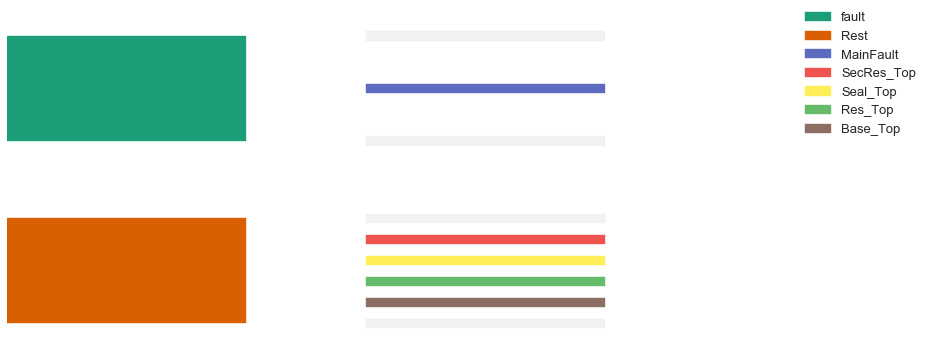

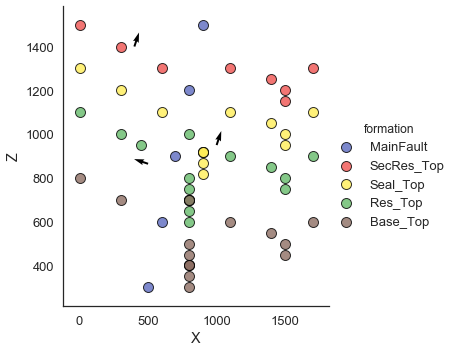

In [3]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

gp.plot_data(geo_data)

In [4]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
geo_data.interfaces['fault side'] = 'nan'
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
nonfault_cond = geo_data.interfaces['formation'] != 'MainFault'
fault_cond = geo_data.interfaces['formation'] == 'MainFault'

fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

geo_data.interfaces.set_value(fw_x_cond,'fault side','footwall') # setting FW
geo_data.interfaces.set_value(hw_x_cond,'fault side','hanging wall') #setting HW
geo_data.interfaces.set_value(fault_cond,'fault side','nan'); # reverting fault points to 'nan'

In [5]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3, 3],
                                   compile_theano=True, dtype ='float64')

Level of Optimization:  fast_run
Device:  cpu
Precision:  float64


In [6]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [7]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

In [8]:
# CREATING SURFACES FOR LAYERS
base_surf, base_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Base_Top']))
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Res_Top']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Seal_Top']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['SecRes_Top']))
#fault_surf, fault_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['MainFault']))

In [9]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plot_surfaces_3D(geo_data, [base_surf, sec_res_surf, seal_surf, res_surf], 
                    [base_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=False
                   )

In [10]:
#export = True
#
#if export:
#    gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(lith_sol[0]), path="original model")

In [11]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 3

C:\Users\Fabian\Anaconda3\lib\site-packages\gempy\Visualization.py:253: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  im = plt.imshow(plot_block[_a, _b, _c].T, origin="bottom", cmap=self._cmap, norm=self._norm,


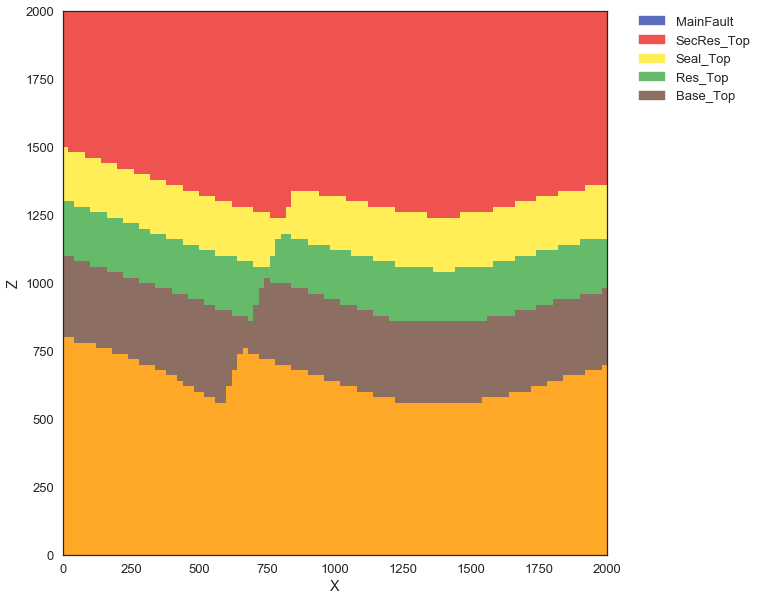

In [12]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
gp.plot_section(geo_data, lith_sol[0], resolution/2, plot_data=0)

In [13]:
# FUNCTION TO FIND ANTICLINAL SPILL POINT AND CROSS-FAULT LEAK POINT

    #@staticmethod # possibly use to find saddle points!
    #def squared_euclidean_distances(x_1, x_2):
    #    """
    #    Compute the euclidian distances in 3D between all the points in x_1 and x_2
    #    Args:
    #        x_1 (theano.tensor.matrix): shape n_points x number dimension
    #        x_2 (theano.tensor.matrix): shape n_points x number dimension
#
    #    Returns:
    #        theano.tensor.matrix: Distancse matrix. shape n_points x n_points
    #    """
#
    #    # T.maximum avoid negative numbers increasing stability
    #    sqd = T.sqrt(T.maximum(
    #        (x_1**2).sum(1).reshape((x_1.shape[0], 1)) +
    #        (x_2**2).sum(1).reshape((1, x_2.shape[0])) -
    #        2 * x_1.dot(x_2.T), 0
    #    ))
#
    #    return sqd

def spill_leak_P(interp_data, res_surf, lith, fault, print_figures=False):    
    
    # creating a grid with uniform distances for vertices of the reservoir surface
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.grid[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.grid[:, 1]))

    grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    # order of values that serve to find relative extrema (min/max)
    rel_order_maxX = 5
    rel_order_maxY = 10
    rel_order_minX = 5
    rel_order_minY = 5
    
    # check grid_z0 for max and min in directions x and y
    # direction X
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order_minX,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxX,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1           # grid of min in X
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1           # grid of max in X
    
    #direction Y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order_minY,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxY,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1           # grid of min in Y
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1           # grid of max in Y
    
    # fault leak line: defining line of juxtaposition, point of cross-fault leakage to be found on it
    # check for minima line that is on hanging wall side compared to max contact of layer top with fault
    fault_max_line_bool = np.copy(grid_maxX)
    fault_max_line = fault_max_line_bool.argmax(axis=1)
    fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold        
    fleak_line = np.copy(grid_minX).astype(int)
    fleak_line[:,fault_max:]=0 # only returns minima at hanging wall side
    
    # minmax buffering - not used atm
    # supposed to set neighboring values of min and max to min and max respectively, too 
    if minmax_buffer:
        minXroll1 = np.logical_or(grid_minX,np.roll(grid_minX,1, axis=0))
        minXroll1[:,:fault_max] = 0
        minXroll2 = np.logical_or(grid_minX,np.roll(grid_minX,-1, axis=0))
        minXroll2[:,:fault_max] = 0
        minXbuffer = np.logical_or(minXroll1, minXroll2)
        grid_minX = np.logical_or(grid_minX, minXbuffer)
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1, axis=1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1, axis=1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    
    #fleak_line_z0 = grid_z0[fleak_line]
    #leak_max = fleak_line==np.nanargmax(fleak_line_z0)
    #print(np.nanargmax(fleak_line_z0))
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?
    
    # distinguish anticlinal spill points from fault leak points:
    pot_leak_points = np.logical_and(fleak_line,saddle_p_all)    
    pot_spill_points = saddle_p_all - pot_leak_points    # substracting leak bool from saddle point bool 
                                                    # to get spill point bool    
    # leak and spill point 3D coordinates
    # LEAK POINT
    #if juxtaposition_over_seal(lith, fault) == True: #check for juxtaposition with layers above seal (due to offset)
    
    pot_leak_Xcoord = grid_x[pot_leak_points]
    pot_leak_Ycoord = grid_y[pot_leak_points]
    pot_leak_Zcoord = grid_z0[pot_leak_points]    
    pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
        
    if pot_leak_3Dcoord.size == 0:
        fault_leak_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
        fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:] # max is LP
        
    # SPILL POINT
    pot_spill_Xcoord = grid_x[pot_spill_points]
    pot_spill_Ycoord = grid_y[pot_spill_points]
    pot_spill_Zcoord = grid_z0[pot_spill_points]    
    pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
    
    if pot_spill_3Dcoord.size == 0:
        anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
        anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:] # max is SP
        
    #print('SP',anticline_spill_3Dcoord)
    #print('LP',fault_leak_3Dcoord)
    
    # PLOTTING (for visualization and checking)
    # plot of min/max bools and all potential LPs(+) and SPs(x):
    if print_figures==True:
        figsize(15,6)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
        ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
        #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
        #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        
        plt.show()
    
        # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
        plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
    
    return anticline_spill_3Dcoord, fault_leak_3Dcoord

In [14]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5) # rounding up scale_factor or rescale_f?
    mask = mask.reshape(resolution,resolution,resolution) #(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(resolution**3,)
    return mask

def topo_analysis(lith, fault, fault_seal, seal_th):
    #fig = plt.figure()
    traps = []
    SSF = 0
    trap_control = 0
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (8,8)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
    gp.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    trap_keys = [int(k) for k in lith_to_labels_lot["7"].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["8"].keys()] # model border sections
    secres_nr = interp_data.get_formation_number()['Seal_Top']
    over_nr = interp_data.get_formation_number()['SecRes_Top']
    res_nr = interp_data.get_formation_number()['Base_Top']
    base_keys = [int(b) for b in lith_to_labels_lot["0"].keys()]
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_nr].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
    tot_under_keys = np.append(res_keys, base_keys) # all sections that belong to underlying below seal
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    # If too many traps, model probably broken:
    print("NUMBER OF TRAPS", len(trap_keys))
    if len(trap_keys) > 10:
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        SSF = 0
        trap_control = 0
        return trap_mask, SSF, trap_control
    else:
        # Check for each possible trap section, if it is connected to a border
        for tk in trap_keys:
            print('Checking Section:', tk)
            # Check for adjacency to model border
            if gp.topology_check_adjacency(G, tk, pad_keys[0]) == False:
                # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
                fault_seal_bool, SSF, trap_control = juxta_SSF_check(G, tk, res_keys, tot_under_keys, tot_over_keys, topo_block, seal_th)
                if fault_seal_bool == True:
                    traps.append(tk)
                    print('TRAP:', tk)
        if traps == []:
            print('No trap found! =(')
        else:
            for i in traps:
                # Creating a mask from the trap sections in the label block
                top_bool = topo_block == i
                bool_block[top_bool] = True
        # Removing padding
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        return trap_mask, SSF, trap_control # this mask returns True for all voxels which were accepted as trap voxels

In [15]:
def juxta_SSF_check(G, tk, res_keys, tot_under_keys, tot_over_keys, topo_block, seal_th):
    throw = 0
    jp=0
    trap_c = 4
    # FIRST: check the adjacency area only for the trap: only the point of highest throw is relevant for SSF
    for tk in res_keys:
        for ok in tot_over_keys:  
            if gp.topology_check_adjacency(G, tk, ok) == True:
                if G.adj[tk][ok]['edge_type'] == 'stratigraphic':
                    print("Stratigraphic adjacency, leakage assumed!")
                    sealing = False
                    SSF = 0
                    trap_c = 4
                    return sealing, SSF, trap_c                     # stratigraphic adjancency assumed to always leak
                elif G.adj[tk][ok]['edge_type'] == 'fault':
                    trap_jshape = gp.Topology.compute_adj_shape(tk,ok,topo_block, ext=None)[3]
                    # fault throw at edge of trap section, voxels*scale_factor to get height in [m]
                    if trap_jshape !=0:
                        y_ext = trap_jshape[1]
                        z_ext = trap_jshape[2]
                        # finding point of greatest throw for trap --> relevant for total fault throw and SSF
                        # bottom of trap is flat, so need to find only highest z-values for juxtaposition:
                        z_max = max(z_ext)
                        # finding the y.axis range in which this highest throw appears:
                        y_range = y_ext[z_ext==z_max]
                        y_min = min(y_range)
                        y_max = max(y_range)
                        ## creating mask where values within this range = True --> to appl
                        #y_ext_bool = np.logical_and(y_ext>=y_min, y_ext<=y_max)
                        #y_bool_mask = np.copy(y_ext)
                        #y_bool_mask[~y_ext_bool] = False
                        #y_bool_mask[y_ext_bool] = True
                        ## the following can be used to find the throw height for one area
                        #y_bool = y_bool_mask==True
                        #print(z_ext[len_bool])
                        jp+=1
                        
    # SECOND: check for adjancencies between all seal-underlying and seal-overlying formations to
    # determine total fault throw at point/range defined over trap (y_bool)
    if jp != 0:
        for uk in tot_under_keys:
            for ok in tot_over_keys:  
                if gp.topology_check_adjacency(G, uk, ok) == True:
                    #print("Adjacency with section:", ok)
                    if G.adj[uk][ok]['edge_type'] == 'stratigraphic':
                        print("Stratigraphic adjacency, leakage assumed!")
                        sealing = False
                        SSF = 0
                        trap_c = 4
                        return sealing, SSF, trap_c     # stratigraphic adjancency assumed to always leak
                    elif G.adj[uk][ok]['edge_type'] == 'fault':
                        # get the array for z-extent for this adj-area, then mask to relevant range
                        section_jshape = gp.Topology.compute_adj_shape(uk,ok,topo_block, ext=None)[3]
                        if section_jshape != 0:
                            section_z_ext = section_jshape[2]
                            # creating mask where values within this range = True --> to appl
                            section_y_ext = section_jshape[1]
                            y_ext_bool = np.logical_and(section_y_ext>=y_min, section_y_ext<=y_max)
                            y_bool_mask = np.copy(section_y_ext)
                            y_bool_mask[~y_ext_bool] = False
                            y_bool_mask[y_ext_bool] = True
                            #print(y_min, y_max)
                            #print(section_y_ext)
                            if np.count_nonzero(y_bool_mask) != 0:
                                #print(section_z_ext)
                                #print(y_bool_mask)
                                # the following can be used to find the throw height for one area
                                y_bool = y_bool_mask==True
                                section_z_range = section_z_ext[y_bool]
                                #print(section_z_range)
                                # get the throw height:
                                z_len = max(section_z_range)-min(section_z_range)+1
                                # calculate throw in [m] for this adjacency and add to total
                                section_throw = z_len*scale_factor
                                throw += section_throw
                                print("Adding %s to throw, adjacency between %s and %s" % (section_throw, uk, ok))
                                jp+=1
    if jp == 0:
        print('No JP with any layer over seal.')
        SSF = 0
        sealing = True
        trap_c = 0
        return sealing, SSF, trap_c
    else:
        print('JP with layer over seal, checking SSF.')
        tot_fault_throw = throw + seal_th
        SSF = tot_fault_throw/seal_th
        print('SSF = %s / %s = %s' % (tot_fault_throw, seal_th, SSF))
        if SSF > SSF_c:
            print('SSF threshold exceeded, shale smear assumed to be incomplete.')
            sealing = False
            trap_c = 3
            return sealing, SSF, trap_c
        else: 
            print('SSF in confidence range, complete shale smear sealing assumed.')
            sealing = True
            trap_c = 0
            return sealing, SSF, trap_c
#def juxta_SSF_check(G, tk, tot_over_keys, topo_block, seal_th):
#    trap_throw = 0
#    jp=0
#    for ok in tot_over_keys:  
#        if gp.topology_check_adjacency(G, tk, ok) == True:
#            print("Adjacency with section:", ok)
#            if G.adj[tk][ok]['edge_type'] == 'stratigraphic':
#                print("Stratigraphic adjacency, leakage assumed!")
#                return False                         # stratigraphic adjancency assumed to always leak
#            elif G.adj[tk][ok]['edge_type'] == 'fault':
#                # fault throw at edge of trap section, voxels*scale_factor to get height in [m]
#                print("Fault edge adjacency! Analyse shape.")
#                section_throw = gp.Topology.compute_adj_shape(tk,ok,topo_block, ext=None)[2]*scale_factor
#                trap_throw += section_throw
#                print("Adding %s to throw, over_section: %s" % (section_throw, ok))
#                jp+=1
#    if jp == 0:
#        print('No JP with any layer over seal.')
#        return True
#    else:
#        print('JP with layer over seal, checking SSF.')
#        tot_fault_throw = trap_throw + seal_th
#        SSF = tot_fault_throw/seal_th
#        print('SSF = %s / %s = %s' % (tot_fault_throw, seal_th, SSF))
#        if SSF > SSF_c:
#            print('SSF threshold exceeded, shale smear assumed to be incomplete.')
#            return False
#        else: 
#            print('SSF ok, complete shale smear sealing assumed.')
#            return True
#            
# Shale Smear Factor SSF = Fault throw / Shale layer thickness
# SSF threshold = 7 --> incomplete shale smear to be expected for higher values
# SGR equivalent = 14%
# Shale Gouge Ratio SGR = (Sum(Shale bed thickness in throw)/Fault throw)*100%
# Attention: Need to count shale thickness into throw!
# From: Yielding et al. (1997)

In [16]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(interp_data, lith, fault, res_surface, fault_sealing, seal_th):
    trap_control = 0 # intitiating variable that indicates what kind of mechanism controls the trap volume
                        # 0 = Unclear; 1 = Spill Point; 2 = Leak Point; 3 = Seal breach juxtaposition leakage;
                        # 4 = Stratigraphical adjacency leakage
    bottom_surface = np.ones_like(res_surface) # needed?   
    spill_point, leak_point = spill_leak_P(interp_data, res_surface, lith, fault, print_figures=False)
    print("SPILL POINT AT:", spill_point)
    print("LEAK POINT AT:", leak_point)
    #CHECK: ONLY CONTINUE IF SPILL POINT FOUND, ELSE RETURN ZERO TRAP VOLUME
    if spill_point.size == 0:
        spill_z = np.nan
        #print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith)
        return trap_vol, lith, bottom_surface, final_trap_mask    
    else:
        #print('SPILL POINT:',spill_point)
        spill_z = spill_point[2]
        #spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
        # calculate leak point
        if leak_point.size == 0:
            #print('No LEAK POINT found! So FULL LEAKAGE assumed!')
            #leak_z = np.nan
            leak_z = 2000
        else:
            #print('Leak Point:',leak_point)
            leak_z = leak_point[2]
        #leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
        
        # Check for "down-to" z-horizon, maximum depth of reservoir
        # Check for fault sealing and subsequent relevance of leak point
        max_z = np.nanmax([spill_z, leak_z])
        #if fault_sealing == True:
        #    if max_z == spill_z:
        #        print("Spill point defines trap.")
        #        print("Fault is sealing. Down to spill.")
        #        #bottom_surface = spill_bottom
        #    else:
        #        print("Fault leak point above spill point.")
        #        max_z = spill_z
        #        print("...but fault sealing. Down to spill.")
        #        #bottom_surface = spill_bottom
        #else:
        #    if max_z == spill_z:
        #        print("Spill point defines trap.")
        #        print("Fault is pathway. Down to spill.")
        #        #bottom_surface = spill_bottom
        #    else:
        #        print("Fault leak point above spill point.")
        #        print("Cross-fault leakage. Down to leak.")
        #        #bottom_surface = leak_bottom    
        if max_z == spill_z:
            trap_control = 1
        else:
            trap_control = 2                
        
        res_nr = interp_data.get_formation_number()['Base_Top']
        res_nr_bool = lith == res_nr
        pre_trap_mask = res_mask(lith, fault, max_z, res_nr_bool)
          
        # volume cells for counting
        vol_cells = 0      
        
        pre_trap_mask_bool = (pre_trap_mask == True)
        # Check if there is anaything in the reservoir mask at all
        if np.count_nonzero(pre_trap_mask_bool) == 0:
            print("No res_formation above max_z!")
            SSF = 0
            trap_control = 0
            return 0, lith, bottom_surface, pre_trap_mask, SSF, trap_control
        else:
            lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
            final_trap_mask, SSF, trap_c = topo_analysis(lith, fault, fault_sealing, seal_th)
            if trap_c == 3:
                trap_control = trap_c
            elif trap_c == 4:
                trap_control = trap_c
            #lith[pre_trap_mask_bool] = 5
            lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
            vol_cells = np.count_nonzero(final_trap_mask)
            
            #calulate volume from cells
            trap_vol = ((scale_factor)**3) * vol_cells 
            # revert to lith_block without any masks
            lith[pre_trap_mask_bool] = res_nr        
            #return the maximum reservoir volume
            return trap_vol, lith, bottom_surface, final_trap_mask, SSF, trap_control

In [17]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [18]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)

# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

#res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z'])    

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_secres_top = 40 #* unc_f
std_seal_top = 60 #* unc_f
std_res_top = 80 #* unc_f
std_base_top = 100 #* unc_f
z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0/rescale_f, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

# SETTING FAULT OFFSET UNCERTAINTY
std_offset = 150
#offset_unc = pymc.Normal('offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f))
# using SkewNormal, so that fault offset is much more like to vary to a higher offset and to stay as a normal fault
offset_unc = pymc.SkewNormal('offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

# FAULT SEALING UNCERTAINTY (p = probability of success (1 = True); True = fault sealing)
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=0)

In [19]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

# Combining hanging wall and formation conditions
HW_secres_top = np.logical_and(secres_top_cond,hanging_wall)
HW_seal_top = np.logical_and(seal_top_cond,hanging_wall)
HW_res_top = np.logical_and(res_top_cond,hanging_wall)
HW_base_top = np.logical_and(base_top_cond,hanging_wall)

#interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',25)

In [22]:
# PYMC MODEL FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
# and including offset uncertainty:
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top = z_unc_secres_top, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_base_top = z_unc_base_top, off_unc=offset_unc):
    #print('CHECK0:', res_z)
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top   
    
    # for offset uncertainty: additional change on hanging wall (HW): 
    HW_new_z_secres_top = new_z_secres_top + off_unc
    HW_new_z_seal_top = new_z_seal_top + off_unc
    HW_new_z_res_top = new_z_res_top + off_unc
    HW_new_z_base_top = new_z_base_top + off_unc

    print('Z variations top to bottom:', z_unc_secres_top*rescale_f, 
          z_unc_seal_top*rescale_f, z_unc_res_top*rescale_f, z_unc_base_top*rescale_f)
    
    print('Fault offset variation:', off_unc*rescale_f)
    #print('CHECK1:', new_z_res_top)
    #print('CHECK2:', HW_new_z_res_top)
    
    # FOOTWALL UNCERTAINTY
    interp_data.geo_data_res.interfaces.set_value(secres_top_cond,'Z',new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(seal_top_cond,'Z',new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(res_top_cond,'Z',new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(base_top_cond,'Z',new_z_base_top)
    
    # HANGING WALL UNCERTAINTY (incl. offset)
    interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',HW_new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(HW_seal_top,'Z',HW_new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(HW_res_top,'Z',HW_new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(HW_base_top,'Z',HW_new_z_base_top)
    
    #print('CHECK3:', interp_data.geo_data_res.interfaces)    
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled chosen X-position (here: 1100), 
# we simply calculate 2000-fw_th_point(here:900) rescaled (see fw_x)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.
#rescale_f = interp_data.rescaling_factor

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)             

# Volumetric calculation 
@pymc.deterministic
def structural_model(interp_data_M=interp_unc, fault_sealing=fault_sealing, seal_th=seal_th,
                     lh=lith_holder, fh=fault_holder, idh=interp_holder, print_figures=False):
    #print('Fault sealing =', fault_sealing)
    try:
        lith_sol, fault_sol = gp.compute_model(interp_data_M)
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]  
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap, SSF, trap_control = max_trap_vol(interp_data_M, lith_block, fault_block, res_top_surf, fault_sealing, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            gp.plot_section(geo_data, lith_sol[0], resolution/2, plot_data =0)
            #gp.plot_section(geo_data, trap, resolution/2, plot_data =0)
        # revert lith_block back to formation numbers only (or can I include trap in plot?)
        
        #return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        return max_vol, SSF, trap_control
    except np.linalg.linalg.LinAlgError as err:
        # In case of LinAlgError, use original model
        print('LinAlgError occurred!')
        lith_sol = lh
        fault_sol = fh
        lith_block = lith_sol[0]
        fault_block = fault_sol[0] 
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = idh, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap, SSF, trap_control = max_trap_vol(idh, lith_block, fault_block, res_top_surf, fault_sealing, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        #return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        return max_vol, SSF, trap_control
    
    ### RETURN INDICES:
    ### 0 = lith_sol
    ### 1 = fault_sol
    ### 2 = max_vol (maximum trap volume)
    ### 3 = trap (block)
    ### 4 = SSF (Shale Smear Factor)
    ### 5 = trap_control (controling mechanism for max trap volume)
    
# Check juxtaposition area with layers above seal
#@pymc.deterministic
#def over_jux_area(lith_sol=structural_model[0], fault_sol=structural_model[1]):
#    lith = lith_sol[0].reshape(resolution,resolution,resolution)
#    fault = fault_sol[0].reshape(resolution,resolution,resolution)
#    area = 0
#    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot = \
#    gp.topology_analyze(lith, fault, 1, areas_bool=True, return_block=False)
#    res_nr = interp_data.get_formation_number()['Base_Top']
#    secres_nr = interp_data.get_formation_number()['Seal_Top']
#    over_nr = interp_data.get_formation_number()['SecRes_Top']
#    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_nr].keys()]
#    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
#    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
#    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
#    for rk in res_keys:
#        for ok in tot_over_keys:
#            if gp.topology_check_adjacency(G, rk, ok) == True:
#                    if G.adj[rk][ok]['edge_type'] == 'fault':
#                        part_area = G.adj[rk][ok]['area']*(scale_factor**2)
#                        area += part_area
#    return area       
                
# Avoid layer inversion by giving negative thicknesses a likelihood of zero
#@pymc.deterministic
#def no_inversion(sec_res_th=sec_res_th, res_th=res_th, seal_th=seal_th)

Z variations top to bottom: 39.7907847835 17.4262479323 152.05014065 49.5970973709
Fault offset variation: 27.3294962652


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to m

SPILL POINT AT: [ 1373.73742676   929.29290771   993.27807901]
LEAK POINT AT: [  727.27270508   969.69696045  1032.06188229]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [105.37610728180334] / [65.376107281803343] = [1.6118443214671718]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 8024000.0 m³


In [50]:
iterations = 100

In [51]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th])
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [52]:
M = pymc.MCMC(model)
#M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)

Z variations top to bottom: 64.521850276 -123.388078783 -12.932131343 118.082395276
Fault offset variation: -100.799230226


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


SPILL POINT AT: [ 1353.53540039   949.49493408   829.32563115]
LEAK POINT AT: [ 626.26263428  949.49493408  744.67190334]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [229.54405256019368] / [89.544052560193677] = [2.563476255509975]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21176000.0 m³
 [                  2%                  ] 2 of 100 complete in 8.5 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Z variations top to bottom: -6.58899857534 32.2405550931 -46.6601444838 -131.651207213
Fault offset variation: -102.880255568
SPILL POINT AT: [ 1353.53540039   929.29290771   796.33306897]
LEAK POINT AT: [ 626.26263428  949.49493408  730.39591029]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24376000.0 m³
 [-                 3%                  ] 3 of 100 complete in 17.0 secZ variations top to bottom: 36.2772472619 8.65274290711 9.83723317103 160.679415682
Fault offset variation: -0.735587990656
SPILL POINT AT: [ 1353.53540039   929.29290771   852.50135532]
LEAK POINT AT: [ 666.66668701  949.49493408  863.00478149]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14784000.0 m³
 [-                 4%                  ] 4 of 100 complete in 25.3 secZ variations top to bottom: -38.361206848 -105.38466498 -37.3988177659 -172.111201784
Fault 

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19408000.0 m³
 [------           16%                  ] 16 of 100 complete in 126.4 secZ variations top to bottom: 45.7145056068 53.4700681627 -35.3987285269 -46.6323894687
Fault offset variation: 54.7403164983
SPILL POINT AT: [ 1353.53540039   929.29290771   807.74555857]
LEAK POINT AT: [ 666.66668701  969.69696045  899.14207877]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 4056000.0 m³
 [------           17%                  ] 17 of 100 complete in 134.7 secZ variations top to bottom: 44.6170799233 -28.9115800646 12.0221327456 -63.4023701147
Fault offset variation: -178.398145987
SPILL POINT AT: [ 1373.73742676   929.29290771   854.67608689]
LEAK POINT AT: [ 606.06060791  949.49493408  698.9219119 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0

 [-----------      31%                  ] 31 of 100 complete in 253.8 secZ variations top to bottom: 63.012716378 56.082056795 -101.932266548 38.568834418
Fault offset variation: -32.3639820108
SPILL POINT AT: [ 1373.73742676   929.29290771   741.8850773 ]
LEAK POINT AT: [ 626.26263428  949.49493408  744.04138405]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20112000.0 m³
 [------------     32%                  ] 32 of 100 complete in 262.4 secZ variations top to bottom: 2.60413134511 -36.3247801428 -96.3139088421 136.464027209
Fault offset variation: -15.4371617757
SPILL POINT AT: [ 1373.73742676   929.29290771   747.58405713]
LEAK POINT AT: [ 626.26263428  949.49493408  760.13414856]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11600000.0 m³
 [------------     33%                  ] 33 of 100 complete in 271.1 secZ variations top to

 [-----------------46%                  ] 46 of 100 complete in 384.8 secZ variations top to bottom: -44.2206395778 -65.027223413 11.6786004318 -143.302613859
Fault offset variation: -158.320238642
SPILL POINT AT: [ 1373.73742676   929.29290771   854.22360074]
LEAK POINT AT: [ 606.06060791  949.49493408  720.30542134]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [283.29417615520811] / [123.29417615520811] = [2.2977093078474771]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 22376000.0 m³
 [-----------------47%                  ] 47 of 100 complete in 393.3 secZ variations top to bottom: -15.0620822379 84.4314389975 5.10332769117 78.9075584527
Fault offset variation: -101.340034711
SPILL POINT AT: [ 1373.73742676   929.29290771   847.80837335]
LEAK POINT AT: [ 626.26263428  949.49493408  771.62645711]
NUMBER OF TRAPS 2
Checking Sectio

SPILL POINT AT: [ 1353.53540039   949.49493408   845.94075161]
LEAK POINT AT: [ 686.86871338  969.69696045  919.29220627]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 2824000.0 m³
 [-----------------61%---               ] 61 of 100 complete in 515.4 secZ variations top to bottom: 36.3104388425 -19.5827668867 241.061499605 -48.7340436921
Fault offset variation: -83.9010736556
SPILL POINT AT: [ 1393.93945312   909.09088135  1022.03650429]
LEAK POINT AT: [  505.05050659   727.27270508  1020.39486115]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 14272000.0 m³
 [-----------------62%---               ] 62 of 100 complete in 523.9 secZ variations top to bottom: -49.2905435895 -80.7465625958 40.00584875 -290.308254973
Fault offset variation: -243.710151179
SPILL POINT AT: [ 1373.73742676   949.49493408   882.09241262]
LEAK POINT AT: [ 606.060

SPILL POINT AT: [ 1353.53540039   929.29290771   854.76424444]
LEAK POINT AT: [ 626.26263428  949.49493408  762.46819732]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [234.46438347393587] / [134.46438347393587] = [1.7436913583840115]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22360000.0 m³
 [-----------------75%--------          ] 75 of 100 complete in 636.9 secZ variations top to bottom: -6.07836100052 20.0008406495 65.6250109855 4.63509839443
Fault offset variation: -222.604363047
SPILL POINT AT: [ 1373.73742676   929.29290771   907.89903249]
LEAK POINT AT: [ 606.06060791  949.49493408  714.00446655]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [394.37582966392119] / [154.37582966392119] = [2.5

 [-----------------90%--------------    ] 90 of 100 complete in 764.3 secZ variations top to bottom: 37.5403050485 29.8649527948 68.7451916113 117.540007723
Fault offset variation: -42.5596280476
SPILL POINT AT: [ 1373.73742676   929.29290771   910.96584766]
LEAK POINT AT: [ 666.66668701  949.49493408  878.96954148]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [181.11976118349003] / [161.11976118349003] = [1.1241312664138272]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18888000.0 m³
 [-----------------91%--------------    ] 91 of 100 complete in 773.0 secZ variations top to bottom: 12.5173741281 -28.0036019566 35.7816576088 -11.5528608179
Fault offset variation: 25.0213214881
SPILL POINT AT: [ 1373.73742676   929.29290771   878.4138926 ]
LEAK POINT AT: [ 686.86871338  969.69696045  919.21499892]
NUMBER OF TRAPS 2
Checking Section: 

In [26]:
# Reload a model database:
#self.db = pymc.database.hdf5.load("D:/PyMC_DataBase/test1.hdf5")
#self.lb, self.fb = self.db.trace(pymc_model_f)[:]

In [53]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume,[3]=trap_block
#over_jux_area_trace = M.trace('over_jux_area')[:] 

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

max_volume_trace = structural_model_trace[:,2]
SSF_trace = structural_model_trace[:,4]
trap_control_trace = structural_model_trace[:,5]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

In [24]:
#M.db.commit()

In [25]:
#M.db.close()

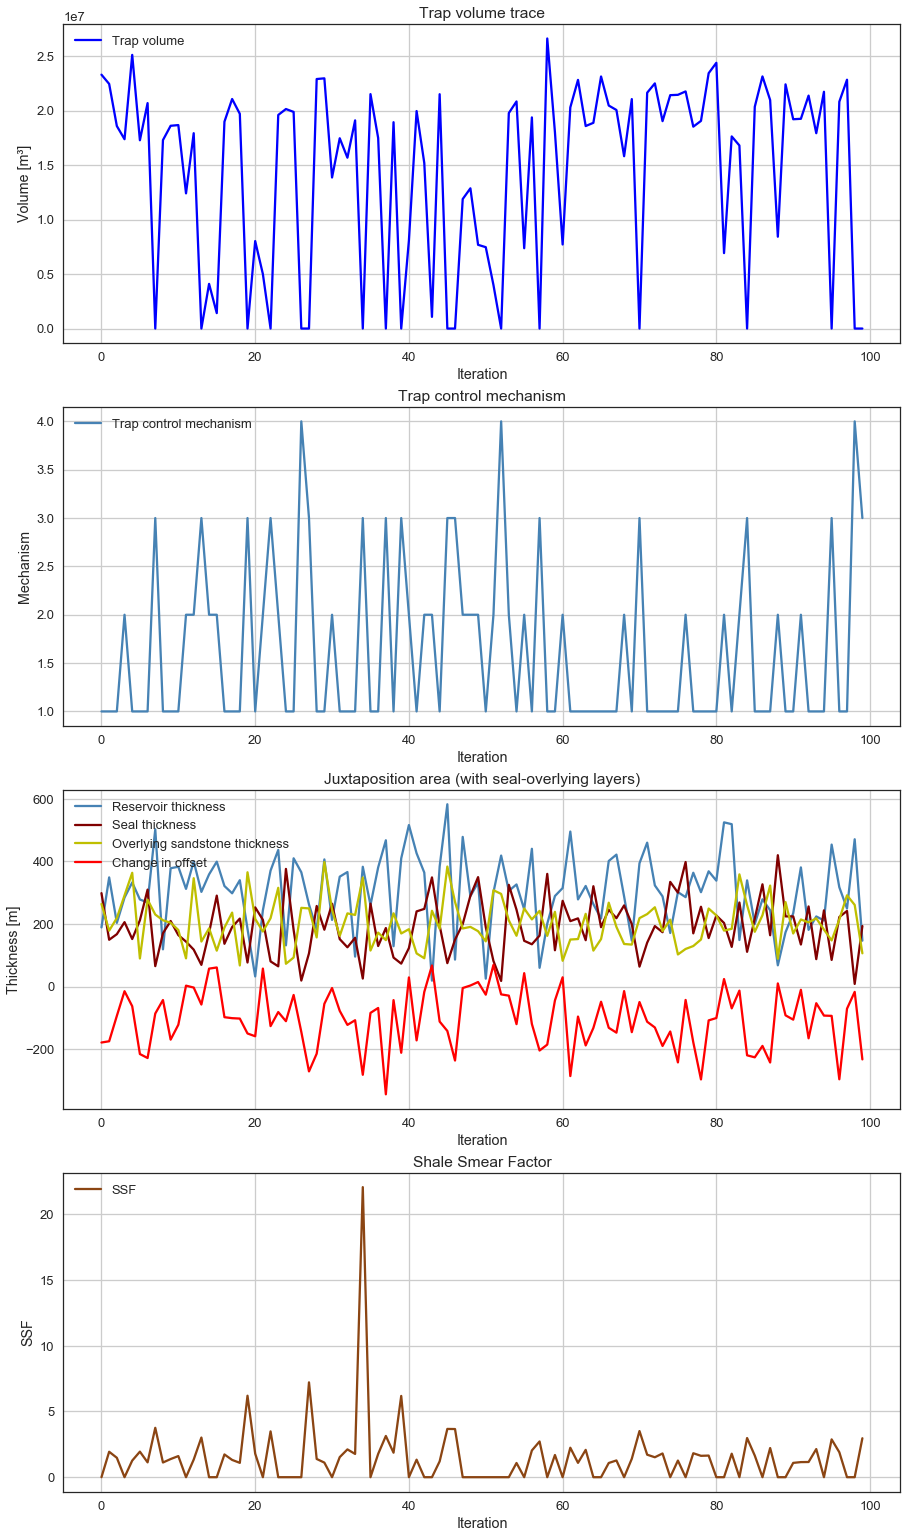

In [29]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

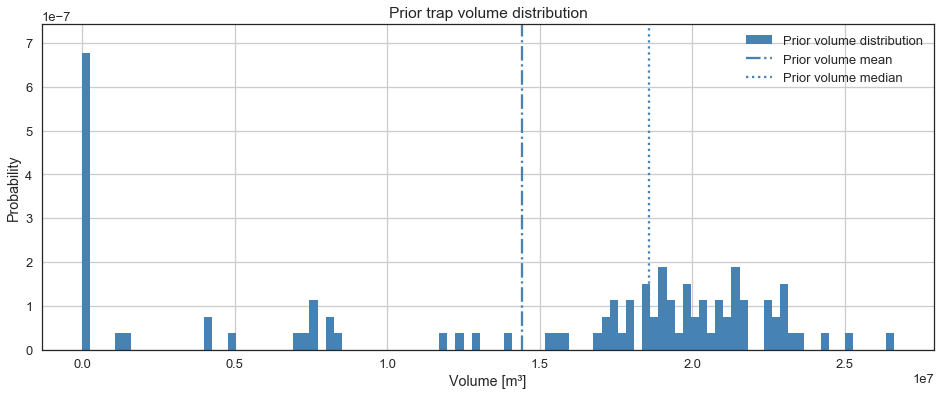

In [31]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [54]:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/14_11-TRAP_100iterUNC_PRIORonly_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/14_11-LITH_100iterUNC_PRIORonly_%s" % (counter))

In [21]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

In [56]:
lith_blocks = []
for i in structural_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0].astype(int))

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

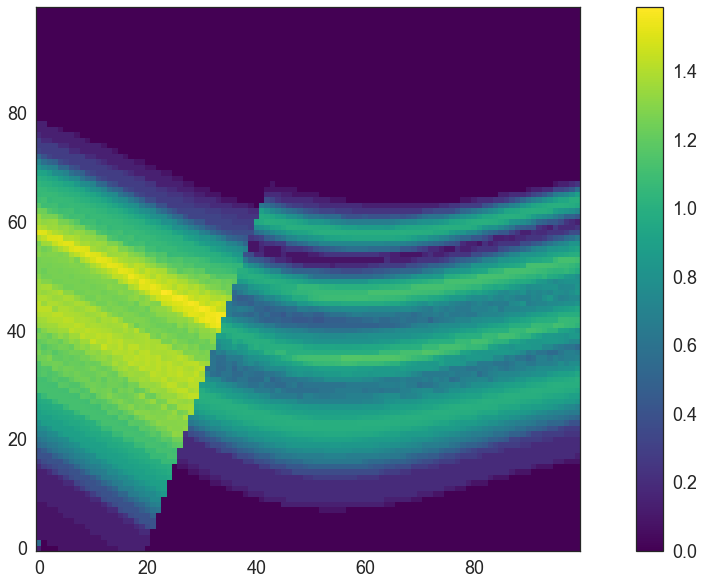

In [58]:
figsize(20,10)
fig, ax = plt.subplots(1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [36]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s == 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s == 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = np.abs((true_s[overest_bad]-estimate_s))*(ov_b*risk_s)
        return loss_s
    
#def volume_lossR(estimate_s, true_s, risk_s):
#        loss_s = np.zeros_like(true_s)
#        underest = (estimate_s < true_s) 
#        underest_bad = (estimate_s <= 0) & (true_s > 0)
#        overest = (estimate_s > true_s) 
#        overest_bad = (estimate_s > 0) & (true_s <= 0)
#        loss_s[underest] = (true_s[underest] - estimate_s)
#        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
#        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
#        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
#        return loss_s

Bayes action (minimum) at risk r 0.50: 19048000.00 --- expected loss: 5855210.00
Bayes action (minimum) at risk r 0.75: 17920000.00 --- expected loss: 8183920.00
Bayes action (minimum) at risk r 1.00: 16792000.00 --- expected loss: 10300800.00
Bayes action (minimum) at risk r 1.25: 12400000.00 --- expected loss: 11980835.00
Bayes action (minimum) at risk r 1.50: 7712000.00 --- expected loss: 12946380.00


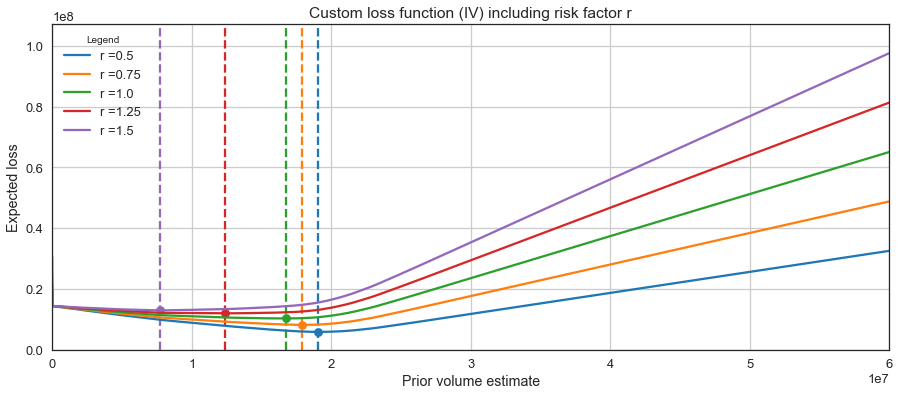

In [36]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
#plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Prior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

In [22]:
# THICKNESS LIKELIHOOD FUNCTIONS
#Additional information, updating with likelihoods

#return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z

std1 = 30
std2 = 10
std3 = 30

#@pymc.stochastic
#def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
#    return pymc.normal_like(sec_res_th, 120., 1./np.square(std1))
#
#@pymc.stochastic
#def seal_th_likelihood(value = 0, seal_th=seal_th):
#    return pymc.normal_like(seal_th, 400., 1./np.square(std2))
#
#@pymc.stochastic
#def res_th_likelihood(value = 0, res_th=res_th):
#    return pymc.normal_like(res_th, 250., 1./np.square(std3))

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 300., 1./np.square(std1))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 50., 1./np.square(std2))

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 400., 1./np.square(std3))

In [42]:
# JUXTAPOSITION AREA LIKELIHOOD (not used)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

In [23]:
#model = pymc.Model([pos_unc_model, z_unc_res_top, fault_sealing, fw_th, hw_th, 
#                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
#model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    #fault_sealing, structural_model, 
                    #res_th, seal_th, sec_res_th, over_jux_area, 
                    #res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    fault_sealing, structural_model, 
                    res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])

In [24]:
iterations=120

In [25]:
M_L = pymc.MCMC(model_L)
#M_L = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_model_300_30-050_10-400_40_1000iter50burn.hdf5")
M_L.sample(iter=iterations, burn=20)

Z variations top to bottom: -102.081686808 -89.9179139898 68.4162422782 72.6180821694
Fault offset variation: 526.301147613
Z variations top to bottom: -119.451757136 -89.9179139898 68.4162422782 72.6180821694
Fault offset variation: -271.277652841
Z variations top to bottom: -102.081686808 -89.9179139898 143.041097522 72.6180821694
Fault offset variation: -271.277652841
Z variations top to bottom: -102.081686808 -89.9179139898 143.041097522 112.010964172
Fault offset variation: -271.277652841
Z variations top to bottom: -102.081686808 -161.183803442 143.041097522 72.6180821694
Fault offset variation: -271.277652841
Z variations top to bottom: -102.081686808

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to m

 -89.9179139898 143.041097522 72.6180821694
Fault offset variation: -271.277652841
Z variations top to bottom: -102.081686808 -89.9179139898 143.041097522 72.6180821694
Fault offset variation: -11.4408822162
Z variations top to bottom: -188.761900673 -89.9179139898 143.041097522 72.6180821694
Fault offset variation: -11.4408822162
Z variations top to bottom: -102.081686808 -89.9179139898 179.826662914 72.6180821694
Fault offset variation: -11.4408822162
Z variations top to bottom: -102.081686808 -89.9179139898 143.041097522 -71.2148103362
Fault offset variation: -11.4408822162
Z variations top to bottom: -102.081686808 -90.8720855184 143.041097522 72.6180821694
Fault offset variation: -11.4408822162
Z variations top to bottom: -102.081686808 -90.8720855184 143.041097522 72.6180821694
Fault offset variation: -34.972137315
Z variations top to bottom: -41.6263867779 -90.8720855184 143.041097522 72.6180821694
Fault offset variation: -34.972137315
Z variations top to bottom: -41.6263867779 

Fault offset variation: -183.323931018
Z variations top to bottom: 12.2911940925 -58.4733066159 177.304937379 42.8330963822
Fault offset variation: -183.323931018
Z variations top to bottom: 12.2911940925 -58.4733066159 177.304937379 42.8330963822
Fault offset variation: -227.293987928
Z variations top to bottom: 103.44084855 -58.4733066159 177.304937379 42.8330963822
Fault offset variation: -183.323931018
Z variations top to bottom: 12.2911940925 -58.4733066159 54.2097435293 42.8330963822
Fault offset variation: -183.323931018
Z variations top to bottom: 12.2911940925 -58.4733066159 177.304937379 -72.0414440409
Fault offset variation: -183.323931018
Z variations top to bottom: 12.2911940925 -53.6412130527 177.304937379 42.8330963822
Fault offset variation: -183.323931018
Z variations top to bottom: 12.2911940925 -58.4733066159 177.304937379 42.8330963822
Fault offset variation: -183.323931018
Z variations top to bottom: 12.2911940925 -58.4733066159 177.304937379 42.8330963822
Fault of

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


SPILL POINT AT: [ 1393.93945312   929.29290771   949.48655038]
LEAK POINT AT: [ 646.46466064  949.49493408  799.47450533]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [78.869600665183498] / [58.869600665183498] = [1.3397339165548026]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17856000.0 m³
 [------           18%                  ] 22 of 120 complete in 12.1 secZ variations top to bottom: 68.1407863152 -33.6288509089 107.501548426 -14.7331923781
Fault offset variation: -605.841327504
Z variations top to bottom: 145.306068841 -33.6288509089 107.501548426 -14.7331923781
Fault offset variation: -183.323931018
Z variations top to bottom: 68.1407863152 -33.6288509089 99.2879905904 -14.7331923781
Fault offset variation: -183.323931018
Z variations top to bottom: 68.1407863152 -33.6288509089 107.501548426 79.2020394266
Fault offset variat

SPILL POINT AT: [ 1393.93945312   949.49493408   951.48569001]
LEAK POINT AT: [ 626.26263428  949.49493408  738.01048172]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 300.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [416.32340084230395] / [56.323400842303954] = [7.3916594988278392]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        24%                  ] 29 of 120 complete in 71.7 secZ variations top to bottom: 27.926916313 -33.6288509089 110.047748249 -12.5719113176
Fault offset variation: -288.156533835
Z variations top to bottom: 11.755468875 -33.6288509089 110.047748249 -12.5719113176
Fault offset variation: -246.33498877
Z variations top to bottom: 11.755468875 -33.6288509089 115.1678187 -12.5719113176
Fault offset variation: -246.33498877
Z variations top to bottom: 11.755468875 -33.6288509089 115.1

 [-----------      29%                  ] 35 of 120 complete in 123.6 secZ variations top to bottom: 76.0629592133 -33.6288509089 115.1678187 8.97824839073
Fault offset variation: 170.850218973
Z variations top to bottom: -4.53514812505 -33.6288509089 115.1678187 8.97824839073
Fault offset variation: -296.537771268
Z variations top to bottom: 76.0629592133 -33.6288509089 69.3621254704 8.97824839073
Fault offset variation: -296.537771268
Z variations top to bottom: 76.0629592133 -33.6288509089 115.1678187 52.3570880895
Fault offset variation: -296.537771268
Z variations top to bottom: 76.0629592133 -253.243239416 115.1678187 52.3570880895
Fault offset variation: -296.537771268
SPILL POINT AT: [ 1252.52526855   868.68688965   768.15058461]
LEAK POINT AT: [ 484.84848022  565.65655518  354.89700683]
NUMBER OF TRAPS 2
Checking Section: 12
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.20333039132743] / [51.203330391327427] = [6.07779470618

 [-------------    35%                  ] 42 of 120 complete in 183.4 secZ variations top to bottom: 48.0213582994 -29.2831071532 115.1678187 13.771423792
Fault offset variation: -411.771326961
Z variations top to bottom: 65.6178717522 -29.2831071532 115.1678187 13.771423792
Fault offset variation: -162.022990754
Z variations top to bottom: 65.6178717522 -29.2831071532 172.459796903 13.771423792
Fault offset variation: -162.022990754
Z variations top to bottom: 65.6178717522 -29.2831071532 115.1678187 32.6631678998
Fault offset variation: -162.022990754
Z variations top to bottom: 65.6178717522 -39.3198007337 115.1678187 13.771423792
Fault offset variation: -162.022990754
SPILL POINT AT: [ 1393.93945312   949.49493408   956.51392889]
LEAK POINT AT: [ 646.46466064  949.49493408  819.07428876]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.51238056658326] / [45.512380566583261] = [6.712731278022860

 [---------------  40%                  ] 49 of 120 complete in 243.0 secZ variations top to bottom: 26.0057383838 -32.5903413369 115.1678187 -18.9749005138
Fault offset variation: -815.854919492
Z variations top to bottom: 57.6021811721 -32.5903413369 115.1678187 -18.9749005138
Fault offset variation: -133.291208762
Z variations top to bottom: 57.6021811721 -32.5903413369 47.5272229918 -18.9749005138
Fault offset variation: -133.291208762
Z variations top to bottom: 57.6021811721 -32.5903413369 115.1678187 130.369478873
Fault offset variation: -133.291208762
Z variations top to bottom: 57.6021811721 -148.501005389 115.1678187 -18.9749005138
Fault offset variation: -133.291208762
Z variations top to bottom: 57.6021811721 -32.5903413369 115.1678187 -18.9749005138
Fault offset variation: -133.291208762
SPILL POINT AT: [ 1393.93945312   949.49493408   956.60650112]
LEAK POINT AT: [ 646.46466064  949.49493408  846.93598163]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 240.0 to throw, adja

SPILL POINT AT: [ 1373.73742676   949.49493408   957.76032761]
LEAK POINT AT: [ 686.86871338  969.69696045  913.57438038]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [217.88075017389906] / [37.88075017389906] = [5.7517538373362322]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------46%                  ] 56 of 120 complete in 302.9 secZ variations top to bottom: -9.14953199913 -45.741674095 116.377575731 20.9018080336
Fault offset variation: 67.7165557172
Z variations top to bottom: 8.61526581912 -45.741674095 116.377575731 20.9018080336
Fault offset variation: 67.7165557172
Z variations top to bottom: 8.61526581912 -45.741674095 206.978693395 20.9018080336
Fault offset variation: 67.7165557172
Z variations top to bottom: 8.61526581912 -45.741674095 116.377575731 100.355489754
Fault offset variation: 67

SPILL POINT AT: [ 1373.73742676   949.49493408   957.87293901]
LEAK POINT AT: [ 666.66668701  949.49493408  897.72143009]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [229.65383279222328] / [49.653832792223284] = [4.6250977996645481]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------52%                  ] 63 of 120 complete in 362.7 secZ variations top to bottom: 56.6175267534 -33.9685914767 116.377575731 20.9018080336
Fault offset variation: -122.755439704
Z variations top to bottom: -58.7139228748 -33.9685914767 116.377575731 20.9018080336
Fault offset variation: -122.755439704
Z variations top to bottom: 56.6175267534 -33.9685914767 160.703359044 20.9018080336
Fault offset variation: -122.755439704
Z variations top to bottom: 56.6175267534 -33.9685914767 116.377575731 36.2440783938
Fault offset varia

SPILL POINT AT: [ 1373.73742676   929.29290771   957.88773758]
LEAK POINT AT: [ 686.86871338  969.69696045  944.60291412]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [188.44295902718636] / [48.442959027186362] = [3.8899968707822223]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------58%--                ] 70 of 120 complete in 422.4 secZ variations top to bottom: 33.7967240554 -35.1794652417 116.377575731 -9.79045136291
Fault offset variation: 354.086410597
Z variations top to bottom: 46.3827000921 -35.1794652417 116.377575731 -9.79045136291
Fault offset variation: -29.6326750404
Z variations top to bottom: 46.3827000921 -35.1794652417 27.5546836517 -9.79045136291
Fault offset variation: -29.6326750404
Z variations top to bottom: 46.3827000921 -35.1794652417 116.377575731 -183.421717242
Fault offset var

SPILL POINT AT: [ 1393.93945312   949.49493408   957.84584476]
LEAK POINT AT: [ 686.86871338  949.49493408  912.75250371]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [194.28982285428469] / [54.289822854284694] = [3.5787521977325967]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------64%----              ] 77 of 120 complete in 482.6 secZ variations top to bottom: -4.95817647238 -29.3326014146 116.377575731 4.39818417277
Fault offset variation: 67.1348673851
Z variations top to bottom: -13.3450413269 -29.3326014146 116.377575731 4.39818417277
Fault offset variation: -64.5318791405
Z variations top to bottom: -4.95817647238 -29.3326014146 28.5541701454 4.39818417277
Fault offset variation: -64.5318791405
Z variations top to bottom: -4.95817647238 -29.3326014146 116.377575731 -149.544071487
Fault offset va

SPILL POINT AT: [ 1393.93945312   929.29290771   962.54952629]
LEAK POINT AT: [ 626.26263428  949.49493408  767.82817961]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [201.91066013460136] / [41.910660134601358] = [4.8176444724597483]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------70%------            ] 84 of 120 complete in 542.1 secZ variations top to bottom: 80.4502841554 -37.3994574722 120.689882393 8.83231849808
Fault offset variation: -250.45290028
Z variations top to bottom: 29.1853000122 -37.3994574722 120.689882393 8.83231849808
Fault offset variation: -250.45290028
Z variations top to bottom: 29.1853000122 -37.3994574722 25.2780149311 8.83231849808
Fault offset variation: -250.45290028
Z variations top to bottom: 2

NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.57085147882253] / [56.570851478822533] = [4.5353896003292542]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------75%--------          ] 91 of 120 complete in 607.0 secZ variations top to bottom: 51.5550213822 -37.1433978282 106.285750693 3.26077721935
Fault offset variation: 189.573211915
Z variations top to bottom: 73.5101372514 -37.1433978282 106.285750693 3.26077721935
Fault offset variation: -98.8788555787
Z variations top to bottom: 73.5101372514 -37.1433978282 83.9330554478 3.26077721935
Fault offset variation: -98.8788555787
Z variations top to bottom: 73.5101372514 -37.1433978282 106.285750693 -71.7140890086
Fault offset variation: -98.8788555787
Z variations top to bottom: 73.5101372514 25.9480888171 106.285750693 3.26077721935
Fault offset varia

SPILL POINT AT: [ 1393.93945312   929.29290771   966.16383576]
LEAK POINT AT: [ 646.46466064  949.49493408  798.46231362]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [279.45563009214106] / [59.455630092141064] = [4.7002383064321425]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------81%-----------       ] 98 of 120 complete in 666.9 secZ variations top to bottom: 34.9880242418 -15.9235680726 124.620801835 -37.6543048003
Fault offset variation: -53.880278976
Z variations top to bottom: -41.7582475607 -15.9235680726 124.620801835 -37.6543048003
Fault offset variation: -53.880278976
Z variations top to bottom: 34.9880242418 -15.9235680726 138.000374081 -37.6543048003
Fault offset variation: -53.880278976
Z variations top to bottom: 34.9880242418 -15.923568072

SPILL POINT AT: [ 1393.93945312   949.49493408   975.35687198]
LEAK POINT AT: [ 686.86871338  969.69696045  969.93833194]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [156.52258034670945] / [56.522580346709447] = [2.7692044380599774]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19640000.0 m³
 [-----------------87%-------------     ] 105 of 120 complete in 735.0 secZ variations top to bottom: 34.7499120146 -9.42169846178 134.055721192 56.5373625186
Fault offset variation: -165.927962457
Z variations top to bottom: -56.1374413058 -9.42169846178 134.055721192 56.5373625186
Fault offset variation: -165.927962457
Z variations top to bottom: 34.7499120146 -9.42169846178 254.908193808 56.5373625186
Fault offset variation: -165.927962457
Z variations top to bottom: 34.7499120146 -9.42169846178 134.055721192 -55.3157678091
Fault offset vari

Z variations top to bottom: 30.6043466012 -9.42169846178 140.023662399 1.80287266062
Fault offset variation: -277.500311366
Z variations top to bottom: 30.6043466012 -14.4621796157 140.023662399 1.80287266062
Fault offset variation: -277.500311366
SPILL POINT AT: [ 1393.93945312   949.49493408   980.98632902]
LEAK POINT AT: [ 626.26263428  949.49493408  740.16450608]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [485.51415798574249] / [45.514157985742486] = [10.667321542844579]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------93%---------------   ] 112 of 120 complete in 795.6 secZ variations top to bottom: 30.6043466012 -14.4621796157 140.023662399 1.80287266062
Fault offset variation: -141.681129874
Z variations top to bottom: 139.052005168 -14.46217961

Z variations top to bottom: 30.6043466012 -73.8718031689 51.6416615973 -36.9340615409
Fault offset variation: -55.8026110356
Z variations top to bottom: 30.6043466012 -88.0004824634 51.6416615973 -36.9340615409
Fault offset variation: -55.8026110356
SPILL POINT AT: [ 1373.73742676   949.49493408   893.6387741 ]
LEAK POINT AT: [ 666.66668701  969.69696045  854.30406287]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [200.35785593931178] / [60.357855939311776] = [3.3194992237757135]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------99%----------------- ] 119 of 120 complete in 855.5 secZ variations top to bottom: 30.6043466012 -88.0004824634 51.6416615973 -36.9340615409
Fault offset variation: -307.1470803
Z variations top to bottom: -94.7664686259 -88.0004824634 51.6416615973 -36.9340615409
Fault offset va

In [46]:
M_L.db.commit()

In [47]:
M_L.db.close()

In [21]:
# SSF LIKELIHOOD

@pymc.stochastic
def SSF_likelihood(value = 0, SSF=structural_model[1]):
    return pymc.normal_like(SSF, 1, 1./np.square(0.5))


In [23]:
model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    fault_sealing, structural_model, 
                    res_th, seal_th, SSF_likelihood])

In [24]:
iterations = 1050

In [25]:
M_L_SSF = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_M-NoTHL_SSF3-0.3_1000iter50burn.hdf5")
#M_L = pymc.MCMC(model_L)
M_L_SSF.sample(iter=iterations, burn=50)

Z variations top to bottom: 76.1570976108 17.4262479323 152.05014065 49.5970973709
Fault offset variation: 27.3294962652


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


SPILL POINT AT: [ 1393.93945312   929.29290771   993.30431281]
LEAK POINT AT: [  727.27270508   969.69696045  1031.97224369]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [105.37610728180334] / [65.376107281803343] = [1.6118443214671718]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 8016000.0 m³
SPILL POINT AT: [ 1393.93945312   929.29290771   993.30431281]
LEAK POINT AT: [  727.27270508   969.69696045  1031.97224369]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [105.37610728180334] / [65.376107281803343] = [1.6118443214671718]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 8016000.0 m³
Z variations top to bottom: 76.1570976108 17.4262479323 152.05014065 49.5970973709
Fault offset va

NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [151.49978618309274] / [111.49978618309274] = [1.3587450825629064]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 11896000.0 m³
Z variations top to bottom: 77.843932023 16.5546086751 53.7503062662 -67.9182957181
Fault offset variation: 8.94129368925
SPILL POINT AT: [ 1373.73742676   929.29290771   896.45449953]
LEAK POINT AT: [ 686.86871338  969.69696045  924.6735048 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10512000.0 m³
Z variations top to bottom: 77.843932023 16.5546086751 53.7503062662 -105.460080361
Fault offset variation: 8.94129368925
SPILL POINT AT: [ 1373.73742676   929.29290771   896.46272634]
LEAK POINT AT: [ 686.86871338  969.69696045  926.50517228]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with

Z variations top to bottom: 73.0971144507 -16.5231507157 53.7503062662 -87.7642723021
Fault offset variation: -7.2145364537
SPILL POINT AT: [ 1373.73742676   929.29290771   896.34417179]
LEAK POINT AT: [ 666.66668701  969.69696045  909.13541016]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [169.7265430181028] / [129.7265430181028] = [1.3083409074919861]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 15408000.0 m³
Z variations top to bottom: 73.0971144507 -47.6154812357 53.7503062662 -87.7642723021
Fault offset variation: -7.2145364537
SPILL POINT AT: [ 1373.73742676   929.29290771   896.18392755]
LEAK POINT AT: [ 666.66668701  969.69696045  905.9557235 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [138.63421249816565] / [98.634212498165653] = [1.40

SPILL POINT AT: [ 1353.53540039   929.29290771   815.10783659]
LEAK POINT AT: [ 646.46466064  949.49493408  816.39046524]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23448000.0 m³
 [                  0%                  ] 9 of 1050 complete in 412.1 secZ variations top to bottom: -24.3419525484 -4.62431640619 -27.9528391634 -87.7642723021
Fault offset variation: -28.5007468115
SPILL POINT AT: [ 1353.53540039   929.29290771   815.03463228]
LEAK POINT AT: [ 646.46466064  949.49493408  816.27476514]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23400000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   815.03463228]
LEAK POINT AT: [ 646.46466064  949.49493408  816.27476514]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23400000.0 m³
Z variations top to bottom

NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [205.35696091951581] / [65.356960919515814] = [3.1420824657438367]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -55.8802740634 -19.4181111752 106.129223297 -135.077437017
Fault offset variation: -38.3434054857
SPILL POINT AT: [ 1393.93945312   929.29290771   948.025238  ]
LEAK POINT AT: [ 686.86871338  969.69696045  927.0542519 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [194.45266552825979] / [74.452665528259786] = [2.6117623076161314]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18152000.0 m³
Z variations top to bottom: -55.8802740634 -19.4181111752 106.129223297 -4.81136847931
Fault of

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19192000.0 m³
Z variations top to bottom: -90.0814349588 26.9981806409 -84.0494150343 -61.9482053416
Fault offset variation: -48.6377817219
SPILL POINT AT: [ 1353.53540039   929.29290771   759.35136471]
LEAK POINT AT: [ 626.26263428  949.49493408  747.2923205 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26472000.0 m³
Z variations top to bottom: -90.0814349588 26.9981806409 -84.0494150343 -68.1216345838
Fault offset variation: -48.6377817219
SPILL POINT AT: [ 1353.53540039   929.29290771   759.36077655]
LEAK POINT AT: [ 626.26263428  949.49493408  747.61385092]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26496000.0 m³
 [                  1%                  ] 15 of 1050 complete in 719.8 secZ variations top to bo

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25296000.0 m³
Z variations top to bottom: -72.3046418745 31.6489883863 -152.802544481 -113.718002864
Fault offset variation: -146.464726084
SPILL POINT AT: [ 1353.53540039   929.29290771   691.4693722 ]
LEAK POINT AT: [ 565.65655518  949.49493408  593.89658162]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25328000.0 m³
Z variations top to bottom: -72.3046418745 72.100689066 -152.802544481 -113.718002864
Fault offset variation: -146.464726084
SPILL POINT AT: [ 1353.53540039   929.29290771   691.39269138]
LEAK POINT AT: [ 565.65655518  949.49493408  595.20349759]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25200000.0 m³
Z variations top to bottom: -72.3046418745 72.100689066 -87.3733139847 -113.718002864
Fault offse

SPILL POINT AT: [ 1353.53540039   929.29290771   838.41897352]
LEAK POINT AT: [ 606.06060791  949.49493408  707.63856443]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [299.88074822510725] / [279.88074822510725] = [1.0714590057616755]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24008000.0 m³
Z variations top to bottom: -33.4153829927 71.1438194249 -4.43194308303 -100.553824041
Fault offset variation: -163.717290569
SPILL POINT AT: [ 1353.53540039   929.29290771   838.43744425]
LEAK POINT AT: [ 606.06060791  949.49493408  707.32414396]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [295.57576250787906] / [275.57576250787906] = [1.0725753230907895]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1373.73742676   929.29290771  1085.76843306]
LEAK POINT AT: [ 484.84848022  666.66668701  955.29599488]
NUMBER OF TRAPS 2
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 13
Maximum trap volume: 19720000.0 m³
Z variations top to bottom: -50.8057436855 45.2274061578 121.566352995 -69.4916753897
Fault offset variation: -217.503057882
SPILL POINT AT: [ 1393.93945312   929.29290771   963.26225284]
LEAK POINT AT: [ 626.26263428  949.49493408  774.1089513 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [483.66105316301605] / [123.66105316301605] = [3.911183357992515]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  2%                  ] 24 of 1050 complete in 1178.7 secZ variations top to bottom: -96.1807447164 

SPILL POINT AT: [ 1353.53540039   929.29290771   705.62581015]
LEAK POINT AT: [ 545.45452881  949.49493408  535.745952  ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22832000.0 m³
Z variations top to bottom: 3.48233017802 37.9509098744 -138.41466 -69.4916753897
Fault offset variation: -223.501211189
SPILL POINT AT: [ 1353.53540039   929.29290771   705.64102638]
LEAK POINT AT: [ 545.45452881  949.49493408  537.78661839]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22832000.0 m³
Z variations top to bottom: 3.48233017802 45.5127364368 -138.41466 -69.4916753897
Fault offset variation: -223.501211189
SPILL POINT AT: [ 1353.53540039   929.29290771   705.61414642]
LEAK POINT AT: [ 545.45452881  949.49493408  537.89990304]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume

SPILL POINT AT: [ 1353.53540039   929.29290771   720.9517854 ]
LEAK POINT AT: [ 565.65655518  949.49493408  550.55947781]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20480000.0 m³
Z variations top to bottom: 34.4660163512 66.3914801792 -122.923734163 26.7909830236
Fault offset variation: -223.014478178
SPILL POINT AT: [ 1353.53540039   929.29290771   720.98060679]
LEAK POINT AT: [ 565.65655518  949.49493408  550.69741478]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20200000.0 m³
 [-                 2%                  ] 30 of 1050 complete in 1486.3 secZ variations top to bottom: 43.0971275527 66.3914801792 -122.923734163 26.7909830236
Fault offset variation: -223.014478178
SPILL POINT AT: [ 1353.53540039   929.29290771   720.98033707]
LEAK POINT AT: [ 565.65655518  949.49493408  550.67519896]
NUMBER OF TRAPS 2
Checking Section: 10


SPILL POINT AT: [ 1353.53540039   929.29290771   720.9620443 ]
LEAK POINT AT: [ 545.45452881  949.49493408  512.39230517]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [380.65149786735128] / [360.65149786735128] = [1.0554551973810353]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20608000.0 m³
 [-                 3%                  ] 33 of 1050 complete in 1648.6 secZ variations top to bottom: 54.2412352021 37.7277637045 -122.923734163 -0.411133023717
Fault offset variation: -264.560069016
SPILL POINT AT: [ 1353.53540039   929.29290771   720.95133926]
LEAK POINT AT: [ 545.45452881  949.49493408  512.43072572]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [380.65149786735128] / [360.65149786735128] = [1.0554551973810353]
SSF in confidence range, comp

Z variations top to bottom: 12.1632138175 18.3278369679 -35.713126374 -0.411133023717
Fault offset variation: -264.681361824
SPILL POINT AT: [ 1353.53540039   929.29290771   807.16586639]
LEAK POINT AT: [ 565.65655518  949.49493408  588.56937209]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [414.04096334186147] / [254.04096334186147] = [1.6298196869324926]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20728000.0 m³
Z variations top to bottom: 12.1632138175 47.2731307089 -35.713126374 -0.411133023717
Fault offset variation: -264.681361824
SPILL POINT AT: [ 1353.53540039   949.49493408   807.16712286]
LEAK POINT AT: [ 565.65655518  949.49493408  589.14435094]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [442.98625708291434] / [282.98625708291434] =

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [330.95675416457175] / [110.95675416457175] = [2.9827544673278261]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19536000.0 m³
Z variations top to bottom: 45.5595225673 1.79414032218 378.859210224 91.7867512234
Fault offset variation: -204.010861555
SPILL POINT AT: [ 1373.73742676   929.29290771  1042.57451113]
LEAK POINT AT: [ 525.25250244  666.66668701  928.76207152]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18176000.0 m³
Z variations top to bottom: 45.5595225673 1.79414032218 90.8373861576 76.6599292912
Fault offset variation: -204.010861555
SPILL POINT AT: [ 1393.93945312   949.49493408   932.68274703]
LEAK POINT AT: [ 626.26263428  949.49493408  752.22141738]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 220.0 to t

 [-                 3%                  ] 40 of 1050 complete in 2009.4 secZ variations top to bottom: 7.8563526545 24.9604166186 117.068941788 35.7837126384
Fault offset variation: -151.790154546
SPILL POINT AT: [ 1393.93945312   929.29290771   958.72778947]
LEAK POINT AT: [ 646.46466064  949.49493408  825.57587421]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 180.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [287.89147483093916] / [107.89147483093916] = [2.668343122401946]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21192000.0 m³
SPILL POINT AT: [ 1393.93945312   929.29290771   958.72778947]
LEAK POINT AT: [ 646.46466064  949.49493408  825.57587421]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 180.0 to throw, adjacency between 8 and 5
Unable to calculate an adja

NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [278.28314450824905] / [98.283144508249052] = [2.8314432337367097]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21304000.0 m³
Z variations top to bottom: 40.4066808078 27.8147152735 117.068941788 1.54278995801
Fault offset variation: -126.919749901
SPILL POINT AT: [ 1393.93945312   929.29290771   958.83497474]
LEAK POINT AT: [ 666.66668701  949.49493408  850.83977278]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [250.74577348581829] / [110.74577348581829] = [2.2641565957181014]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21264000.0 m³
Z variations top to bottom: 40.4066808078 27.8147152735 -35.657457601 1.54278995801
Fault offset va

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [222.33444278437605] / [142.33444278437605] = [1.5620565088465119]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20336000.0 m³
Z variations top to bottom: 25.2275632501 6.12343361816 49.5644131616 -5.10440082858
Fault offset variation: -85.6248773945
SPILL POINT AT: [ 1373.73742676   929.29290771   892.09718345]
LEAK POINT AT: [ 646.46466064  949.49493408  822.19317048]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [236.55902045658991] / [156.55902045658991] = [1.5109894004618027]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20232000.0 m³
Z variations top to bottom: 25.2275632501 6.12343361816 120.966503962 -5.10440082858
Fault offset va

 [-                 4%                  ] 48 of 1050 complete in 2430.0 secZ variations top to bottom: 134.895609701 6.51715941773 207.506149303 -1.10846481879
Fault offset variation: -77.320085651
SPILL POINT AT: [ 1393.93945312   929.29290771  1047.65041809]
LEAK POINT AT: [  525.25250244   767.67675781  1053.16535468]
NUMBER OF TRAPS 2
Checking Section: 184
Stratigraphic adjacency, leakage assumed!
Checking Section: 324
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 37.4958096841 6.51715941773 207.506149303 -1.10846481879
Fault offset variation: -77.320085651
SPILL POINT AT: [ 1393.93945312   929.29290771  1047.63581852]
LEAK POINT AT: [  525.25250244   727.27270508  1056.03599093]
NUMBER OF TRAPS 2
Checking Section: 162
Stratigraphic adjacency, leakage assumed!
Checking Section: 307
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 37.4958096841 6.51715941773 207.506149303 -1.10846481879
Fault offset variation: -63.7420151687
SPILL

 [-                 4%                  ] 51 of 1050 complete in 2600.9 secZ variations top to bottom: 27.7552612618 28.3653041451 207.506149303 68.708870794
Fault offset variation: -97.9927474668
SPILL POINT AT: [ 1373.73742676   929.29290771  1048.76892528]
LEAK POINT AT: [  505.05050659   727.27270508  1045.17780741]
NUMBER OF TRAPS 2
Checking Section: 12
Stratigraphic adjacency, leakage assumed!
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771  1048.76892528]
LEAK POINT AT: [  505.05050659   727.27270508  1045.17780741]
NUMBER OF TRAPS 2
Checking Section: 12
Stratigraphic adjacency, leakage assumed!
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 27.7552612618 28.3653041451 207.506149303 68.708870794
Fault offset variation: -82.797913287
SPILL POINT AT: [ 1393.93945312   929.29290771  1048.70190282]
LEAK POINT AT: [  525.25250244   727.27270508  1058.56221247]
NUMBER OF T

C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying interp_unc, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 64, in tally
    self._vlarrays[chain].append(self._getfunc())
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\vlarray.py", line 519, in append
    sequence = atom.toarray(sequence)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1086, in toarray
    buffer_ = self._tobuffer(object_)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1220, in _tobuffer
    return six.moves.cPickle.dumps(object_, six.moves.cP

27.7552612618 30.949225061 29.5496940145 107.078554341
Fault offset variation: -82.797913287
SPILL POINT AT: [ 1373.73742676   929.29290771   872.07454093]
LEAK POINT AT: [ 646.46466064  949.49493408  802.73844789]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [221.39953104652545] / [201.39953104652545] = [1.0993050971671816]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20344000.0 m³
 [-                 4%                  ] 52 of 1050 complete in 2668.4 secZ variations top to bottom: -9.956472021 30.949225061 29.5496940145 107.078554341
Fault offset variation: -82.797913287
SPILL POINT AT: [ 1373.73742676   929.29290771   872.05739945]
LEAK POINT AT: [ 646.46466064  949.49493408  803.131378  ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [221.3995

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


SPILL POINT AT: [ 1353.53540039   929.29290771   815.52736767]
LEAK POINT AT: [ 646.46466064  949.49493408  786.35018614]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22312000.0 m³
 [-                 5%                  ] 53 of 1050 complete in 2728.5 secZ variations top to bottom: -41.4692510758 34.9385643156 -27.4137787751 121.139051634
Fault offset variation: -54.7138897535
SPILL POINT AT: [ 1353.53540039   929.29290771   815.50917811]
LEAK POINT AT: [ 646.46466064  949.49493408  786.52395359]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22312000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   815.50917811]
LEAK POINT AT: [ 646.46466064  949.49493408  786.52395359]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22312000.0 m³
Z variations top to bottom

 [--                5%                  ] 56 of 1050 complete in 2905.9 secZ variations top to bottom: -81.0047991928 39.7455353509 -93.9541026362 171.653746067
Fault offset variation: -102.691635808
SPILL POINT AT: [ 1353.53540039   929.29290771   749.77535536]
LEAK POINT AT: [ 606.06060791  949.49493408  681.60537286]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8904000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   749.77535536]
LEAK POINT AT: [ 606.06060791  949.49493408  681.60537286]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8904000.0 m³
Z variations top to bottom: 3.46054140917 39.7455353509 -93.9541026362 171.653746067
Fault offset variation: -73.1849145173
SPILL POINT AT: [ 1353.53540039   929.29290771   749.79798837]
LEAK POINT AT: [ 606.06060791  949.49493408  712.60001531]
NUMBER OF TRAPS 2
Checking Section: 10
N

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19528000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   783.35217334]
LEAK POINT AT: [ 626.26263428  949.49493408  738.00446406]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19528000.0 m³
Z variations top to bottom: 28.2013996294 53.0016279889 -59.8916858105 77.0060727545
Fault offset variation: -77.4739216689
SPILL POINT AT: [ 1353.53540039   929.29290771   783.36806782]
LEAK POINT AT: [ 626.26263428  949.49493408  735.94994627]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19528000.0 m³
Z variations top to bottom: 28.2013996294 17.7103713884 -59.8916858105 77.0060727545
Fault offset variation: -77.4739216689
SPILL POINT AT: [ 1353.53540039   929.29290771   783.39277252]
LEAK POINT AT: [ 626.26263428  949.49

SPILL POINT AT: [ 1353.53540039   929.29290771   710.84381781]
LEAK POINT AT: [ 606.06060791  949.49493408  720.25376605]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17240000.0 m³
Z variations top to bottom: 96.3810071864 68.8531992486 -133.331199848 25.9636146236
Fault offset variation: -32.7690945369
SPILL POINT AT: [ 1353.53540039   929.29290771   710.83972337]
LEAK POINT AT: [ 606.06060791  949.49493408  720.45698734]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17240000.0 m³
Z variations top to bottom: 96.3810071864 63.7590954602 -249.732657186 25.9636146236
Fault offset variation: -32.7690945369
SPILL POINT AT: [ 1373.73742676   929.29290771   596.06772899]
LEAK POINT AT: [ 585.85858154  949.49493408  615.67512544]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap 

SPILL POINT AT: [ 1373.73742676   929.29290771   865.96740459]
LEAK POINT AT: [ 666.66668701  949.49493408  877.53683229]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18544000.0 m³
Z variations top to bottom: 87.5599744724 37.9734566091 132.280826395 9.304121088
Fault offset variation: -12.1036057998
SPILL POINT AT: [ 1393.93945312   929.29290771   974.05411949]
LEAK POINT AT: [ 707.07067871  969.69696045  974.82114943]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [145.69263021375832] / [105.69263021375832] = [1.3784559048166547]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18632000.0 m³
Z variations top to bottom: 87.5599744724 37.9734566091 23.1616730443 7.54545852933
Fault offset variation: -12.1036057998
SPILL POINT AT: [ 1373.73742676   929.29290771   

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20376000.0 m³
Z variations top to bottom: 111.496518822 64.6048650305 29.0626543904 25.6363161382
Fault offset variation: -77.0875995221
SPILL POINT AT: [ 1373.73742676   929.29290771   871.7609726 ]
LEAK POINT AT: [ 646.46466064  949.49493408  814.11170139]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20376000.0 m³
Z variations top to bottom: 111.496518822 64.6048650305 -120.996938275 25.6363161382
Fault offset variation: -77.0875995221
SPILL POINT AT: [ 1373.73742676   929.29290771   723.0127911 ]
LEAK POINT AT: [ 606.06060791  949.49493408  682.22404179]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20648000.0 m³
Z variations top to bot

SPILL POINT AT: [ 1353.53540039   929.29290771   701.8219146 ]
LEAK POINT AT: [ 585.85858154  949.49493408  658.93227121]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14592000.0 m³
Z variations top to bottom: 79.6504659947 86.9085165103 -217.429174402 86.6370560748
Fault offset variation: -87.7764322032
SPILL POINT AT: [ 1373.73742676   929.29290771   631.79413436]
LEAK POINT AT: [ 565.65655518  949.49493408  601.14403817]
NUMBER OF TRAPS 177
Maximum trap volume: 0.0 m³
Z variations top to bottom: 79.6504659947 86.9085165103 -217.429174402 58.2844282204
Fault offset variation: -87.7764322032
SPILL POINT AT: [ 1373.73742676   929.29290771   627.87872369]
LEAK POINT AT: [ 565.65655518  949.49493408  594.04691624]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7088000.0 m³
Z variations top to bottom: 79.6504659947 86.9085165103 -217.429174

NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [199.547950319964] / [99.547950319964002] = [2.0045410244870241]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 14136000.0 m³
Z variations top to bottom: 37.7365472154 82.9192122424 183.371261922 141.227302312
Fault offset variation: -82.7427660806
SPILL POINT AT: [ 1393.93945312   949.49493408  1024.24019463]
LEAK POINT AT: [ 686.86871338  949.49493408  953.45681955]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [199.547950319964] / [99.547950319964002] = [2.0045410244870241]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 14032000.0 m³
Z variations top to bottom: 37.7365472154 82.9192122424 183.371261922 141.227302312
Fault offset variat

SPILL POINT AT: [ 1353.53540039   929.29290771   796.99783967]
LEAK POINT AT: [ 606.06060791  949.49493408  681.41317062]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17568000.0 m³
Z variations top to bottom: 22.2371512731 75.7937645282 -45.9704538898 189.590917734
Fault offset variation: -147.74541731
SPILL POINT AT: [ 1353.53540039   929.29290771   797.01502747]
LEAK POINT AT: [ 606.06060791  949.49493408  682.16141718]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14928000.0 m³
Z variations top to bottom: 22.2371512731 75.7937645282 -45.9704538898 171.723554
Fault offset variation: -147.74541731
SPILL POINT AT: [ 1353.53540039   929.29290771   796.99783967]
LEAK POINT AT: [ 606.06060791  949.49493408  681.41317062]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volum

Fault offset variation: -110.044828902
SPILL POINT AT: [ 1373.73742676   929.29290771   885.04474712]
LEAK POINT AT: [ 646.46466064  949.49493408  793.0939253 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [250.47767149925971] / [190.47767149925971] = [1.314997550777143]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17744000.0 m³
Z variations top to bottom: 12.5661524669 33.0980222809 42.6203507816 107.741993572
Fault offset variation: -110.044828902
SPILL POINT AT: [ 1373.73742676   929.29290771   885.04474712]
LEAK POINT AT: [ 646.46466064  949.49493408  793.0939253 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [250.47767149925971] / [190.47767149925971] = [1.314997550777143]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 1

Fault offset variation: -121.33835355
SPILL POINT AT: [ 1373.73742676   929.29290771   881.41557317]
LEAK POINT AT: [ 626.26263428  949.49493408  783.57073605]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [259.02900652857397] / [199.02900652857397] = [1.3014635959175427]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16568000.0 m³
 [--                7%                  ] 82 of 1050 complete in 4472.9 secZ variations top to bottom: -51.3467145247 38.1373309364 39.1083244078 175.653798251
Fault offset variation: -121.33835355
SPILL POINT AT: [ 1373.73742676   949.49493408   881.3880275 ]
LEAK POINT AT: [ 626.26263428  949.49493408  784.07182269]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [259.02900652857397] / [199.02900652857397] = [1.301463595917

 [---               8%                  ] 84 of 1050 complete in 4592.5 secZ variations top to bottom: 12.7537286133 37.4166093832 39.1083244078 133.42210983
Fault offset variation: -146.399060169
SPILL POINT AT: [ 1373.73742676   929.29290771   881.46873541]
LEAK POINT AT: [ 626.26263428  949.49493408  756.40986541]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [278.3082849753896] / [198.3082849753896] = [1.4034122931874891]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16672000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   881.46873541]
LEAK POINT AT: [ 626.26263428  949.49493408  756.40986541]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [278.3082849753896] / [198.3082849753896] = [1.4034122931874891]
SSF in confidence range, complete sha

SPILL POINT AT: [ 1353.53540039   949.49493408   779.2587384 ]
LEAK POINT AT: [ 585.85858154  949.49493408  619.95239297]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21008000.0 m³
Z variations top to bottom: 39.0953319728 107.153236969 -63.8785735613 133.42210983
Fault offset variation: -199.938711454
SPILL POINT AT: [ 1353.53540039   949.49493408   779.22335577]
LEAK POINT AT: [ 585.85858154  949.49493408  619.9765125 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20904000.0 m³
Z variations top to bottom: 39.0953319728 107.153236969 -76.5368381462 133.42210983
Fault offset variation: -199.938711454
SPILL POINT AT: [ 1353.53540039   949.49493408   766.70371275]
LEAK POINT AT: [ 585.85858154  949.49493408  612.42085711]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [316.54157070373572] / [296.54157070373572] = [1.0674441696404897]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22600000.0 m³
Z variations top to bottom: 40.536099753 90.2821449898 -6.2594257139 112.076534433
Fault offset variation: -193.443189692
SPILL POINT AT: [ 1373.73742676   929.29290771   836.44945187]
LEAK POINT AT: [ 606.06060791  949.49493408  677.11590983]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [316.54157070373572] / [296.54157070373572] = [1.0674441696404897]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22600000.0 m³
 [---               8%                  ] 89 of 1050 complete in 4890.2 secZ variations top to bottom:

SPILL POINT AT: [ 1393.93945312   929.29290771   935.2047071 ]
LEAK POINT AT: [ 646.46466064  949.49493408  795.24667798]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [275.22962225791798] / [175.22962225791798] = [1.570679766990603]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20032000.0 m³
 [---               8%                  ] 91 of 1050 complete in 5011.6 secZ variations top to bottom: -14.2993788821 68.3421085562 93.1124862983 76.5349921888
Fault offset variation: -161.932752937
SPILL POINT AT: [ 1393.93945312   929.29290771   935.20855571]
LEAK POINT AT: [ 646.46466064  949.49493408  795.11494174]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [3

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21712000.0 m³
 [---               8%                  ] 93 of 1050 complete in 5132.6 secZ variations top to bottom: 30.5521742052 44.0660945097 -156.005717715 22.0873051149
Fault offset variation: -165.045518247
SPILL POINT AT: [ 1353.53540039   929.29290771   688.48000088]
LEAK POINT AT: [ 565.65655518  949.49493408  570.96859736]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21696000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   688.48000088]
LEAK POINT AT: [ 565.65655518  949.49493408  570.96859736]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21696000.0 m³
Z variations top to bottom: 30.5521742052 44.0660945097 -156.005717715 22.0873051149
Fault offset variation: -142.705849666
SPILL POINT AT: [ 1353.53

SPILL POINT AT: [ 1373.73742676   929.29290771   937.08342229]
LEAK POINT AT: [ 646.46466064  949.49493408  799.88010095]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.53834251509306] / [101.53834251509306] = [2.9696992785781511]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21280000.0 m³
Z variations top to bottom: 30.5521742052 -3.29723215521 95.1644253297 -38.5689786832
Fault offset variation: -154.038074586
SPILL POINT AT: [ 1393.93945312   929.29290771   937.12695223]
LEAK POINT AT: [ 646.46466064  949.49493408  799.92058816]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.53834251509306] / [101.53834251509306] = [2.9696992785781511]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum tr

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [294.87098322283146] / [94.870983222831455] = [3.1081261435885321]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -2.89955690742 -9.96459144747 -45.4080696537 -60.9414989008
Fault offset variation: -149.309022309
SPILL POINT AT: [ 1353.53540039   929.29290771   797.63205201]
LEAK POINT AT: [ 606.06060791  949.49493408  677.90466028]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [275.4434782062408] / [235.4434782062408] = [1.1698921554538084]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24792000.0 m³
Z variations top to bottom: -2.89955690742 -9.96459144747 -45.4080696537 -121.969786319
Fault offset variation: -149.309022309
SPILL POINT AT: [ 1

Z variations top to bottom: -2.89955690742 -34.3974539164 -158.398655173 -72.3406098006
Fault offset variation: -149.458210166
SPILL POINT AT: [ 1373.73742676   929.29290771   686.19565132]
LEAK POINT AT: [ 565.65655518  949.49493408  581.99311695]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23600000.0 m³
Z variations top to bottom: -2.89955690742 -34.3974539164 -158.398655173 -138.465514764
Fault offset variation: -149.458210166
SPILL POINT AT: [ 1353.53540039   929.29290771   686.08281467]
LEAK POINT AT: [ 565.65655518  949.49493408  582.30090987]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23656000.0 m³
Z variations top to bottom: -2.89955690742 -34.3974539164 -158.398655173 -138.465514764
Fault offset variation: -149.458210166
SPILL POINT AT: [ 1353.53540039   929.29290771   686.08281467]
LEAK POINT AT: [ 565.65655518  949.49493

Fault offset variation: -199.877145221
SPILL POINT AT: [ 1353.53540039   929.29290771   726.78882556]
LEAK POINT AT: [ 565.65655518  949.49493408  571.7411103 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [323.25573365663104] / [283.25573365663104] = [1.1412151467637683]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23040000.0 m³
Z variations top to bottom: -47.7990778289 -55.788677705 -116.812920366 -198.682086424
Fault offset variation: -199.877145221
SPILL POINT AT: [ 1353.53540039   929.29290771   726.82274326]
LEAK POINT AT: [ 565.65655518  949.49493408  570.72571351]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.02424266090065] / [261.02424266090065] = [1.1532424712441918]
SSF in confidence range, complete shale smear sealing assumed.
TR

NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [402.02090584524558] / [182.02090584524558] = [2.2086523741786248]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21416000.0 m³
Z variations top to bottom: -28.3019188078 -58.0384587763 -35.2213991971 -165.705155514
Fault offset variation: -250.924533338
SPILL POINT AT: [ 1353.53540039   929.29290771   807.41983561]
LEAK POINT AT: [ 565.65655518  949.49493408  599.09793637]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [437.18294042084949] / [177.18294042084949] = [2.4674098950070547]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21424000.0 m³
Z variations top to bottom: -28.3019188078 -53.2004933519 14.2745351964 -165.705155514
Fault of

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [392.52497145172038] / [132.52497145172038] = [2.9618944048950016]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23296000.0 m³
Z variations top to bottom: -3.29036606968 -53.2004933519 14.2745351964 -201.017013283
Fault offset variation: -221.152004804
SPILL POINT AT: [ 1373.73742676   929.29290771   856.79942699]
LEAK POINT AT: [ 606.06060791  949.49493408  666.32838557]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [352.52497145172038] / [132.52497145172038] = [2.6600644964496167]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23304000.0 m³
Z variations top to bottom: -3.29036606968 -25.4426711878 14.2745351964 -201.017013283
Fault offset variation: -221.152004804
SPILL POINT AT: [ 1

Z variations top to bottom: 24.2024561332 -56.989673434 -12.1379896538 -159.046043984
Fault offset variation: -226.150268002
SPILL POINT AT: [ 1353.53540039   929.29290771   830.45448784]
LEAK POINT AT: [ 585.85858154  949.49493408  635.15940411]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [355.14831621982194] / [155.14831621982194] = [2.2890890785861315]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21808000.0 m³
Z variations top to bottom: 24.2024561332 -40.3421088044 -12.1379896538 -159.046043984
Fault offset variation: -226.150268002
SPILL POINT AT: [ 1353.53540039   929.29290771   830.52408559]
LEAK POINT AT: [ 585.85858154  949.49493408  636.21082713]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [371.7958808494061] / [171.7958808494061] = 

SPILL POINT AT: [ 1353.53540039   929.29290771   807.05770109]
LEAK POINT AT: [ 585.85858154  949.49493408  651.94230836]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [372.43956316054891] / [212.43956316054891] = [1.7531553803802624]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21016000.0 m³
Z variations top to bottom: 31.1708434012 -23.4061256012 2.6047486252 -100.519457489
Fault offset variation: -188.517582205
SPILL POINT AT: [ 1353.53540039   929.29290771   845.37094793]
LEAK POINT AT: [ 606.06060791  949.49493408  679.98606763]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.98912577363308] / [173.98912577363308] = [1.9195977006526632]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

Z variations top to bottom: 31.1708434012 -0.793094505289 76.6533962573 -115.045681608
Fault offset variation: -148.292244521
SPILL POINT AT: [ 1393.93945312   929.29290771   919.01302823]
LEAK POINT AT: [ 646.46466064  949.49493408  792.14648258]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.55350923740116] / [122.55350923740116] = [2.305552170603784]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 22368000.0 m³
Z variations top to bottom: 31.1708434012 -0.793094505289 76.6533962573 -111.335882274
Fault offset variation: -148.292244521
SPILL POINT AT: [ 1393.93945312   929.29290771   919.02693672]
LEAK POINT AT: [ 646.46466064  949.49493408  792.03469588]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.55350923740116] / [122.55350923740116] 

SPILL POINT AT: [ 1373.73742676   929.29290771   887.97889741]
LEAK POINT AT: [ 626.26263428  949.49493408  784.82052569]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [264.03497662014411] / [144.03497662014411] = [1.8331309714894439]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19120000.0 m³
Z variations top to bottom: 39.8065202623 -10.4991463129 45.465877067 -50.9319444003
Fault offset variation: -123.242587156
SPILL POINT AT: [ 1373.73742676   929.29290771   887.97889741]
LEAK POINT AT: [ 626.26263428  949.49493408  784.82052569]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [264.03497662014411] / [144.03497662014411] = [1.8331309714894439]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.15533623681154] / [138.15533623681154] = [2.4476458560904284]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19056000.0 m³
 [----             11%                  ] 117 of 1050 complete in 6599.4 secZ variations top to bottom: -47.3623961765 -16.3787866962 45.465877067 22.3544524671
Fault offset variation: -217.250979974
SPILL POINT AT: [ 1373.73742676   929.29290771   887.71032482]
LEAK POINT AT: [ 606.06060791  949.49493408  698.39021927]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [358.15533623681154] / [138.15533623681154] = [2.5924104416994709]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

SPILL POINT AT: [ 1393.93945312   949.49493408   931.59339967]
LEAK POINT AT: [ 626.26263428  949.49493408  758.3304484 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [397.16551983918339] / [97.165519839183389] = [4.0875150001412406]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             11%                  ] 119 of 1050 complete in 6722.9 secZ variations top to bottom: 2.95768959433 -13.0492718045 89.7852083563 42.3757356001
Fault offset variation: -198.40186134
SPILL POINT AT: [ 1373.73742676   949.49493408   931.61074376]
LEAK POINT AT: [ 626.26263428  949.49493408  756.89372632]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF =

SPILL POINT AT: [ 1373.73742676   929.29290771   888.78241286]
LEAK POINT AT: [ 626.26263428  949.49493408  726.61323494]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [294.79781041393676] / [154.79781041393676] = [1.9044055573243142]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19216000.0 m³
 [----             11%                  ] 121 of 1050 complete in 6845.9 secZ variations top to bottom: -28.661265487 1.27592132007 46.4781109061 48.7213585976
Fault offset variation: -188.253252469
SPILL POINT AT: [ 1373.73742676   949.49493408   888.77859753]
LEAK POINT AT: [ 626.26263428  949.49493408  726.84181544]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an a

Maximum trap volume: 7944000.0 m³
Z variations top to bottom: 6.10637225565 -42.3996084377 -97.3092523183 172.105125978
Fault offset variation: -177.576531304
SPILL POINT AT: [ 1353.53540039   929.29290771   746.67485886]
LEAK POINT AT: [ 585.85858154  949.49493408  612.60377912]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [594.90964388065163] / [254.90964388065163] = [2.333805951096882]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7944000.0 m³
 [----             11%                  ] 123 of 1050 complete in 6968.8 secZ variations top to bottom: -16.0524550388 -42.3996084377 -97.3092523183 172.105125978
Fault offset variation: -177.576531304
SPILL POINT AT: [ 1353.53540039   929.29290771   746.66118925]
LEAK POINT AT: [ 585.85858154  949.49493408  612.69049146]
NUMBER OF TRAPS 2
Che

SPILL POINT AT: [ 1353.53540039   929.29290771   710.39952975]
LEAK POINT AT: [ 585.85858154  949.49493408  640.36600886]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17320000.0 m³
Z variations top to bottom: 4.92417399715 -25.7347416743 -161.680374358 88.1648329396
Fault offset variation: -109.032065498
SPILL POINT AT: [ 1353.53540039   929.29290771   683.1417676 ]
LEAK POINT AT: [ 585.85858154  949.49493408  617.23410044]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11944000.0 m³
Z variations top to bottom: 4.92417399715 -25.7347416743 -133.956056075 67.5119371753
Fault offset variation: -109.032065498
SPILL POINT AT: [ 1353.53540039   929.29290771   710.37170638]
LEAK POINT AT: [ 585.85858154  949.49493408  640.16115732]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum tra

Z variations top to bottom: -1.51027716929 -9.65599279301 44.8921330866 67.5119371753
Fault offset variation: -107.104895308
SPILL POINT AT: [ 1373.73742676   929.29290771   887.24328033]
LEAK POINT AT: [ 646.46466064  949.49493408  794.84406809]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [225.45187412036012] / [145.45187412036012] = [1.5500101011679006]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18720000.0 m³
Z variations top to bottom: -1.51027716929 -9.3480717804 44.8921330866 67.5119371753
Fault offset variation: -107.104895308
SPILL POINT AT: [ 1373.73742676   929.29290771   887.23538661]
LEAK POINT AT: [ 646.46466064  949.49493408  794.85203502]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [225.75979513296716] / [145.75979513296716] = [1

Z variations top to bottom: 13.4181364057 -5.32491878515 44.8921330866 81.7062688802
Fault offset variation: -99.7069755183
SPILL POINT AT: [ 1373.73742676   929.29290771   887.24232786]
LEAK POINT AT: [ 646.46466064  949.49493408  799.8760273 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [229.78294812822196] / [149.78294812822196] = [1.5341061916575167]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18640000.0 m³
Z variations top to bottom: 13.4181364057 -5.32491878515 -74.0145058479 81.7062688802
Fault offset variation: -99.7069755183
SPILL POINT AT: [ 1353.53540039   929.29290771   769.44670162]
LEAK POINT AT: [ 606.06060791  949.49493408  699.06666341]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21544000.0 m³
Z variations top to bottom: 13.4181364057 -5

SPILL POINT AT: [ 1353.53540039   929.29290771   769.28578252]
LEAK POINT AT: [ 606.06060791  949.49493408  724.96882431]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22416000.0 m³
Z variations top to bottom: -41.0077203573 36.3300929041 313.688641297 -42.7710370877
Fault offset variation: -82.3002748242
SPILL POINT AT: [ 1393.93945312   929.29290771  1077.32292222]
LEAK POINT AT: [  525.25250244   727.27270508  1078.70124325]
NUMBER OF TRAPS 2
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 13
Maximum trap volume: 14856000.0 m³
Z variations top to bottom: -41.0077203573 36.3300929041 -74.0145058479 -15.7691410243
Fault offset variation: -82.3002748242
SPILL POINT AT: [ 1353.53540039   929.29290771   769.30180352]
LEAK POINT AT: [ 606.06060791  949.49493408  723.83320881]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24208000.0 m³
Z variations top to bottom: -23.0904734189 -0.121255162971 -99.1025832516 -24.7330449169
Fault offset variation: -64.3719850084
SPILL POINT AT: [ 1353.53540039   929.29290771   744.59927121]
LEAK POINT AT: [ 606.06060791  949.49493408  717.61686548]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21568000.0 m³
Z variations top to bottom: -23.0904734189 -0.121255162971 -99.1025832516 -66.4163097805
Fault offset variation: -64.3719850084
SPILL POINT AT: [ 1353.53540039   929.29290771   744.52904859]
LEAK POINT AT: [ 606.06060791  949.49493408  719.26629496]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21616000.0 m³
Z variations top to bottom: -23.0904734189 -0.1212551

 [-----            13%                  ] 139 of 1050 complete in 7947.8 secZ variations top to bottom: -95.2660898726 24.4355175186 40.920044543 -18.8266952506
Fault offset variation: -55.3494164297
SPILL POINT AT: [ 1373.73742676   929.29290771   883.53392501]
LEAK POINT AT: [ 666.66668701  949.49493408  850.76552833]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [203.5154729756282] / [183.5154729756282] = [1.1089826360453874]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17680000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   883.53392501]
LEAK POINT AT: [ 666.66668701  949.49493408  850.76552833]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [203.5154729756282] / [183.5154729756282] = [1.1089826360453874]
SSF in confidence range, complete 

Z variations top to bottom: -55.3466489278 60.593923719 40.920044543 16.4881496735
Fault offset variation: -95.704568511
SPILL POINT AT: [ 1373.73742676   929.29290771   883.5197127 ]
LEAK POINT AT: [ 646.46466064  949.49493408  807.32253767]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [239.67387917600445] / [219.67387917600445] = [1.0910440516415512]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17504000.0 m³
Z variations top to bottom: -55.3466489278 60.593923719 348.251946656 16.4881496735
Fault offset variation: -95.704568511
SPILL POINT AT: [ 1373.73742676   929.29290771  1100.68470552]
LEAK POINT AT: [  525.25250244   727.27270508  1086.57487494]
NUMBER OF TRAPS 2
Checking Section: 345
No JP with any layer over seal.
TRAP: 345
Checking Section: 560
Maximum trap volume: 9360000.0 m³
Z variations top to bottom: -55.3466489278 60

NUMBER OF TRAPS 2
Checking Section: 12
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [238.2539162771177] / [38.253916277117696] = [6.2282228713830738]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -71.3498022765 37.2080034668 90.1917586779 9.81966075441
Fault offset variation: -37.7810683031
SPILL POINT AT: [ 1393.93945312   929.29290771   932.41351483]
LEAK POINT AT: [ 686.86871338  969.69696045  913.19673498]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [187.01624478897452] / [147.01624478897452] = [1.2720787764468855]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19304000.0 m³
Z variations top to bottom: -71.3498022765 37.20800

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [223.46814199211144] / [123.46814199211144] = [1.8099255272375374]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19336000.0 m³
Z variations top to bottom: -73.4342568735 13.65990067 90.1917586779 54.3927041263
Fault offset variation: -72.3529643361
SPILL POINT AT: [ 1373.73742676   929.29290771   932.20207792]
LEAK POINT AT: [ 666.66668701  949.49493408  872.56144138]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [223.46814199211144] / [123.46814199211144] = [1.8099255272375374]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19336000.0 m³
 [-----            13%                  ] 146 of 1050 complete in 8391.

NUMBER OF TRAPS 2
Checking Section: 12
Adding 100.0 to throw, adjacency between 3 and 10
JP with layer over seal, checking SSF.
SSF = [137.14585162942967] / [37.145851629429671] = [3.6920906538261371]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [  808.08081055   949.49493408  1105.31639906]
LEAK POINT AT: [  545.45452881   727.27270508  1104.7376315 ]
NUMBER OF TRAPS 2
Checking Section: 12
Adding 100.0 to throw, adjacency between 3 and 10
JP with layer over seal, checking SSF.
SSF = [137.14585162942967] / [37.145851629429671] = [3.6920906538261371]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -56.5748934643 42.5359508232 205.390099194 15.1285435363
Fault offset variation: -4.30235998387
SPILL POINT AT: [ 1393.93945312   929.29290771  1046.39230285]
LEAK POINT AT: [  545.454528

Z variations top to bottom: -34.9588285923 41.2673443826 -49.0371212487 14.5498868522
Fault offset variation: -46.4157575289
SPILL POINT AT: [ 1353.53540039   929.29290771   794.0886304 ]
LEAK POINT AT: [ 626.26263428  949.49493408  780.43790157]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23120000.0 m³
Z variations top to bottom: -34.9588285923 41.2673443826 -49.0371212487 17.94695275
Fault offset variation: -46.4157575289
SPILL POINT AT: [ 1353.53540039   929.29290771   794.10697323]
LEAK POINT AT: [ 626.26263428  949.49493408  780.24866471]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23104000.0 m³
Z variations top to bottom: -34.9588285923 41.2673443826 -49.0371212487 17.94695275
Fault offset variation: -46.4157575289
SPILL POINT AT: [ 1353.53540039   929.29290771   794.10697323]
LEAK POINT AT: [ 626.26263428  949.49493408  780.2

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16568000.0 m³
Z variations top to bottom: 3.5042908484 84.8644875982 -5.59356508186 5.65540150163
Fault offset variation: -16.2712595656
SPILL POINT AT: [ 1373.73742676   929.29290771   837.3074721 ]
LEAK POINT AT: [ 666.66668701  969.69696045  852.63852031]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16568000.0 m³
Z variations top to bottom: 3.5042908484 83.2127030372 -5.59356508186 5.65540150163
Fault offset variation: -16.2712595656
SPILL POINT AT: [ 1353.53540039   929.29290771   837.37207025]
LEAK POINT AT: [ 666.66668701  949.49493408  852.61366527]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16568000.0 m³
Z variations top to bottom: 3.5042908484 83.2127030372 -142.906507972 5.65540150163
Fault offset varia

SPILL POINT AT: [ 1373.73742676   929.29290771   825.30049523]
LEAK POINT AT: [ 646.46466064  949.49493408  835.92874337]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19504000.0 m³
Z variations top to bottom: -67.4132986479 93.1498556029 30.302940914 -31.5668015165
Fault offset variation: -25.3031762013
SPILL POINT AT: [ 1373.73742676   929.29290771   873.00451011]
LEAK POINT AT: [ 666.66668701  949.49493408  877.60158272]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20848000.0 m³
Z variations top to bottom: -67.4132986479 93.1498556029 -17.6528052147 -46.9861062806
Fault offset variation: -25.3031762013
SPILL POINT AT: [ 1373.73742676   929.29290771   825.30193944]
LEAK POINT AT: [ 646.46466064  949.49493408  836.94799587]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1373.73742676   929.29290771   866.60906987]
LEAK POINT AT: [ 666.66668701  949.49493408  903.20772745]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8872000.0 m³
Z variations top to bottom: -52.3587041027 114.274083808 23.8578086635 -149.996440614
Fault offset variation: 1.74507806394
SPILL POINT AT: [ 1373.73742676   929.29290771   866.65668514]
LEAK POINT AT: [ 666.66668701  969.69696045  908.6394134 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 9016000.0 m³
Z variations top to bottom: -52.3587041027 114.274083808 23.8578086635 -37.8062442121
Fault offset variation: 1.74507806394
SPILL POINT AT: [ 1373.73742676   929.29290771   866.60906987]
LEAK POINT AT: [ 666.66668701  949.49493408  903.20772745]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap vo

SPILL POINT AT: [ 1373.73742676   929.29290771   924.21315131]
LEAK POINT AT: [ 707.07067871  949.49493408  976.32118233]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7224000.0 m³
Z variations top to bottom: -40.9084368183 133.281849861 81.8926255053 -32.9079467337
Fault offset variation: 28.5293015036
SPILL POINT AT: [ 1393.93945312   929.29290771   924.40464275]
LEAK POINT AT: [ 707.07067871  969.69696045  979.93060983]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7408000.0 m³
Z variations top to bottom: -40.9084368183 133.281849861 81.8926255053 -32.9079467337
Fault offset variation: 28.5293015036
SPILL POINT AT: [ 1393.93945312   929.29290771   924.40464275]
LEAK POINT AT: [ 707.07067871  969.69696045  979.93060983]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap vo

SPILL POINT AT: [ 1353.53540039   929.29290771   770.49034105]
LEAK POINT AT: [ 646.46466064  949.49493408  846.76494153]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 4544000.0 m³
Z variations top to bottom: 39.124504947 110.17739981 -72.8657351245 73.712707481
Fault offset variation: 37.1152217018
SPILL POINT AT: [ 1353.53540039   929.29290771   770.49034105]
LEAK POINT AT: [ 646.46466064  949.49493408  846.76494153]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 4544000.0 m³
 [------           15%                  ] 166 of 1050 complete in 9672.6 secZ variations top to bottom: -16.7812582557 110.17739981 -72.8657351245 73.712707481
Fault offset variation: 37.1152217018
SPILL POINT AT: [ 1353.53540039   929.29290771   770.45728667]
LEAK POINT AT: [ 646.46466064  949.49493408  847.06767752]
NUMBER OF TRAPS 2
Checking Section: 10
No JP w

SPILL POINT AT: [ 1353.53540039   929.29290771   753.20752328]
LEAK POINT AT: [ 626.26263428  949.49493408  773.64341635]
NUMBER OF TRAPS 102
Maximum trap volume: 0.0 m³
 [------           16%                  ] 169 of 1050 complete in 9867.1 secZ variations top to bottom: -23.8143154883 61.2328644603 -94.9345792783 209.820747854
Fault offset variation: -19.3887674877
SPILL POINT AT: [ 1353.53540039   929.29290771   753.18714677]
LEAK POINT AT: [ 626.26263428  949.49493408  773.70571769]
NUMBER OF TRAPS 96
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   753.18714677]
LEAK POINT AT: [ 626.26263428  949.49493408  773.70571769]
NUMBER OF TRAPS 96
Maximum trap volume: 0.0 m³
Z variations top to bottom: -23.8143154883 61.2328644603 -94.9345792783 209.820747854
Fault offset variation: 26.1459399139
SPILL POINT AT: [ 1353.53540039   929.29290771   753.28814819]
LEAK POINT AT: [ 646.46466064  949.49493408  817.11697327]
NUMBER OF TRAPS 54
Maximum trap volume: 0.0 m

SPILL POINT AT: [ 1353.53540039   949.49493408   789.00162816]
LEAK POINT AT: [ 626.26263428  949.49493408  754.94803447]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6208000.0 m³
Z variations top to bottom: -39.1565468165 28.8258946549 -79.4041249124 216.587210836
Fault offset variation: -63.824368133
SPILL POINT AT: [ 1353.53540039   929.29290771   764.02011797]
LEAK POINT AT: [ 626.26263428  949.49493408  736.78088714]
NUMBER OF TRAPS 139
Maximum trap volume: 0.0 m³
Z variations top to bottom: -39.1565468165 28.8258946549 -79.4041249124 216.587210836
Fault offset variation: -63.824368133
SPILL POINT AT: [ 1353.53540039   929.29290771   764.02011797]
LEAK POINT AT: [ 626.26263428  949.49493408  736.78088714]
NUMBER OF TRAPS 139
Maximum trap volume: 0.0 m³
 [------           16%                  ] 172 of 1050 complete in 10105.4 secZ variations top to bottom: 13.1800261729 28.8258946549 -79.4041249124 216.587

Fault offset variation: -92.7576974468
SPILL POINT AT: [ 1373.73742676   949.49493408   922.1251602 ]
LEAK POINT AT: [ 646.46466064  949.49493408  845.039843  ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [225.76898514100344] / [125.76898514100344] = [1.7951085864920271]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16200000.0 m³
Z variations top to bottom: -19.4830391608 5.91743098925 80.1484458482 111.046746993
Fault offset variation: -92.7576974468
SPILL POINT AT: [ 1373.73742676   949.49493408   922.1251602 ]
LEAK POINT AT: [ 646.46466064  949.49493408  845.039843  ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [225.76898514100344] / [125.76898514100344] = [1.7951085864920271]
SSF in confidence range, complete shale smear sealing assumed.
TR

SPILL POINT AT: [ 1353.53540039   929.29290771   808.14834507]
LEAK POINT AT: [ 606.06060791  949.49493408  718.59255991]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [249.0993160038413] / [209.0993160038413] = [1.1912966563662273]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20296000.0 m³
 [------           16%                  ] 177 of 1050 complete in 10443.8 secZ variations top to bottom: -89.2099423142 -25.7080391441 -34.8073551479 121.047546342
Fault offset variation: -116.03057117
SPILL POINT AT: [ 1353.53540039   929.29290771   808.13066804]
LEAK POINT AT: [ 606.06060791  949.49493408  719.18795366]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [249.0993160038413] / [209.0993160038413] = [1.1912966563662273]
SSF in confidence range, complet

SPILL POINT AT: [ 1353.53540039   929.29290771   808.16111774]
LEAK POINT AT: [ 626.26263428  949.49493408  730.29777402]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [227.0942693242489] / [187.0942693242489] = [1.2137959657688762]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20936000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   808.16111774]
LEAK POINT AT: [ 626.26263428  949.49493408  730.29777402]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [227.0942693242489] / [187.0942693242489] = [1.2137959657688762]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20936000.0 m³
Z variations top to bottom: 0.583064518776 -47.7130858237 -34.8073551479 96.4773343917
Fault offset variat

SPILL POINT AT: [ 1373.73742676   929.29290771   811.5998859 ]
LEAK POINT AT: [ 626.26263428  949.49493408  759.30022416]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [263.45622755994054] / [183.45622755994054] = [1.4360713237377654]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22192000.0 m³
Z variations top to bottom: 0.583064518776 -48.0070618502 -31.4632894101 39.628397791
Fault offset variation: -143.834090329
SPILL POINT AT: [ 1353.53540039   929.29290771   811.44855152]
LEAK POINT AT: [ 606.06060791  949.49493408  690.06828525]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [323.45622755994054] / [183.45622755994054] = [1.7631248165410895]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   742.55990556]
LEAK POINT AT: [ 585.85858154  949.49493408  640.73911147]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20992000.0 m³
Z variations top to bottom: 37.1124537111 -20.0117433028 -101.192774202 -52.8205963688
Fault offset variation: -138.05847125
SPILL POINT AT: [ 1353.53540039   929.29290771   742.52947503]
LEAK POINT AT: [ 585.85858154  949.49493408  641.11180446]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21064000.0 m³
Z variations top to bottom: 37.1124537111 -20.0117433028 -101.192774202 -52.8205963688
Fault offset variation: -138.05847125
SPILL POINT AT: [ 1353.53540039   929.29290771   742.52947503]
LEAK POINT AT: [ 585.85858154  949.49493408  641.11180446]
NUMBER OF TRAPS 2
Checking Section

 [------           17%                  ] 186 of 1050 complete in 10971.4 secZ variations top to bottom: -30.2321302258 29.7737420029 20.4563225385 -31.5563745371
Fault offset variation: -93.9605592294
SPILL POINT AT: [ 1373.73742676   929.29290771   863.21304607]
LEAK POINT AT: [ 646.46466064  949.49493408  792.79052137]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [249.31741946438183] / [209.31741946438183] = [1.1910973300853565]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18088000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   863.21304607]
LEAK POINT AT: [ 646.46466064  949.49493408  792.79052137]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [249.31741946438183] / [209.31741946438183] = [1.1910973300853565]
SSF in confidence range, com

NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [287.76775451679032] / [127.76775451679032] = [2.2522721449172369]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16960000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   923.25220474]
LEAK POINT AT: [ 646.46466064  949.49493408  818.59841298]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [287.76775451679032] / [127.76775451679032] = [2.2522721449172369]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16960000.0 m³
Z variations top to bottom: -37.5458259965 8.70593656407 80.938182

Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [319.02432881264713] / [119.02432881264713] = [2.6803287361091899]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19704000.0 m³
 [------           18%                  ] 190 of 1050 complete in 11207.8 secZ variations top to bottom: 42.7579048846 8.7700268087 89.7456979961 -114.798798825
Fault offset variation: -158.476288421
SPILL POINT AT: [ 1393.93945312   929.29290771   931.93199894]
LEAK POINT AT: [ 646.46466064  949.49493408  794.86539244]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [279.02432881264713] / [119.02432881264713] = [2.3442629888873521]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19648000.0 m³
SPILL POINT AT: [ 1393.93945312   929.29290771   931.93199894]

SPILL POINT AT: [ 1353.53540039   929.29290771   685.39946059]
LEAK POINT AT: [ 565.65655518  949.49493408  562.17332704]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23296000.0 m³
Z variations top to bottom: -21.0799855874 29.8768268473 -158.97216077 -61.5096324671
Fault offset variation: -169.925811989
SPILL POINT AT: [ 1373.73742676   929.29290771   685.50699607]
LEAK POINT AT: [ 565.65655518  949.49493408  562.15058427]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23288000.0 m³
Z variations top to bottom: -21.0799855874 29.8768268473 -158.97216077 -61.5096324671
Fault offset variation: -169.925811989
SPILL POINT AT: [ 1373.73742676   929.29290771   685.50699607]
LEAK POINT AT: [ 565.65655518  949.49493408  562.15058427]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1373.73742676   929.29290771   855.66956103]
LEAK POINT AT: [ 606.06060791  949.49493408  690.20329709]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [347.68881554754262] / [207.68881554754262] = [1.6740854081665857]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22504000.0 m³
Z variations top to bottom: -96.6313407841 20.6771080711 12.9882925235 -63.9612296168
Fault offset variation: -164.410674413
SPILL POINT AT: [ 1373.73742676   929.29290771   855.70611968]
LEAK POINT AT: [ 606.06060791  949.49493408  719.8420551 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [307.68881554754262] / [207.68881554754262] = [1.481489577261847]
SSF in co

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19088000.0 m³
 [-------          18%                  ] 198 of 1050 complete in 11716.8 secZ variations top to bottom: -59.5565282232 81.2256059123 23.754284285 -120.567498572
Fault offset variation: -87.7592109294
SPILL POINT AT: [ 1373.73742676   929.29290771   866.51544419]
LEAK POINT AT: [ 646.46466064  949.49493408  810.35283396]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19096000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   866.51544419]
LEAK POINT AT: [ 646.46466064  949.49493408  810.35283396]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19096000.0 m³
Z variations top to bottom: -4.43043144895 81.2256059123 23.754284285 -120.567498572
Fault offset variation: -103.775346945
SPILL POINT AT: [ 1373.

SPILL POINT AT: [ 1353.53540039   929.29290771   765.13106882]
LEAK POINT AT: [ 626.26263428  949.49493408  750.68739438]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21432000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   765.13106882]
LEAK POINT AT: [ 626.26263428  949.49493408  750.68739438]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21432000.0 m³
Z variations top to bottom: 16.3611731339 74.9009006434 -78.0499601257 -186.929416992
Fault offset variation: -79.1594869463
SPILL POINT AT: [ 1353.53540039   929.29290771   765.09078265]
LEAK POINT AT: [ 626.26263428  949.49493408  731.9082473 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21424000.0 m³
Z variations top to bottom: 16.3611731339 80.253295657 -78.0499601257 -186.929416992
Fault offset var

 [-------          19%                  ] 204 of 1050 complete in 12063.5 secZ variations top to bottom: 79.1419921181 46.1750035942 22.5091279879 -132.393221439
Fault offset variation: -107.786738915
SPILL POINT AT: [ 1373.73742676   929.29290771   865.32321253]
LEAK POINT AT: [ 646.46466064  949.49493408  788.70262457]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [243.66587560626863] / [223.66587560626863] = [1.0894190941992739]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18808000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   865.32321253]
LEAK POINT AT: [ 646.46466064  949.49493408  788.70262457]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [243.66587560626863] / [223.66587560626863] = [1.0894190941992739]
SSF in confidence range, comp

SPILL POINT AT: [ 1393.93945312   929.29290771   927.82833739]
LEAK POINT AT: [ 686.86871338  969.69696045  943.85262933]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12480000.0 m³
Z variations top to bottom: 74.2312007012 42.2263991373 85.2628730916 -68.8224882202
Fault offset variation: -5.97370798095
SPILL POINT AT: [ 1393.93945312   929.29290771   927.77604827]
LEAK POINT AT: [ 686.86871338  969.69696045  941.92870292]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12416000.0 m³
Z variations top to bottom: 74.2312007012 42.2263991373 85.2628730916 -68.8224882202
Fault offset variation: -5.97370798095
SPILL POINT AT: [ 1393.93945312   929.29290771   927.77604827]
LEAK POINT AT: [ 686.86871338  969.69696045  941.92870292]
NUMBER OF TRAPS 2
Checking Section: 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [148.66147918497199] / [128.66147918497199] = [1.1554466816850963]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 12360000.0 m³
Z variations top to bottom: 87.1329233971 13.9243522765 -102.096081792 -8.23433136857
Fault offset variation: 2.57695891616
SPILL POINT AT: [ 1353.53540039   929.29290771   741.72887249]
LEAK POINT AT: [ 626.26263428  949.49493408  783.24081465]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10224000.0 m³
Z variations top to bottom: 87.1329233971 13.9243522765 85.2628730916 8.54452298004
Fault offset variation: 2.57695891616
SPILL POINT AT: [ 1393.93945312   929.29290771   927.62506791]
LEAK POINT AT: [ 686.86871338  969.69696045  943.59546517]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 2

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10112000.0 m³
Z variations top to bottom: -7.18523100844 11.5116272684 -14.5563207348 41.8299570024
Fault offset variation: 7.09069531826
SPILL POINT AT: [ 1353.53540039   929.29290771   828.4447153 ]
LEAK POINT AT: [ 666.66668701  949.49493408  859.00987052]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14544000.0 m³
Z variations top to bottom: -7.18523100844 20.4523561685 -14.5563207348 41.8299570024
Fault offset variation: 7.09069531826
SPILL POINT AT: [ 1353.53540039   929.29290771   828.44379668]
LEAK POINT AT: [ 666.66668701  949.49493408  859.69291324]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14512000.0 m³
Z variations top to bottom: -7.18523100844 20.4523561685 11.8116658729 41.8299570024
Fault offset va

SPILL POINT AT: [ 1353.53540039   929.29290771   778.50075096]
LEAK POINT AT: [ 686.86871338  969.69696045  915.56977623]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 424000.0 m³
Z variations top to bottom: -55.4253856661 18.7704186943 -230.93860342 -40.7276896577
Fault offset variation: 100.274280382
SPILL POINT AT: [ 1373.73742676   929.29290771   614.63682518]
LEAK POINT AT: [ 626.26263428  949.49493408  767.23601428]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 104000.0 m³
Z variations top to bottom: -55.4253856661 18.7704186943 -64.8917317702 -106.599839913
Fault offset variation: 100.274280382
SPILL POINT AT: [ 1353.53540039   929.29290771   778.46271206]
LEAK POINT AT: [ 686.86871338  969.69696045  916.59403866]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 424000.0 m³
Z variations top to bottom: -55.4253856661 18.

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3864000.0 m³
Z variations top to bottom: -52.7376225256 8.97945938141 -103.988002451 -35.5685345115
Fault offset variation: 51.3429376362
SPILL POINT AT: [ 1353.53540039   929.29290771   739.81996101]
LEAK POINT AT: [ 646.46466064  949.49493408  833.26175599]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3848000.0 m³
Z variations top to bottom: -52.7376225256 8.97945938141 -103.988002451 -35.5685345115
Fault offset variation: 51.3429376362
SPILL POINT AT: [ 1353.53540039   929.29290771   739.81996101]
LEAK POINT AT: [ 646.46466064  949.49493408  833.26175599]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3848000.0 m³
 [-------          20%                  ] 219 of 1050 complete in 12928.8 secZ variations top to bott

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6784000.0 m³
Z variations top to bottom: -43.2577376418 46.2074736393 -100.61236983 57.6027760026
Fault offset variation: 36.799241028
SPILL POINT AT: [ 1353.53540039   929.29290771   743.12804487]
LEAK POINT AT: [ 646.46466064  949.49493408  818.78696167]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6784000.0 m³
 [--------         21%                  ] 222 of 1050 complete in 13101.1 secZ variations top to bottom: -81.0230565309 46.2074736393 -100.61236983 57.6027760026
Fault offset variation: 36.799241028
SPILL POINT AT: [ 1353.53540039   929.29290771   743.10737847]
LEAK POINT AT: [ 646.46466064  949.49493408  819.4083716 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6816000.0 m³
SPILL POINT AT: [ 1353.5354003

SPILL POINT AT: [ 1353.53540039   929.29290771   780.38591492]
LEAK POINT AT: [ 646.46466064  949.49493408  844.31306972]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5880000.0 m³
 [--------         21%                  ] 225 of 1050 complete in 13273.0 secZ variations top to bottom: 19.4368658511 39.1232248703 -62.9713210971 41.4138915404
Fault offset variation: 28.2617014504
SPILL POINT AT: [ 1353.53540039   929.29290771   780.40097182]
LEAK POINT AT: [ 646.46466064  949.49493408  844.0488977 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5880000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   780.40097182]
LEAK POINT AT: [ 646.46466064  949.49493408  844.0488977 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5880000.0 m³
Z variations top to bottom: 1

 [--------         21%                  ] 228 of 1050 complete in 13445.0 secZ variations top to bottom: -1.43845483639 27.844504708 -46.9631073429 -101.316793174
Fault offset variation: 0.887465775871
SPILL POINT AT: [ 1353.53540039   929.29290771   796.15812702]
LEAK POINT AT: [ 646.46466064  949.49493408  835.46106633]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12640000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   796.15812702]
LEAK POINT AT: [ 646.46466064  949.49493408  835.46106633]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12640000.0 m³
Z variations top to bottom: -1.43845483639 27.844504708 -46.9631073429 -101.316793174
Fault offset variation: 33.4146032101
SPILL POINT AT: [ 1353.53540039   929.29290771   796.19524827]
LEAK POINT AT: [ 666.66668701  949.49493408  865.87818582]
NUMBER OF TRAPS 2
Checking Section: 

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11184000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   878.77448376]
LEAK POINT AT: [ 666.66668701  969.69696045  907.78214532]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11184000.0 m³
Z variations top to bottom: 42.9476557676 29.6091591411 35.9915288244 -13.8923646483
Fault offset variation: 26.1958521641
SPILL POINT AT: [ 1373.73742676   929.29290771   878.75946405]
LEAK POINT AT: [ 686.86871338  969.69696045  925.6715043 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7416000.0 m³
Z variations top to bottom: 42.9476557676 56.6903159573 35.9915288244 -13.8923646483
Fault offset variation: 26.1958521641
SPILL POINT AT: [ 1373.73742676   929.29290771   878.7832067 ]
LEAK POINT AT: [ 686.86871338  969.69696

SPILL POINT AT: [ 1353.53540039   929.29290771   808.54504192]
LEAK POINT AT: [ 666.66668701  969.69696045  849.28900034]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10280000.0 m³
Z variations top to bottom: 55.9113065849 39.9946310188 -34.5847793132 68.4298292701
Fault offset variation: 11.4810353106
SPILL POINT AT: [ 1373.73742676   929.29290771   808.55873985]
LEAK POINT AT: [ 666.66668701  949.49493408  849.46179725]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10272000.0 m³
Z variations top to bottom: 55.9113065849 39.9946310188 -178.215640014 68.4298292701
Fault offset variation: 11.4810353106
SPILL POINT AT: [ 1373.73742676   929.29290771   666.61845144]
LEAK POINT AT: [ 606.06060791  949.49493408  724.84036788]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap vo

SPILL POINT AT: [ 1373.73742676   949.49493408   956.03149096]
LEAK POINT AT: [  707.07067871   969.69696045  1003.5656627 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [116.11387827423346] / [96.113878274233457] = [1.2080864944699841]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 5544000.0 m³
Z variations top to bottom: 5.54299492482 10.8722845432 114.758406269 241.017043888
Fault offset variation: 33.5197306672
SPILL POINT AT: [ 1373.73742676   949.49493408   956.04903306]
LEAK POINT AT: [ 707.07067871  969.69696045  993.94636605]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [116.11387827423346] / [96.113878274233457] = [1.2080864944699841]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap 

Z variations top to bottom: 31.3484347729 -25.5528710934 -37.1783728857 128.487649998
Fault offset variation: -17.3349304062
SPILL POINT AT: [ 1353.53540039   929.29290771   805.89242643]
LEAK POINT AT: [ 646.46466064  949.49493408  804.81421209]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19256000.0 m³
Z variations top to bottom: 31.3484347729 -25.5528710934 -37.1783728857 125.488358594
Fault offset variation: -17.3349304062
SPILL POINT AT: [ 1373.73742676   929.29290771   805.94832558]
LEAK POINT AT: [ 646.46466064  949.49493408  804.90357244]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19344000.0 m³
Z variations top to bottom: 31.3484347729 -25.5528710934 -37.1783728857 125.488358594
Fault offset variation: -17.3349304062
SPILL POINT AT: [ 1373.73742676   929.29290771   805.94832558]
LEAK POINT AT: [ 646.46466064  949.49493408  8

SPILL POINT AT: [ 1373.73742676   949.49493408   958.10543527]
LEAK POINT AT: [ 686.86871338  949.49493408  957.1552239 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [165.68521601801058] / [45.685216018010578] = [3.6266702986080257]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -44.7299452182 -37.2078292123 -37.1783728857 194.979862194
Fault offset variation: -17.1936900219
SPILL POINT AT: [ 1353.53540039   929.29290771   805.7806953 ]
LEAK POINT AT: [ 646.46466064  949.49493408  804.10623092]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13584000.0 m³
Z variations top to bottom: -44.7299452182 -37.2078292123 -37.1783728857 194.979862194
Fault offset variation: -17.1936900219
SPILL POINT AT: [ 1353.53540039   929.2

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [206.47740272402257] / [186.47740272402257] = [1.1072516010403632]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13664000.0 m³
Z variations top to bottom: 8.00480641369 -50.7009701617 -82.6350181116 194.979862194
Fault offset variation: -56.6372010807
SPILL POINT AT: [ 1353.53540039   929.29290771   761.19492445]
LEAK POINT AT: [ 626.26263428  949.49493408  732.54823368]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5488000.0 m³
Z variations top to bottom: 8.00480641369 -50.7009701617 -82.6350181116 134.413519449
Fault offset variation: -56.6372010807
SPILL POINT AT: [ 1353.53540039   929.29290771   761.04190482]
LEAK POINT AT: [ 626.26263428  949.49493408  731.2492837 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP

Z variations top to bottom: 1.6697231314 -92.8349779541 -44.3986145987 124.288713002
Fault offset variation: -114.139100981
SPILL POINT AT: [ 1353.53540039   949.49493408   798.55590617]
LEAK POINT AT: [ 606.06060791  949.49493408  707.58959282]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [251.56363664456649] / [151.56363664456649] = [1.6597888663394313]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23248000.0 m³
 [--------         23%                  ] 248 of 1050 complete in 14592.8 secZ variations top to bottom: 42.9821989336 -92.8349779541 -44.3986145987 124.288713002
Fault offset variation: -114.139100981
SPILL POINT AT: [ 1353.53540039   949.49493408   798.56799838]
LEAK POINT AT: [ 606.06060791  949.49493408  707.16563584]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, a

 [---------        23%                  ] 250 of 1050 complete in 14708.2 secZ variations top to bottom: -34.4859324302 -89.8080119257 -44.3986145987 171.416645283
Fault offset variation: -116.392628595
SPILL POINT AT: [ 1353.53540039   949.49493408   798.50190563]
LEAK POINT AT: [ 606.06060791  949.49493408  707.9236563 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [434.59060267300742] / [154.59060267300742] = [2.8112355806792513]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18632000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   798.50190563]
LEAK POINT AT: [ 606.06060791  949.49493408  707.9236563 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SS

SPILL POINT AT: [ 1353.53540039   929.29290771   774.22844801]
LEAK POINT AT: [ 585.85858154  949.49493408  659.14763703]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [438.15787421681193] / [178.15787421681193] = [2.4593797840424894]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14416000.0 m³
 [---------        24%                  ] 252 of 1050 complete in 14824.5 secZ variations top to bottom: -58.5646345366 -90.9580499607 -69.1159241775 171.416645283
Fault offset variation: -150.863084289
SPILL POINT AT: [ 1353.53540039   929.29290771   774.23237278]
LEAK POINT AT: [ 585.85858154  949.49493408  659.46081877]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SS

Z variations top to bottom: -23.8084302786 -94.4452569118 2.9468982486 115.018569514
Fault offset variation: -102.952518387
SPILL POINT AT: [ 1353.53540039   949.49493408   845.22522139]
LEAK POINT AT: [ 626.26263428  949.49493408  759.18725248]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [242.60784483964289] / [102.60784483964289] = [2.3644180931662109]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19200000.0 m³
 [---------        24%                  ] 254 of 1050 complete in 14940.5 secZ variations top to bottom: 38.2023259292 -94.4452569118 2.9468982486 115.018569514
Fault offset variation: -102.952518387
SPILL POINT AT: [ 1373.73742676   949.49493408   845.26434598]
LEAK POINT AT: [ 626.26263428  949.49493408  758.16670056]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adj

SPILL POINT AT: [ 1353.53540039   929.29290771   770.81104241]
LEAK POINT AT: [ 606.06060791  949.49493408  724.29632466]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [187.41970761969537] / [167.41970761969537] = [1.1194602492403778]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20832000.0 m³
 [---------        24%                  ] 256 of 1050 complete in 15056.0 secZ variations top to bottom: 88.2612649061 -105.139167034 -72.558874654 110.113427269
Fault offset variation: -70.2785135275
SPILL POINT AT: [ 1353.53540039   929.29290771   770.84925564]
LEAK POINT AT: [ 606.06060791  949.49493408  723.5637581 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [187.41970761969537] / [167.41970761969537] = [1.1194602492403778]
SSF in confidence range, comp

SPILL POINT AT: [ 1353.53540039   949.49493408   770.70468511]
LEAK POINT AT: [ 606.06060791  949.49493408  723.57064263]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [207.97117344901676] / [147.97117344901676] = [1.4054843832178765]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20696000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   770.70468511]
LEAK POINT AT: [ 606.06060791  949.49493408  723.57064263]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [207.97117344901676] / [147.97117344901676] = [1.4054843832178765]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20696000.0 m³
Z variations top to bottom: -47.3361678509 -124.587701205 -72.558874654 111.898460277
Fault offset var

SPILL POINT AT: [ 1353.53540039   929.29290771   698.42972164]
LEAK POINT AT: [ 606.06060791  949.49493408  691.9283348 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24104000.0 m³
 [---------        24%                  ] 261 of 1050 complete in 15350.8 secZ variations top to bottom: -108.013317016 -104.26055626 -146.292643653 39.8987939739
Fault offset variation: -37.3698510802
SPILL POINT AT: [ 1353.53540039   929.29290771   698.3955159 ]
LEAK POINT AT: [ 606.06060791  949.49493408  692.40752012]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24088000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   698.3955159 ]
LEAK POINT AT: [ 606.06060791  949.49493408  692.40752012]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24088000.0 m³
Z variations top to bott

SPILL POINT AT: [ 1373.73742676   949.49493408   877.22072267]
LEAK POINT AT: [ 646.46466064  949.49493408  809.44495125]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [202.17234089431577] / [102.17234089431577] = [1.9787384640960437]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 22720000.0 m³
 [---------        25%                  ] 264 of 1050 complete in 15521.3 secZ variations top to bottom: -178.10590041 -62.7595637382 35.0680953675 82.5025203039
Fault offset variation: -79.3351678734
SPILL POINT AT: [ 1373.73742676   949.49493408   877.18759721]
LEAK POINT AT: [ 646.46466064  949.49493408  812.81202503]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [242.17234089431577] / [102.17234089431577] = 

 [---------        25%                  ] 266 of 1050 complete in 15641.8 secZ variations top to bottom: -108.371081888 -96.0053351363 35.0680953675 123.459152275
Fault offset variation: -102.064185014
SPILL POINT AT: [ 1373.73742676   949.49493408   876.87857687]
LEAK POINT AT: [ 646.46466064  949.49493408  796.81287997]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [228.92656949621369] / [68.926569496213688] = [3.3213109424920559]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1373.73742676   949.49493408   876.87857687]
LEAK POINT AT: [ 646.46466064  949.49493408  796.81287997]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacen

SPILL POINT AT: [ 1353.53540039   949.49493408   835.75459497]
LEAK POINT AT: [ 626.26263428  949.49493408  742.53344457]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [228.29899348673757] / [148.29899348673757] = [1.539450728012894]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22928000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   835.75459497]
LEAK POINT AT: [ 626.26263428  949.49493408  742.53344457]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [228.29899348673757] / [148.29899348673757] = [1.539450728012894]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22928000.0 m³
Z variations top to bottom: -78.0100618767 -58.5663308412 -6.86532432796 101.471633283
Fault offset vari

Z variations top to bottom: -78.0100618767 -68.1519885855 -56.6011280333 189.953953035
Fault offset variation: -109.28919351
SPILL POINT AT: [ 1353.53540039   929.29290771   786.6136001 ]
LEAK POINT AT: [ 606.06060791  949.49493408  705.03971897]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [388.44913944779682] / [188.44913944779682] = [2.0612943130759316]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11872000.0 m³
 [---------        25%                  ] 270 of 1050 complete in 15881.9 secZ variations top to bottom: -77.8789438922 -68.1519885855 -56.6011280333 189.953953035
Fault offset variation: -109.28919351
SPILL POINT AT: [ 1353.53540039   929.29290771   786.61152088]
LEAK POINT AT: [ 606.06060791  949.49493408  705.03555934]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to

SPILL POINT AT: [ 1353.53540039   949.49493408   822.92041399]
LEAK POINT AT: [ 606.06060791  949.49493408  702.7234761 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [443.60085665968586] / [203.60085665968586] = [2.1787769655662816]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14064000.0 m³
 [---------        25%                  ] 272 of 1050 complete in 16002.5 secZ variations top to bottom: -51.7619286209 -16.1568094285 -19.7576660882 202.193160471
Fault offset variation: -150.933618453
SPILL POINT AT: [ 1353.53540039   949.49493408   822.93023125]
LEAK POINT AT: [ 606.06060791  949.49493408  702.40412497]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SS

 [---------        26%                  ] 274 of 1050 complete in 16118.3 secZ variations top to bottom: 108.291089932 9.11744411201 -19.7576660882 159.070225851
Fault offset variation: -142.605598905
SPILL POINT AT: [ 1373.73742676   949.49493408   823.06967064]
LEAK POINT AT: [ 606.06060791  949.49493408  708.52289524]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [288.87511020016541] / [228.87511020016541] = [1.2621517033788703]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17528000.0 m³
SPILL POINT AT: [ 1373.73742676   949.49493408   823.06967064]
LEAK POINT AT: [ 606.06060791  949.49493408  708.52289524]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [288.87511020016541] / [228.87511020016541] = [1.2621517033788703]
SSF in confidence range, comp

SPILL POINT AT: [ 1373.73742676   929.29290771   823.19323878]
LEAK POINT AT: [ 626.26263428  949.49493408  732.95834596]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [244.77609420805061] / [224.77609420805061] = [1.0889774336121714]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18912000.0 m³
Z variations top to bottom: -9.17374912385 5.01842811989 -19.7576660882 39.1607147818
Fault offset variation: -95.5479451016
SPILL POINT AT: [ 1373.73742676   929.29290771   823.22765649]
LEAK POINT AT: [ 626.26263428  949.49493408  747.54495807]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [244.77609420805061] / [224.77609420805061] = [1.0889774336121714]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [220.82278772747577] / [160.82278772747577] = [1.3730814572228018]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19104000.0 m³
Z variations top to bottom: 13.7443015858 -63.5486896574 -19.7576660882 41.7958023113
Fault offset variation: -78.8138590938
SPILL POINT AT: [ 1353.53540039   929.29290771   823.0955188 ]
LEAK POINT AT: [ 626.26263428  949.49493408  759.52365113]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [216.20897643080571] / [156.20897643080571] = [1.3841008460008544]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19112000.0 m³
Z variations top to bottom: 13.7443015858 -63.5486896574 -61.2805533791 41.7958023113
Fault offset 

SPILL POINT AT: [ 1353.53540039   949.49493408   848.79789113]
LEAK POINT AT: [ 626.26263428  949.49493408  746.01042216]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [257.61306390637151] / [97.613063906371508] = [2.6391248629739641]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 20640000.0 m³
Z variations top to bottom: -26.2313107113 -95.9636425865 -227.559603923 -0.0761606743323
Fault offset variation: -116.904100107
SPILL POINT AT: [ 1373.73742676   929.29290771   618.21594775]
LEAK POINT AT: [ 565.65655518  949.49493408  551.0136407 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19416000.0 m³
Z variations top to bottom: -26.2313107113 -95.9636425865 6.42329350717 32.0217243498
Fault offset variation: -116.904100107
SPILL POINT AT: [ 1373.73742676   949.

NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [269.95721307598501] / [49.95721307598501] = [5.4037684741416543]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -16.459589013 -75.9951264256 6.42329350717 119.070581108
Fault offset variation: -136.634911565
SPILL POINT AT: [ 1353.53540039   949.49493408   848.77231253]
LEAK POINT AT: [ 626.26263428  949.49493408  733.94253966]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [277.58158006719123] / [117.58158006719123] = [2.3607573559444348]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 20152000.0 m³
Z variation

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18552000.0 m³
Z variations top to bottom: 17.6283892466 -51.3093701552 57.4386454542 100.282265329
Fault offset variation: -80.2970227396
SPILL POINT AT: [ 1373.73742676   949.49493408   899.4262708 ]
LEAK POINT AT: [ 646.46466064  949.49493408  832.5305778 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [231.25198439064002] / [91.251984390640018] = [2.5342132111963167]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 22896000.0 m³
Z variations top to bottom: 17.6283892466 -51.3093701552 57.4386454542 100.282265329
Fault offset variation: -80.2970227396
SPILL POINT AT: [ 1373.73742676   949.49493408   899.4262708 ]
LEAK POINT AT: [ 646.46466064  949.49493408  832.5305778 ]
NUMBE

SPILL POINT AT: [ 1353.53540039   929.29290771   769.40308458]
LEAK POINT AT: [ 626.26263428  949.49493408  739.82608485]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20056000.0 m³
 [----------       27%                  ] 287 of 1050 complete in 16867.8 secZ variations top to bottom: 34.3145266063 -35.5618309537 -74.1181867869 110.644124916
Fault offset variation: -53.7906926749
SPILL POINT AT: [ 1353.53540039   929.29290771   769.41423117]
LEAK POINT AT: [ 626.26263428  949.49493408  739.81423387]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20056000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   769.41423117]
LEAK POINT AT: [ 626.26263428  949.49493408  739.81423387]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20056000.0 m³
Z variations top to bott

SPILL POINT AT: [ 1373.73742676   929.29290771   891.56037642]
LEAK POINT AT: [ 686.86871338  969.69696045  912.00021083]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [145.82986501991263] / [125.82986501991263] = [1.1589447783070814]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 13968000.0 m³
Z variations top to bottom: -32.9432393673 -24.8618066562 49.3083283238 116.166242377
Fault offset variation: 8.2900919483
SPILL POINT AT: [ 1373.73742676   949.49493408   891.49661581]
LEAK POINT AT: [ 686.86871338  969.69696045  911.02554571]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [145.82986501991263] / [125.82986501991263] = [1.1589447783070814]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1353.53540039   929.29290771   775.00722097]
LEAK POINT AT: [ 646.46466064  949.49493408  821.91364988]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8104000.0 m³
Z variations top to bottom: 54.1662494142 -23.9151191082 -68.4679650198 137.551260936
Fault offset variation: 21.7956716482
SPILL POINT AT: [ 1373.73742676   929.29290771   775.05184182]
LEAK POINT AT: [ 646.46466064  949.49493408  821.22262096]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8112000.0 m³
Z variations top to bottom: 54.1662494142 -23.9151191082 -256.59177456 137.551260936
Fault offset variation: 21.7956716482
SPILL POINT AT: [ 1373.73742676   929.29290771   683.12504246]
LEAK POINT AT: [ 626.26263428  949.49493408  745.46359497]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap vol

SPILL POINT AT: [ 1373.73742676   949.49493408   887.05528355]
LEAK POINT AT: [ 666.66668701  949.49493408  883.43093753]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [141.62393919348119] / [121.62393919348119] = [1.1644413109181055]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18384000.0 m³
 [----------       28%                  ] 295 of 1050 complete in 17325.5 secZ variations top to bottom: 23.1136926342 -33.3948309806 44.9812298259 176.378842174
Fault offset variation: -10.8583805184
SPILL POINT AT: [ 1373.73742676   949.49493408   887.05273267]
LEAK POINT AT: [ 666.66668701  949.49493408  884.05425405]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [141.62393919348119] / [121.62393919348119] = [1.1644413109181055]
SSF in confidence range, comp

SPILL POINT AT: [ 1353.53540039   929.29290771   833.80912249]
LEAK POINT AT: [ 646.46466064  949.49493408  799.86554593]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [201.78424707581758] / [181.78424707581758] = [1.110020534351684]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10280000.0 m³
Z variations top to bottom: 27.8652325749 -27.0679232532 -8.85217032906 248.850848044
Fault offset variation: -63.4134214504
SPILL POINT AT: [ 1353.53540039   929.29290771   833.8054026 ]
LEAK POINT AT: [ 646.46466064  949.49493408  791.25949106]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [201.78424707581758] / [181.78424707581758] = [1.110020534351684]
SSF in confidence range, comp

SPILL POINT AT: [ 1353.53540039   929.29290771   833.70782499]
LEAK POINT AT: [ 626.26263428  949.49493408  774.18351724]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [384.51241882658223] / [144.51241882658223] = [2.6607569228220087]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8528000.0 m³
Z variations top to bottom: 44.4284695128 -64.3397515025 -8.85217032906 258.033342195
Fault offset variation: -99.8174154541
SPILL POINT AT: [ 1353.53540039   929.29290771   833.71400405]
LEAK POINT AT: [ 626.26263428  949.49493408  756.35068144]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [384.51241882658223] / [144.51241882658223] = [2.6607569228220087]
SSF in c

SPILL POINT AT: [ 1353.53540039   949.49493408   879.69185642]
LEAK POINT AT: [ 646.46466064  949.49493408  835.38100706]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [189.16659016652238] / [89.166590166522383] = [2.1214962892855471]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 22320000.0 m³
Z variations top to bottom: 44.4284695128 -73.0321069822 37.8013028512 200.943784597
Fault offset variation: 3.58294993703
SPILL POINT AT: [ 1373.73742676   949.49493408   879.71751551]
LEAK POINT AT: [ 666.66668701  949.49493408  893.16149012]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [149.16659016652238] / [89.166590166522383] = [1.6728977735713282]
SSF in confidence range, complete shale smear sealing assumed.
TRAP

Fault offset variation: -22.6620164869
SPILL POINT AT: [ 1373.73742676   949.49493408   879.54945536]
LEAK POINT AT: [ 666.66668701  949.49493408  869.34862653]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [163.65051591693987] / [63.650515916939867] = [2.5710791744483901]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 23344000.0 m³
Z variations top to bottom: 8.91740930259 -98.5481812318 93.7698246781 177.817327853
Fault offset variation: -22.6620164869
SPILL POINT AT: [ 1373.73742676   949.49493408   934.79203484]
LEAK POINT AT: [ 686.86871338  949.49493408  935.26650208]
NUMBER OF TRAPS 2
Checking Section: 29
Stratigraphic adjacency, leakage assumed!
Checking Section: 54
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 8.91740930259 -98.5481812318 93.7698246781 139.962678331
Fault offset variation: -22.6620

SPILL POINT AT: [ 1373.73742676   949.49493408   935.24764012]
LEAK POINT AT: [ 686.86871338  969.69696045  940.74693982]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [161.21626873750279] / [21.216268737502787] = [7.5987097793746354]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------      29%                  ] 306 of 1050 complete in 17981.8 secZ variations top to bottom: 30.7165816175 -85.0139065844 93.7698246781 -27.294846326
Fault offset variation: -15.9367836857
SPILL POINT AT: [ 1373.73742676   949.49493408   935.24560964]
LEAK POINT AT: [ 686.86871338  969.69696045  940.62739737]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [161.21626873750279] / [21.216268737502787] = [7.5987097793746354]
SSF threshold exceeded, sh

Z variations top to bottom: -52.4195678269 -80.8534745907 79.1194321312 52.6926896591
Fault offset variation: -101.278924816
SPILL POINT AT: [ 1373.73742676   949.49493408   920.63946222]
LEAK POINT AT: [ 646.46466064  949.49493408  844.47328536]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [240.02709327818411] / [40.027093278184111] = [5.9966156325671944]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -52.4195678269 -68.4945822439 79.1194321312 52.6926896591
Fault offset variation: -101.278924816
SPILL POINT AT: [ 1373.73742676   949.49493408   920.74284744]
LEAK POINT AT: [ 646.46466064  949.49493408  841.66764874]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [252.38598562492598] / [52.385985624925979] 

NUMBER OF TRAPS 2
Checking Section: 216
Stratigraphic adjacency, leakage assumed!
Checking Section: 345
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -1.21835290613 -90.2484380923 105.192965566 -23.845632062
Fault offset variation: 7.85809711207
SPILL POINT AT: [ 1373.73742676   949.49493408   946.43097775]
LEAK POINT AT: [ 707.07067871  969.69696045  977.83889518]
NUMBER OF TRAPS 2
Checking Section: 216
Stratigraphic adjacency, leakage assumed!
Checking Section: 345
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------      29%                  ] 311 of 1050 complete in 18332.4 secZ variations top to bottom: 39.1599490544 -90.2484380923 105.192965566 -23.845632062
Fault offset variation: 7.85809711207
SPILL POINT AT: [ 1373.73742676   949.49493408   946.45557296]
LEAK POINT AT: [ 707.07067871  969.69696045  977.80710983]
NUMBER OF TRAPS 2
Checking Section: 217
Stratigraphic adjacency, leakage assumed!
Checking Section: 350
No trap found! =(
Maximum tr

SPILL POINT AT: [ 1353.53540039   929.29290771   763.25436527]
LEAK POINT AT: [ 646.46466064  949.49493408  797.09104161]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14824000.0 m³
 [-----------      29%                  ] 314 of 1050 complete in 18520.3 secZ variations top to bottom: 16.5299925775 -40.6133360205 -80.3761511371 21.4991079563
Fault offset variation: 4.34569553376
SPILL POINT AT: [ 1353.53540039   929.29290771   763.22911054]
LEAK POINT AT: [ 646.46466064  949.49493408  797.33193144]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14832000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   763.22911054]
LEAK POINT AT: [ 646.46466064  949.49493408  797.33193144]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14832000.0 m³
Z variations top to botto

 [-----------      30%                  ] 317 of 1050 complete in 18691.1 secZ variations top to bottom: 31.5160381912 -7.27404056113 74.4381992854 53.7127055502
Fault offset variation: 47.6810409769
SPILL POINT AT: [ 1373.73742676   929.29290771   916.67477012]
LEAK POINT AT: [ 707.07067871  969.69696045  976.25519557]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6336000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   916.67477012]
LEAK POINT AT: [ 707.07067871  969.69696045  976.25519557]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6336000.0 m³
Z variations top to bottom: 31.5160381912 -7.27404056113 74.4381992854 53.7127055502
Fault offset variation: 39.3519203888
SPILL POINT AT: [ 1373.73742676   929.29290771   916.69548952]
LEAK POINT AT: [ 686.8

SPILL POINT AT: [ 1373.73742676   949.49493408   916.40342766]
LEAK POINT AT: [ 686.86871338  949.49493408  916.48357306]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [161.09273390037515] / [141.09273390037515] = [1.1417507439760994]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 20520000.0 m³
Z variations top to bottom: 31.5160381912 15.5309331858 74.4381992854 90.1758317298
Fault offset variation: -8.10605872157
SPILL POINT AT: [ 1373.73742676   929.29290771   916.65909825]
LEAK POINT AT: [ 686.86871338  949.49493408  918.88312605]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [161.09273390037515] / [141.09273390037515] = [1.1417507439760994]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap v

NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [176.39497312597769] / [136.39497312597769] = [1.2932659399628683]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21016000.0 m³
 [-----------      30%                  ] 322 of 1050 complete in 18983.7 secZ variations top to bottom: 18.5486998802 10.8331724114 74.4381992854 51.7448916805
Fault offset variation: -23.7636999976
SPILL POINT AT: [ 1373.73742676   929.29290771   916.73419739]
LEAK POINT AT: [ 666.66668701  969.69696045  907.57088205]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [176.39497312597769] / [136.39497312597769] = [1.2932659399628683]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21000000.0 m³
SPILL POINT AT: [ 1373.7

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21560000.0 m³
Z variations top to bottom: -13.8899720556 9.57349068212 -128.23640251 68.369581586
Fault offset variation: -66.0478832104
SPILL POINT AT: [ 1373.73742676   929.29290771   715.9637702 ]
LEAK POINT AT: [ 606.06060791  949.49493408  685.94010103]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21616000.0 m³
Z variations top to bottom: -13.8899720556 -0.788401205389 -128.23640251 68.369581586
Fault offset variation: -66.0478832104
SPILL POINT AT: [ 1373.73742676   929.29290771   715.98011021]
LEAK POINT AT: [ 606.06060791  949.49493408  685.27066299]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21632000.0 m³
Z variations top to bottom: -13.8899720556 -0.788401205389 -341.355707981 68.369581586
Fault offset 

SPILL POINT AT: [ 1373.73742676   929.29290771   715.39208956]
LEAK POINT AT: [ 626.26263428  949.49493408  746.29213157]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8728000.0 m³
Z variations top to bottom: 14.727152861 15.3250004431 96.6099087094 118.067483199
Fault offset variation: -4.69531518551
SPILL POINT AT: [ 1373.73742676   929.29290771   938.49530766]
LEAK POINT AT: [ 686.86871338  969.69696045  942.27291917]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [138.71509173362801] / [118.71509173362801] = [1.1684705769749633]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 14736000.0 m³
Z variations top to bottom: 14.727152861 15.3250004431 96.6099087094 48.7018917774
Fault offset variation: -4.69531518551
SPILL POINT AT: [ 1393.93945312   929.29290771   9

NUMBER OF TRAPS 1
Checking Section: 12
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 33.7469072322 40.3705443987 123.494224849 -6.30000625006
Fault offset variation: 31.7877263902
SPILL POINT AT: [ 1373.73742676   929.29290771   965.45997513]
LEAK POINT AT: [  707.07067871   969.69696045  1010.45508965]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 7112000.0 m³
Z variations top to bottom: 33.7469072322 40.3705443987 123.494224849 -6.30000625006
Fault offset variation: 31.7877263902
SPILL POINT AT: [ 1373.73742676   929.29290771   965.45997513]
LEAK POINT AT: [  707.07067871   969.69696045  1010.45508965]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 7112000.0 m³
 [-----------      31%                  ] 330 of 1050 complete in 19453

 [------------     31%                  ] 332 of 1050 complete in 19568.8 secZ variations top to bottom: 26.3535048868 36.5386076821 125.502110835 -88.5634503344
Fault offset variation: 21.7907183179
SPILL POINT AT: [ 1373.73742676   929.29290771   967.52003651]
LEAK POINT AT: [  707.07067871   969.69696045  1004.3938088 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [131.03649684688662] / [111.03649684688662] = [1.1801209563336543]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 7552000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   967.52003651]
LEAK POINT AT: [  707.07067871   969.69696045  1004.3938088 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [131.03649684688662] / [111.03649684688662] = [1.1801209563336543]
SSF in confidence range, 

SPILL POINT AT: [ 1373.73742676   929.29290771   913.59723119]
LEAK POINT AT: [ 707.07067871  969.69696045  974.49846579]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6064000.0 m³
Z variations top to bottom: 53.2923742508 35.1187517129 70.9595544169 -130.378929555
Fault offset variation: 36.8534979076
SPILL POINT AT: [ 1373.73742676   929.29290771   913.59723119]
LEAK POINT AT: [ 707.07067871  969.69696045  974.49846579]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6064000.0 m³
 [------------     31%                  ] 335 of 1050 complete in 19744.5 secZ variations top to bottom: 51.6903435412 35.1187517129 70.9595544169 -130.378929555
Fault offset variation: 36.8534979076
SPILL POINT AT: [ 1373.73742676   929.29290771   913.59865075]
LEAK POINT AT: [ 707.07067871  969.69696045  974.49263584]
NUMBER OF TRAPS 2
Checking Section: 11
No

SPILL POINT AT: [ 1353.53540039   929.29290771   698.03347213]
LEAK POINT AT: [ 646.46466064  949.49493408  791.28779682]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3880000.0 m³
 [------------     32%                  ] 338 of 1050 complete in 19914.7 secZ variations top to bottom: -3.28645215528 -8.60679230993 -146.36239185 -111.606447872
Fault offset variation: 48.0834973688
SPILL POINT AT: [ 1353.53540039   929.29290771   698.01436703]
LEAK POINT AT: [ 646.46466064  949.49493408  791.77524228]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3872000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   698.01436703]
LEAK POINT AT: [ 646.46466064  949.49493408  791.77524228]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3872000.0 m³
Z variations top to bottom:

 [------------     32%                  ] 341 of 1050 complete in 20084.9 secZ variations top to bottom: -62.1315043407 24.9312646619 2.97531383781 -118.815886575
Fault offset variation: 31.9006040808
SPILL POINT AT: [ 1373.73742676   929.29290771   845.9441163 ]
LEAK POINT AT: [ 686.86871338  969.69696045  911.66594416]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5968000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   845.9441163 ]
LEAK POINT AT: [ 686.86871338  969.69696045  911.66594416]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5968000.0 m³
Z variations top to bottom: -62.1315043407 24.9312646619 2.97531383781 -118.815886575
Fault offset variation: 4.80404991836
SPILL POINT AT: [ 1353.53540039   929.29290771   845.90942995]
LEAK POINT AT: [ 666.66668701  969.69696045  882.5619563 ]
NUMBER OF TRAPS 2
Checking Section: 10


NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8336000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   750.82887397]
LEAK POINT AT: [ 646.46466064  949.49493408  819.07117258]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8336000.0 m³
Z variations top to bottom: 22.3476917129 13.9926655113 -92.728010193 -130.213620783
Fault offset variation: 11.6191160429
SPILL POINT AT: [ 1353.53540039   929.29290771   750.81527054]
LEAK POINT AT: [ 646.46466064  949.49493408  802.63914379]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8360000.0 m³
Z variations top to bottom: 22.3476917129 26.4033269343 -92.728010193 -130.213620783
Fault offset variation: 11.6191160429
SPILL POINT AT: [ 1353.53540039   929.29290771   750.80665776]
LEAK POINT AT: [ 646.46466064  949.4949340

SPILL POINT AT: [ 1373.73742676   929.29290771   877.27471747]
LEAK POINT AT: [ 686.86871338  969.69696045  924.87643987]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7216000.0 m³
Z variations top to bottom: 13.6886638275 22.3349787179 34.4863323118 -18.8550170762
Fault offset variation: 5.373218523
SPILL POINT AT: [ 1373.73742676   929.29290771   877.23357823]
LEAK POINT AT: [ 666.66668701  969.69696045  906.48061229]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10976000.0 m³
Z variations top to bottom: 13.6886638275 22.3349787179 -92.8169620276 -18.8550170762
Fault offset variation: 5.373218523
SPILL POINT AT: [ 1353.53540039   929.29290771   750.80410524]
LEAK POINT AT: [ 646.46466064  949.49493408  794.98772176]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume

SPILL POINT AT: [ 1353.53540039   929.29290771   708.6040372 ]
LEAK POINT AT: [ 626.26263428  949.49493408  764.28501073]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8240000.0 m³
Z variations top to bottom: 8.93741544629 -0.554361046136 -299.608887833 38.3277418467
Fault offset variation: 15.916013823
SPILL POINT AT: [ 1373.73742676   929.29290771   585.19599781]
LEAK POINT AT: [ 585.85858154  949.49493408  653.06465144]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5088000.0 m³
Z variations top to bottom: 8.93741544629 -0.554361046136 -135.719134559 1.76497786942
Fault offset variation: 15.916013823
SPILL POINT AT: [ 1373.73742676   929.29290771   708.56589314]
LEAK POINT AT: [ 626.26263428  949.49493408  765.27532545]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap vo

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5688000.0 m³
Z variations top to bottom: 18.8631456912 22.26240672 -87.4619890616 44.9978511728
Fault offset variation: 61.6461103487
SPILL POINT AT: [ 1353.53540039   929.29290771   756.18285911]
LEAK POINT AT: [ 666.66668701  949.49493408  855.1580662 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3136000.0 m³
Z variations top to bottom: 18.8631456912 6.13003242759 -87.4619890616 44.9978511728
Fault offset variation: 30.7115244345
SPILL POINT AT: [ 1353.53540039   929.29290771   756.21446161]
LEAK POINT AT: [ 646.46466064  949.49493408  821.37551459]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5704000.0 m³
Z variations top to bottom: 18.8631456912 6.13003242759 -274.033836632 44.9978511728
Fault offset variation

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5192000.0 m³
Z variations top to bottom: -5.72173074806 29.0416697336 19.4746599381 14.2455651119
Fault offset variation: 42.0431292733
SPILL POINT AT: [ 1373.73742676   929.29290771   862.30267614]
LEAK POINT AT: [ 686.86871338  969.69696045  926.19078725]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5184000.0 m³
Z variations top to bottom: -5.72173074806 29.0416697336 93.1446025074 14.2455651119
Fault offset variation: 42.0431292733
SPILL POINT AT: [ 1393.93945312   929.29290771   935.45351414]
LEAK POINT AT: [ 707.07067871  969.69696045  990.66432082]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6008000.0 m³
Z variations top to bottom: -5.72173074806 29.0416697336 19.4746599381 34.5754377861
Fault offset variati

SPILL POINT AT: [ 1373.73742676   929.29290771   828.55655604]
LEAK POINT AT: [ 666.66668701  949.49493408  875.93163347]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10216000.0 m³
Z variations top to bottom: -15.9372200684 49.8089936897 -14.4615121558 -172.795327728
Fault offset variation: 14.2549592898
SPILL POINT AT: [ 1353.53540039   929.29290771   828.52225026]
LEAK POINT AT: [ 666.66668701  969.69696045  880.67871571]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6744000.0 m³
Z variations top to bottom: -15.9372200684 49.8089936897 -14.4615121558 -68.7525484738
Fault offset variation: 14.2549592898
SPILL POINT AT: [ 1373.73742676   929.29290771   828.55655604]
LEAK POINT AT: [ 666.66668701  949.49493408  875.93163347]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap

Z variations top to bottom: -36.0701796897 34.565626259 23.9714809288 -53.2263868739
Fault offset variation: -6.50040792199
SPILL POINT AT: [ 1373.73742676   929.29290771   866.76499025]
LEAK POINT AT: [ 666.66668701  969.69696045  887.12503284]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13488000.0 m³
Z variations top to bottom: -36.0701796897 34.565626259 23.9714809288 -13.614412343
Fault offset variation: -6.50040792199
SPILL POINT AT: [ 1373.73742676   929.29290771   866.74584029]
LEAK POINT AT: [ 666.66668701  949.49493408  884.54204104]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13408000.0 m³
Z variations top to bottom: -36.0701796897 34.565626259 23.9714809288 -13.614412343
Fault offset variation: -6.50040792199
SPILL POINT AT: [ 1373.73742676   929.29290771   866.74584029]
LEAK POINT AT: [ 666.66668701  949.49493408  884.54

NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [220.88887497190262] / [20.888874971902624] = [10.574474463991843]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 30.3634527533 -1.41567323351 -115.048836719 -39.9046910903
Fault offset variation: -77.9917869029
SPILL POINT AT: [ 1353.53540039   929.29290771   728.84803097]
LEAK POINT AT: [ 606.06060791  949.49493408  686.16892193]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23264000.0 m³
Z variations top to bottom: 30.3634527533 -1.41567323351 -115.048836719 -39.9046910903
Fault offset variation: -77.9917869029
SPILL POINT AT: [ 1353.53540039   929.29290771   728.84803097]
LEAK POINT AT: [ 606.06060791  949.49493408  686.16892193]
NUMBER OF TRAPS 2
Checking Section: 10


Z variations top to bottom: -5.3098284076 -11.6291534902 159.158230997 -37.8471180691
Fault offset variation: -56.2615629188
SPILL POINT AT: [ 1393.93945312   949.49493408  1000.01817317]
LEAK POINT AT: [ 686.86871338  969.69696045  966.87182534]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [209.21261551297312] / [29.212615512973116] = [7.1617214631145671]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -5.3098284076 -11.6291534902 46.963762126 -61.5815572293
Fault offset variation: -56.2615629188
SPILL POINT AT: [ 1373.73742676   929.29290771   889.52990006]
LEAK POINT AT: [ 666.66668701  969.69696045  852.49327795]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [201.40708438372098] / [141.40708438372098] = 

Fault offset variation: -65.5613078159
SPILL POINT AT: [ 1373.73742676   929.29290771   889.55136868]
LEAK POINT AT: [ 646.46466064  949.49493408  844.50197168]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [213.17604496834088] / [153.17604496834088] = [1.391706157528751]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19560000.0 m³
Z variations top to bottom: -3.02938575991 0.139807094374 46.963762126 -51.9802444517
Fault offset variation: -65.5613078159
SPILL POINT AT: [ 1373.73742676   929.29290771   889.55136868]
LEAK POINT AT: [ 646.46466064  949.49493408  844.50197168]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [213.17604496834088] / [153.17604496834088] = [1.391706157528751]
SSF in confidence range, complete shale smear sealing assumed.
TRAP:

SPILL POINT AT: [ 1373.73742676   929.29290771   889.65600563]
LEAK POINT AT: [ 646.46466064  949.49493408  831.10900845]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [202.5496176858926] / [182.5496176858926] = [1.1095592543744099]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19640000.0 m³
 [-------------    35%                  ] 373 of 1050 complete in 21927.3 secZ variations top to bottom: 50.8115829179 29.5133798119 46.963762126 -156.381965109
Fault offset variation: -86.1419930016
SPILL POINT AT: [ 1373.73742676   929.29290771   889.68492241]
LEAK POINT AT: [ 646.46466064  949.49493408  830.87265126]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [202.5496176858926] / [182.5496176858926] = [1.1095592543744099]
SSF in confidence range, complete 

SPILL POINT AT: [ 1353.53540039   929.29290771   773.87721078]
LEAK POINT AT: [ 606.06060791  949.49493408  679.97667764]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24048000.0 m³
Z variations top to bottom: -0.412937795759 22.0385130706 -69.3455892281 -101.881556885
Fault offset variation: -120.892471058
SPILL POINT AT: [ 1353.53540039   929.29290771   773.83292117]
LEAK POINT AT: [ 606.06060791  949.49493408  686.4627838 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24064000.0 m³
Z variations top to bottom: -0.412937795759 14.2867787853 -69.3455892281 -101.881556885
Fault offset variation: -120.892471058
SPILL POINT AT: [ 1353.53540039   929.29290771   773.85976499]
LEAK POINT AT: [ 606.06060791  949.49493408  685.8718562 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum

SPILL POINT AT: [ 1373.73742676   929.29290771   833.21367855]
LEAK POINT AT: [ 626.26263428  949.49493408  731.71082811]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22248000.0 m³
 [-------------    36%                  ] 378 of 1050 complete in 22213.9 secZ variations top to bottom: -36.50672959 65.6077866308 -9.67774354509 -125.469353106
Fault offset variation: -135.653931567
SPILL POINT AT: [ 1373.73742676   929.29290771   833.18746601]
LEAK POINT AT: [ 626.26263428  949.49493408  731.78557764]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22256000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   833.18746601]
LEAK POINT AT: [ 626.26263428  949.49493408  731.78557764]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP

SPILL POINT AT: [ 1353.53540039   929.29290771   833.19964371]
LEAK POINT AT: [ 606.06060791  949.49493408  724.64259921]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22160000.0 m³
Z variations top to bottom: -22.826768548 77.7874119106 -9.67774354509 -76.3841700177
Fault offset variation: -142.815537788
SPILL POINT AT: [ 1353.53540039   929.29290771   833.19964371]
LEAK POINT AT: [ 606.06060791  949.49493408  724.64259921]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22160000.0 m³
 [-------------    36%                  ] 381 of 1050 complete in 22385.9 secZ variations top to bottom: -9.34057954965 77.7874119106 -9.67774354509 -76.3841700177
Fault offset variation: -142.815537788
SPILL POINT AT: [ 1353.53540039   929.29290771   833.18241143]
LEAK POINT AT: 

SPILL POINT AT: [ 1373.73742676   929.29290771   833.11778396]
LEAK POINT AT: [ 606.06060791  949.49493408  672.64963187]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [334.85804922737088] / [314.85804922737088] = [1.0635206882881918]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22256000.0 m³
Z variations top to bottom: 3.02778961097 105.180305682 -9.67774354509 -149.249922038
Fault offset variation: -222.146538778
SPILL POINT AT: [ 1373.73742676   929.29290771   833.09563874]
LEAK POINT AT: [ 585.85858154  949.49493408  651.20861317]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [334.85804922737088] / [314.85804922737088] = [1.0635206882881918]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

Fault offset variation: -235.031496838
SPILL POINT AT: [ 1353.53540039   929.29290771   823.43486197]
LEAK POINT AT: [ 585.85858154  949.49493408  625.7751711 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [367.39765828553186] / [307.39765828553186] = [1.1951869130514583]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19192000.0 m³
Z variations top to bottom: 3.90005119586 98.8228001557 -19.3656605435 -110.745643945
Fault offset variation: -235.031496838
SPILL POINT AT: [ 1373.73742676   929.29290771   823.4557108 ]
LEAK POINT AT: [ 585.85858154  949.49493408  626.15627367]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.18846069920369] / [318.18846069920369] = [1.0628558306484497]
SSF in confidence range, complete shale smear sealing assumed.
TRA

SPILL POINT AT: [ 1393.93945312   929.29290771   972.30256976]
LEAK POINT AT: [ 626.26263428  949.49493408  787.99521034]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [376.40800437520647] / [176.40800437520647] = [2.1337354033812157]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18392000.0 m³
Z variations top to bottom: 29.9590837896 106.908591307 130.500586932 -80.7478679002
Fault offset variation: -217.543502892
SPILL POINT AT: [ 1393.93945312   929.29290771   972.28807704]
LEAK POINT AT: [ 626.26263428  949.49493408  787.22142016]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [376.40800437520647] / [176.40800437520647] = [2.1337354033812157]
SSF in c

SPILL POINT AT: [ 1353.53540039   949.49493408   812.42638045]
LEAK POINT AT: [ 585.85858154  949.49493408  637.71235671]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22368000.0 m³
Z variations top to bottom: 29.9590837896 117.741895555 -30.4091705257 -110.710862011
Fault offset variation: -213.090788497
SPILL POINT AT: [ 1353.53540039   949.49493408   812.40125119]
LEAK POINT AT: [ 585.85858154  949.49493408  638.57073122]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22480000.0 m³
Z variations top to bottom: 29.9590837896 117.741895555 -30.4091705257 -110.710862011
Fault offset variation: -213.090788497
SPILL POINT AT: [ 1353.53540039   949.49493408   812.40125119]
LEAK POINT AT: [ 585.85858154  949.49493408  638.57073122]
NUMBER OF TRAPS 2
Checking Section

SPILL POINT AT: [ 1353.53540039   949.49493408   823.21478411]
LEAK POINT AT: [ 606.06060791  949.49493408  679.4938924 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18920000.0 m³
Z variations top to bottom: 5.43353348845 125.733599442 -35.2540325834 -64.2909502238
Fault offset variation: -179.779445534
SPILL POINT AT: [ 1353.53540039   949.49493408   807.60922233]
LEAK POINT AT: [ 606.06060791  949.49493408  666.95443838]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20800000.0 m³
Z variations top to bottom: 5.43353348845 125.733599442 -35.2540325834 -59.3027466046
Fault offset variation: -179.779445534
SPILL POINT AT: [ 1353.53540039   929.29290771   807.60732317]
LEAK POINT AT: [ 606.06060791  949.49493408  666.85741717]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1373.73742676   929.29290771   603.36234417]
LEAK POINT AT: [ 525.25250244  949.49493408  450.30824414]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19312000.0 m³
Z variations top to bottom: 4.99959928644 94.1396113509 -78.7765298109 -119.107306514
Fault offset variation: -218.239083573
SPILL POINT AT: [ 1353.53540039   949.49493408   764.32856687]
LEAK POINT AT: [ 565.65655518  949.49493408  593.5997882 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21032000.0 m³
Z variations top to bottom: 4.99959928644 94.1396113509 -78.7765298109 -35.9724652375
Fault offset variation: -218.239083573
SPILL POINT AT: [ 1353.53540039   949.49493408   764.4392484 ]
LEAK POINT AT: [ 565.65655518  949.49493408  593.27006467]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TR

SPILL POINT AT: [ 1373.73742676   929.29290771   579.37770772]
LEAK POINT AT: [ 505.05050659  949.49493408  390.35485362]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12208000.0 m³
Z variations top to bottom: -45.561380425 121.062660987 -129.364992318 55.6641755754
Fault offset variation: -264.775499107
SPILL POINT AT: [ 1353.53540039   929.29290771   714.48703499]
LEAK POINT AT: [ 545.45452881  949.49493408  507.76746868]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22336000.0 m³
Z variations top to bottom: -45.561380425 121.062660987 -129.364992318 55.6641755754
Fault offset variation: -264.775499107
SPILL POINT AT: [ 1353.53540039   929.29290771   714.48703499]
LEAK POINT AT: [ 545.45452881  949.49493408  507.76746868]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap 

SPILL POINT AT: [ 1373.73742676   929.29290771   998.08406656]
LEAK POINT AT: [ 626.26263428  949.49493408  728.64326374]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 280.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [595.02615911594103] / [155.02615911594103] = [3.8382306735144782]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 51.2333871971 111.839778377 156.813619261 91.8742267709
Fault offset variation: -344.085512968
SPILL POINT AT: [ 1373.73742676   929.29290771   998.08925822]
LEAK POINT AT: [ 606.06060791  929.29290771  698.11184867]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 280.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [595.02615911594103] / [155.026159

SPILL POINT AT: [ 1353.53540039   949.49493408   819.84435087]
LEAK POINT AT: [ 565.65655518  949.49493408  566.31985899]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [473.99801030159006] / [333.99801030159006] = [1.4191641736835026]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23208000.0 m³
Z variations top to bottom: 40.7063213294 111.215225843 -22.7827844581 137.458394208
Fault offset variation: -296.608150159
SPILL POINT AT: [ 1353.53540039   949.49493408   819.84620058]
LEAK POINT AT: [ 565.65655518  949.49493408  574.6747418 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [473.99801030159006] / [333.99801030159006] = [1.41916

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6608000.0 m³
Z variations top to bottom: 17.5427628072 110.352909895 -170.246149415 151.100190804
Fault offset variation: -252.246061484
SPILL POINT AT: [ 1353.53540039   949.49493408   697.28014011]
LEAK POINT AT: [ 545.45452881  949.49493408  503.26992881]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6600000.0 m³
Z variations top to bottom: 17.5427628072 108.825134716 -170.246149415 151.100190804
Fault offset variation: -252.246061484
SPILL POINT AT: [ 1353.53540039   949.49493408   697.26911837]
LEAK POINT AT: [ 545.45452881  949.49493408  503.25326092]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6592000.0 m³
Z variations top to bottom: 17.5427628072 108.825134716 -271.903698568 151.100190804
Fault offset varia

NUMBER OF TRAPS 47
Maximum trap volume: 0.0 m³
Z variations top to bottom: -8.51972664041 73.6003300061 -416.770989337 106.635637289
Fault offset variation: -259.929492279
SPILL POINT AT: [ 1353.53540039   949.49493408   654.9382379 ]
LEAK POINT AT: [ 525.25250244  949.49493408  457.13410917]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26152000.0 m³
Z variations top to bottom: -8.51972664041 73.6003300061 -200.027375666 118.29972206
Fault offset variation: -259.929492279
SPILL POINT AT: [ 1353.53540039   949.49493408   664.83199756]
LEAK POINT AT: [ 525.25250244  949.49493408  471.46054605]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5128000.0 m³
Z variations top to bottom: -8.51972664041 73.6003300061 -200.027375666 118.29972206
Fault offset variation: -259.929492279
SPILL POINT AT: [ 1353.53540039   949.49493408   664.83199756]
LE

SPILL POINT AT: [ 1373.73742676   929.29290771   944.86546713]
LEAK POINT AT: [ 606.06060791  949.49493408  701.25520441]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 240.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [481.467755647167] / [161.467755647167] = [2.981819829707991]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16504000.0 m³
 [--------------   39%                  ] 411 of 1050 complete in 24145.1 secZ variations top to bottom: 19.899029858 64.5356583935 103.067902746 104.733436669
Fault offset variation: -282.321418971
SPILL POINT AT: [ 1393.93945312   929.29290771   944.91359174]
LEAK POINT AT: [ 606.06060791  949.49493408  700.95500542]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 240.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Unable to c

SPILL POINT AT: [ 1373.73742676   949.49493408   944.78295652]
LEAK POINT AT: [ 606.06060791  949.49493408  712.05733897]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [518.77440937700931] / [118.77440937700931] = [4.3677288070558609]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------------   39%                  ] 413 of 1050 complete in 24274.1 secZ variations top to bottom: -36.7769464028 21.8423121234 103.067902746 74.7582287545
Fault offset variation: -271.679509483
SPILL POINT AT: [ 1373.73742676   949.49493408   944.78761585]
LEAK POINT AT: [ 606.06060791  949.49493408  711.81992456]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 8 and 6
U

SPILL POINT AT: [ 1373.73742676   949.49493408   840.33521304]
LEAK POINT AT: [ 565.65655518  949.49493408  595.0644043 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [595.68931698465872] / [195.68931698465872] = [3.0440563959419329]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -17.8393221658 -6.54459455711 -2.23391154177 105.761216726
Fault offset variation: -295.817290885
SPILL POINT AT: [ 1373.73742676   949.49493408   840.33521304]
LEAK POINT AT: [ 565.65655518  949.49493408  595.0644043 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over 

SPILL POINT AT: [ 1353.53540039   949.49493408   773.5920689 ]
LEAK POINT AT: [ 545.45452881  949.49493408  505.56819357]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [602.43543462664525] / [242.43543462664525] = [2.4849314439302415]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23712000.0 m³
Z variations top to bottom: 17.4895238117 -27.1385056917 -69.5739403183 121.669436236
Fault offset variation: -326.067705666
SPILL POINT AT: [ 1353.53540039   929.29290771   773.65842209]
LEAK POINT AT: [ 545.45452881  949.49493408  506.66920334]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [602.43543462664525] / [242.43543462664525] = [2.4849314439302415]
SSF in

SPILL POINT AT: [ 1373.73742676   949.49493408   881.21426256]
LEAK POINT AT: [ 585.85858154  949.49493408  609.31821649]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [504.62367570068363] / [224.62367570068363] = [2.2465293301188192]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16928000.0 m³
Z variations top to bottom: 9.9684264993 12.876465218 -91.9693458006 53.5037699705
Fault offset variation: -321.089447377
SPILL POINT AT: [ 1353.53540039   929.29290771   751.46778774]
LEAK POINT AT: [ 545.45452881  949.49493408  493.2682878 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [464.84581101855156] / [304.84581101855156] = [1.5248554981464486]
SSF in confidence r

Unable to calculate an adjacency area.
Adding 340.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [734.28023649239549] / [294.28023649239549] = [2.4951734620186432]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16544000.0 m³
Z variations top to bottom: 36.8348852634 -24.0049772989 -91.9693458006 133.723671525
Fault offset variation: -377.736777448
SPILL POINT AT: [ 1353.53540039   929.29290771   751.68203891]
LEAK POINT AT: [ 525.25250244  949.49493408  443.70947449]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 340.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [707.96436850165446] / [267.96436850165446] = [2.6420093554239967]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maxim

SPILL POINT AT: [ 1353.53540039   929.29290771   749.86857491]
LEAK POINT AT: [ 525.25250244  949.49493408  439.96782338]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 320.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [723.5540985529085] / [263.5540985529085] = [2.745372212102613]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19440000.0 m³
Z variations top to bottom: 49.800015212 -30.2035070105 -93.7576055635 106.374244738
Fault offset variation: -397.937777936
SPILL POINT AT: [ 1353.53540039   929.29290771   749.82911557]
LEAK POINT AT: [ 525.25250244  949.49493408  427.96583674]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 360.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF 

SPILL POINT AT: [ 1353.53540039   929.29290771   749.73552753]
LEAK POINT AT: [ 525.25250244  949.49493408  439.95328495]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 320.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [739.4182054521259] / [259.4182054521259] = [2.8502941964440547]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22640000.0 m³
Z variations top to bottom: 53.5984318885 -34.3394001113 -93.7576055635 60.1992113533
Fault offset variation: -390.486564519
SPILL POINT AT: [ 1353.53540039   929.29290771   749.71148351]
LEAK POINT AT: [ 525.25250244  949.49493408  432.85535862]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 320.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [739.4182054521259] / [259.4182054521259] = [2.8502941964440547]
SSF in co

NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [652.1444779387557] / [312.1444779387557] = [2.0892391954046028]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24688000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   710.89525174]
LEAK POINT AT: [ 505.05050659  949.49493408  408.55813083]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [652.1444779387557] / [312.1444779387557] = [2.0892391954046028]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24688000.0 m³
Z variations top to bottom: 35.9263596873 -20.9266791762 -133.071157115 -15.7864028131
Fault offset variation: -409.860971489
SP

 [---------------  40%                  ] 428 of 1050 complete in 25155.7 secZ variations top to bottom: 6.26172547632 -11.3794694984 -91.5473054983 -6.32619753319
Fault offset variation: -408.963380132
SPILL POINT AT: [ 1353.53540039   949.49493408   751.7301531 ]
LEAK POINT AT: [ 505.05050659  949.49493408  421.48804341]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [800.16783599991777] / [280.16783599991777] = [2.8560303260512483]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23928000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   751.7301531 ]
LEAK POINT AT: [ 505.05050659  949.49493408  421.48804341]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 

SPILL POINT AT: [ 1393.93945312   949.49493408   977.49658598]
LEAK POINT AT: [ 585.85858154  929.29290771  633.42806566]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 400.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [662.16443252823137] / [42.164432528231373] = [15.704336399757697]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------------  40%                  ] 430 of 1050 complete in 25278.1 secZ variations top to bottom: 101.271539472 -21.2847311921 136.55083628 -69.2064194844
Fault offset variation: -398.356716763
SPILL POINT AT: [ 1393.93945312   949.49493408   977.51042982]
LEAK POINT AT: [ 585.85858154  929.29290771  632.4388947 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 460.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 8 and 6
U

SPILL POINT AT: [ 1373.73742676   949.49493408   898.32629228]
LEAK POINT AT: [ 565.65655518  949.49493408  552.38278125]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 380.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [637.637405892792] / [117.637405892792] = [5.4203626903665167]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 57.0015285526 -26.1978575493 56.1647365579 -69.2064194844
Fault offset variation: -402.089977126
SPILL POINT AT: [ 1373.73742676   949.49493408   898.27724675]
LEAK POINT AT: [ 565.65655518  949.49493408  554.09826351]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 380.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [797.637405892792] / [117.

SPILL POINT AT: [ 1353.53540039   929.29290771   764.76232936]
LEAK POINT AT: [ 525.25250244  949.49493408  431.77842061]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 260.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [670.50770791694936] / [250.50770791694936] = [2.6765951175412228]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21392000.0 m³
Z variations top to bottom: 85.2010195345 -27.8137587688 56.1647365579 -87.6246751339
Fault offset variation: -406.676945444
SPILL POINT AT: [ 1373.73742676   949.49493408   898.29522357]
LEAK POINT AT: [ 565.65655518  949.49493408  550.06066483]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 380.0 to throw, adjacency between 8 and 5
Adding 120.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [616.02150467335082] / [116.02150

SPILL POINT AT: [ 1353.53540039   949.49493408   848.76906202]
LEAK POINT AT: [ 545.45452881  949.49493408  512.50650006]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 340.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 140.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [719.1718966339397] / [159.1718966339397] = [4.5182090044945351]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 56.7468438108 -34.5683009661 80.2398501528 -78.4294894854
Fault offset variation: -396.047936521
SPILL POINT AT: [ 1373.73742676   949.49493408   922.08651908]
LEAK POINT AT: [ 565.65655518  949.49493408  581.52853969]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 400.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 8 and 6
Adding 120.0 to throw, adjacency between 7 and 5
JP with layer over se

Adding 100.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [784.60316999893462] / [164.60316999893462] = [4.7666346280209115]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 33.0789261099 -29.1370276011 6.25980239992 -44.8596299471
Fault offset variation: -402.784531456
SPILL POINT AT: [ 1373.73742676   949.49493408   848.73646256]
LEAK POINT AT: [ 545.45452881  949.49493408  506.91000125]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 320.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [784.60316999893462] / [164.60316999893462] = [4.7666346280209115]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap vo

SPILL POINT AT: [ 1353.53540039   929.29290771   718.76820503]
LEAK POINT AT: [ 505.05050659  949.49493408  394.10909924]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 320.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [742.89905102387979] / [282.89905102387979] = [2.6260217145838745]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25112000.0 m³
 [---------------  41%                  ] 439 of 1050 complete in 25824.5 secZ variations top to bottom: 24.5691253164 -42.3196262442 -125.218677268 47.6478532978
Fault offset variation: -402.784531456
SPILL POINT AT: [ 1353.53540039   929.29290771   718.76328756]
LEAK POINT AT: [ 505.05050659  949.49493408  394.14924989]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 320.

SPILL POINT AT: [ 1353.53540039   949.49493408   796.736507  ]
LEAK POINT AT: [ 525.25250244  949.49493408  451.32727191]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 320.0 to throw, adjacency between 7 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [768.58509866120653] / [208.58509866120653] = [3.6847555438731394]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -18.1582524095 -37.4942868636 -46.0793855248 105.281788952
Fault offset variation: -416.453559051
SPILL POINT AT: [ 1353.53540039   949.49493408   796.736507  ]
LEAK POINT AT: [ 525.25250244  949.49493408  451.32727191]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 320.0 to throw, adja

Adding 40.0 to throw, adjacency between 8 and 6
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [664.18168447368566] / [244.18168447368566] = [2.7200307259132757]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24232000.0 m³
Z variations top to bottom: -4.70195445515 -1.8977010511 -176.355659733 76.1864072664
Fault offset variation: -381.402649848
SPILL POINT AT: [ 1373.73742676   929.29290771   668.58545293]
LEAK POINT AT: [ 505.05050659  949.49493408  370.52110265]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [634.45795868175537] / [374.45795868175537] = [1.6943369581869911]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12376000.0 m³
Z variations top to bottom: -4.701954455

SPILL POINT AT: [ 1292.92932129   828.28283691   773.37917682]
LEAK POINT AT: []
No res_formation above max_z!
Maximum trap volume: 0 m³
Z variations top to bottom: -23.2809965619 1.60122220024 -46.0793855248 134.040712537
Fault offset variation: -519.453817419
SPILL POINT AT: [ 1292.92932129   828.28283691   773.45136777]
LEAK POINT AT: []
No res_formation above max_z!
Maximum trap volume: 0 m³
Z variations top to bottom: -23.2809965619 1.60122220024 -248.615965367 134.040712537
Fault offset variation: -519.453817419
SPILL POINT AT: [ 1313.13134766   767.67675781   648.13845934]
LEAK POINT AT: []
No res_formation above max_z!
Maximum trap volume: 0 m³
Z variations top to bottom: -23.2809965619 1.60122220024 -46.0793855248 172.018727045
Fault offset variation: -519.453817419
SPILL POINT AT: [ 1292.92932129   828.28283691   775.84304328]
LEAK POINT AT: []
No res_formation above max_z!
Maximum trap volume: 0 m³
Z variations top to bottom: -23.2809965619 1.60122220024 -46.0793855248 134.0

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 6
Adding 320.0 to throw, adjacency between 7 and 5
Adding 220.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [883.42095958007326] / [243.42095958007326] = [3.6291901942382747]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -23.5529143037 -2.65842594472 -46.0793855248 145.130040678
Fault offset variation: -492.576794566
SPILL POINT AT: [ 1353.53540039   929.29290771   796.78812761]
LEAK POINT AT: [ 505.05050659  929.29290771  386.3500271 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 6
Adding 320.0 to throw, adjacency between 7 and 5
Adding 220.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [883.42095958007326] / [243.42095958007326] = [3.6291901942382747]
SSF threshold exceeded, sha

SPILL POINT AT: [ 1353.53540039   929.29290771   796.78062095]
LEAK POINT AT: [ 525.25250244  929.29290771  426.27003292]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
Adding 260.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [872.330332944465] / [252.330332944465] = [3.4570965874976864]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -86.3807555768 6.25094741968 -46.0793855248 152.800492334
Fault offset variation: -450.183904947
SPILL POINT AT: [ 1353.53540039   929.29290771   796.78062095]
LEAK POINT AT: [ 525.25250244  929.29290771  426.27003292]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
Adding 260.0 to throw, adjacency between 7 and 6
JP with layer over sea

Adding 260.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [830.40135089099954] / [190.40135089099954] = [4.3613206891918823]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -112.474344503 -5.46418143633 128.146069567 152.800492334
Fault offset variation: -440.775493702
SPILL POINT AT: [ 1373.73742676   949.49493408   969.16154259]
LEAK POINT AT: [ 565.65655518  929.29290771  592.65817116]
NUMBER OF TRAPS 2
Checking Section: 12
Adding 280.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
Adding 220.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [766.38974899634036] / [66.389748996340359] = [11.543796453253446]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -112.474

SPILL POINT AT: [ 1353.53540039   949.49493408   836.03542329]
LEAK POINT AT: [ 525.25250244  949.49493408  471.15674294]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 240.0 to throw, adjacency between 8 and 6
Adding 220.0 to throw, adjacency between 7 and 5
Adding 140.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [786.35713268945346] / [186.35713268945346] = [4.2196245528194689]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -112.474344503 -32.5437245008 -6.40608681845 26.5245942594
Fault offset variation: -437.434636889
SPILL POINT AT: [ 1353.53540039   949.49493408   836.00401402]
LEAK POINT AT: [ 525.25250244  949.49493408  471.27319559]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 240.0 to throw, adjacency between 8 and 6
Adding 220.0 to throw, adjacency between 7 and 5
Adding 140.0 to throw, adjacency between 7 and 6
JP with layer ove

NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 280.0 to throw, adjacency between 7 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [866.96643773068968] / [326.96643773068968] = [2.651545656330569]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26264000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   697.40262766]
LEAK POINT AT: [ 484.84848022  949.49493408  334.33269996]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 280.0 to throw, adjacency between 7 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [866.96643773068968] / [326.96643773068968] = [2.651545656330569]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checki

 [---------------- 43%                  ] 457 of 1050 complete in 26853.5 secZ variations top to bottom: -138.283315333 -57.1330151924 -53.7385055839 -112.395135404
Fault offset variation: -478.490804423
SPILL POINT AT: [ 1414.14135742  1030.30297852   794.9014948 ]
LEAK POINT AT: [ 505.05050659  989.89898682  380.09981776]
NUMBER OF TRAPS 2
Checking Section: 13
No JP with any layer over seal.
TRAP: 13
Checking Section: 15
Maximum trap volume: 13384000.0 m³
SPILL POINT AT: [ 1414.14135742  1030.30297852   794.9014948 ]
LEAK POINT AT: [ 505.05050659  989.89898682  380.09981776]
NUMBER OF TRAPS 2
Checking Section: 13
No JP with any layer over seal.
TRAP: 13
Checking Section: 15
Maximum trap volume: 13384000.0 m³
Z variations top to bottom: -128.523443151 -57.1330151924 -53.7385055839 -112.395135404
Fault offset variation: -525.950448073
SPILL POINT AT: [ 1535.35351563   868.68688965   819.13682657]
LEAK POINT AT: [ 484.84848022  989.89898682  341.54614199]
NUMBER OF TRAPS 2
Checking Sect

NUMBER OF TRAPS 5
Checking Section: 14
No JP with any layer over seal.
TRAP: 14
Checking Section: 15
No JP with any layer over seal.
TRAP: 15
Checking Section: 16
No JP with any layer over seal.
TRAP: 16
Checking Section: 17
No JP with any layer over seal.
TRAP: 17
Checking Section: 19
No JP with any layer over seal.
TRAP: 19
Maximum trap volume: 6376000.0 m³
Z variations top to bottom: -17.3700770843 -63.3822300144 -227.816228346 -55.1673775968
Fault offset variation: -468.932485413
SPILL POINT AT: [ 1858.58581543   969.69696045   658.8095524 ]
LEAK POINT AT: [ 464.64645386  989.89898682  247.20266054]
NUMBER OF TRAPS 5
Checking Section: 14
No JP with any layer over seal.
TRAP: 14
Checking Section: 15
No JP with any layer over seal.
TRAP: 15
Checking Section: 16
No JP with any layer over seal.
TRAP: 16
Checking Section: 18
No JP with any layer over seal.
TRAP: 18
Checking Section: 19
Maximum trap volume: 6768000.0 m³
Z variations top to bottom: -17.3700770843 -50.9703393581 -227.81622

 [---------------- 44%                  ] 463 of 1050 complete in 27212.4 secZ variations top to bottom: 58.8729533996 -37.5185802887 91.3430960913 -28.2282405632
Fault offset variation: -446.121628164
SPILL POINT AT: [ 1373.73742676   949.49493408   932.98603293]
LEAK POINT AT: [ 565.65655518  929.29290771  552.02906537]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 400.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [931.13832361991808] / [71.138323619918083] = [13.089123783614264]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1373.73742676   949.49493408   932.98603293]
LEAK POINT AT: [ 565.65655518  929.29290771  552.02906537]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 400.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency betwee

NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [687.70301962776466] / [207.70301962776466] = [3.3109919194253066]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 27.1747712558 -44.0052708597 -51.7082904875 52.4862049114
Fault offset variation: -419.66340743
SPILL POINT AT: [ 1353.53540039   949.49493408   791.14193749]
LEAK POINT AT: [ 525.25250244  949.49493408  441.84376373]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [687.70301962776466] / [207.70301962776466] = [3.3109919194253066]
SSF threshold exceeded, shale s

SPILL POINT AT: [ 1353.53540039   949.49493408   779.3942128 ]
LEAK POINT AT: [ 545.45452881  949.49493408  485.16468113]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [673.52862878984365] / [213.52862878984365] = [3.1542778718105065]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -39.148160847 -50.131134432 -63.6597632218 93.2716156252
Fault offset variation: -362.51666575
SPILL POINT AT: [ 1353.53540039   929.29290771   779.39173705]
LEAK POINT AT: [ 545.45452881  949.49493408  485.16506099]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over sea

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 360.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [691.8889213148143] / [291.8889213148143] = [2.3703843167400773]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6952000.0 m³
Z variations top to bottom: -22.552470756 -52.1148198593 -162.606555878 111.524408433
Fault offset variation: -362.687655685
SPILL POINT AT: [ 1353.53540039   929.29290771   682.3458018 ]
LEAK POINT AT: [ 505.05050659  949.49493408  398.06960826]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 320.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [670.49173601844996] / [310.49173601844996] = [2.1594511487372023]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6960000.0 m³
Z var

NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [447.9702956991473] / [227.9702956991473] = [1.9650380078040268]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26368000.0 m³
Z variations top to bottom: 34.4551777506 -56.8672627679 -84.837558467 -5.85241291077
Fault offset variation: -299.970058191
SPILL POINT AT: [ 1353.53540039   929.29290771   758.54289451]
LEAK POINT AT: [ 545.45452881  949.49493408  514.27490974]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [447.9702956991473] / [227.9702956991473] = [1.9650380078040268]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26368000.0 m³
 [-----------------44% 

SPILL POINT AT: [ 1353.53540039   929.29290771   737.2034895 ]
LEAK POINT AT: [ 525.25250244  949.49493408  439.95436428]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [738.22148667011402] / [238.22148667011402] = [3.0988870776899877]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 24.4191408688 -68.227697342 -84.837558467 10.0910796302
Fault offset variation: -366.155572565
SPILL POINT AT: [ 1353.53540039   949.49493408   758.45313157]
LEAK POINT AT: [ 525.25250244  949.49493408  460.40437844]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 220.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
S

SPILL POINT AT: [ 1353.53540039   929.29290771   758.48500656]
LEAK POINT AT: [ 545.45452881  949.49493408  493.76203306]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 320.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [664.03268323567499] / [184.03268323567499] = [3.6082323615599563]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -14.6128903986 -100.804875231 -452.13494077 46.6406437641
Fault offset variation: -327.355122707
SPILL POINT AT: [ 1373.73742676   949.49493408   596.88105918]
LEAK POINT AT: [ 484.84848022  949.49493408  346.88632317]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [631.33006553829296] / [551.33006553829296]

SPILL POINT AT: [ 1353.53540039   949.49493408   853.23866894]
LEAK POINT AT: [ 565.65655518  949.49493408  605.48370537]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 220.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [555.31523314777291] / [75.315233147772915] = [7.373212694677739]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 50.727697663 -113.768333293 11.3538503431 67.7831468308
Fault offset variation: -303.099596488
SPILL POINT AT: [ 1353.53540039   949.49493408   853.242741  ]
LEAK POINT AT: [ 585.85858154  949.49493408  605.49943446]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 220.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 260.0

SPILL POINT AT: [ 1393.93945312   969.69696045   931.08743411]
LEAK POINT AT: [ 606.06060791  929.29290771  670.58403529]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [485.22493139961034] / [45.224931399610341] = [10.729146875030771]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   969.69696045   931.08743411]
LEAK POINT AT: [ 606.06060791  929.29290771  670.58403529]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [485.22493139961034] / [45.224931399610341] = [10.729146875030771]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³


SPILL POINT AT: [ 1353.53540039   949.49493408   860.05950866]
LEAK POINT AT: [ 585.85858154  949.49493408  619.97016725]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [605.4707537246386] / [65.470753724638598] = [9.2479575883786094]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------45%                  ] 480 of 1050 complete in 28305.8 secZ variations top to bottom: 102.39367831 -116.384710723 18.1445355526 -8.53455480064
Fault offset variation: -285.041142876
SPILL POINT AT: [ 1353.53540039   949.49493408   860.08581855]
LEAK POINT AT: [ 585.85858154  949.49493408  619.93222232]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SS

SPILL POINT AT: [ 1353.53540039   949.49493408   830.99693327]
LEAK POINT AT: [ 585.85858154  949.49493408  661.0143076 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [502.19311609062629] / [102.19311609062629] = [4.9141579717098987]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -9.6483874999 -109.097861029 -11.2909771195 77.6683172731
Fault offset variation: -208.199687997
SPILL POINT AT: [ 1353.53540039   949.49493408   830.99693327]
LEAK POINT AT: [ 585.85858154  949.49493408  661.0143076 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [502.19311609062629] / [102.19311609062629] = [4.9141579717098987]
SSF 

SPILL POINT AT: [ 1353.53540039   949.49493408   831.07483632]
LEAK POINT AT: [ 606.06060791  949.49493408  665.6129243 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [456.79879101802135] / [116.79879101802135] = [3.9109890353877041]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -3.60956101176 -94.4921861015 -11.2909771195 70.3305793549
Fault offset variation: -202.553230748
SPILL POINT AT: [ 1353.53540039   949.49493408   831.13467616]
LEAK POINT AT: [ 585.85858154  949.49493408  664.51608433]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [476.79879101802135] / [116.79879101802135] = [4.0822236845281576]
SSF

SPILL POINT AT: [ 1373.73742676   949.49493408   861.06713993]
LEAK POINT AT: [ 606.06060791  949.49493408  667.48222442]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [356.71360033315682] / [116.71360033315682] = [3.056315624870833]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -46.5202902859 -64.5044080574 18.7819916094 61.0485784279
Fault offset variation: -230.062423974
SPILL POINT AT: [ 1373.73742676   949.49493408   861.04045014]
LEAK POINT AT: [ 606.06060791  949.49493408  668.33547349]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [356.71360033315682] / [116.7136003

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.74476799810009] / [210.74476799810009] = [1.3796061024903887]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22752000.0 m³
Z variations top to bottom: -62.8039074177 -61.7728014571 -55.0600258538 65.6433396658
Fault offset variation: -169.259213701
SPILL POINT AT: [ 1353.53540039   929.29290771   788.0548928 ]
LEAK POINT AT: [ 585.85858154  949.49493408  652.45090295]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [293.2872243966774] / [193.2872243966774] = [1.5173647679619688]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21504000.0 m³
Z variations top to bottom: -62.8039074177 -61.7728014571 -55.0600258538 60.3150409774
Fault offset

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25680000.0 m³
Z variations top to bottom: -36.2973835668 -33.3836942645 -86.9033741134 -95.4916397989
Fault offset variation: -129.757347251
SPILL POINT AT: [ 1353.53540039   929.29290771   756.54691488]
LEAK POINT AT: [ 585.85858154  949.49493408  664.58396314]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25760000.0 m³
Z variations top to bottom: -36.2973835668 -33.3836942645 -86.9033741134 -95.4916397989
Fault offset variation: -129.757347251
SPILL POINT AT: [ 1353.53540039   929.29290771   756.54691488]
LEAK POINT AT: [ 585.85858154  949.49493408  664.58396314]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap

 [-----------------46%                  ] 492 of 1050 complete in 29002.3 secZ variations top to bottom: -15.4344036146 -49.3766042598 -101.959776761 59.4498481441
Fault offset variation: -164.6749707
SPILL POINT AT: [ 1353.53540039   929.29290771   741.8736229 ]
LEAK POINT AT: [ 585.85858154  949.49493408  615.96420312]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [332.5831725014682] / [252.5831725014682] = [1.3167273544302915]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19928000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   741.8736229 ]
LEAK POINT AT: [ 585.85858154  949.49493408  615.96420312]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [332.5831725014682] / [252.5831725014682] = [1.3167273544302915]
SSF in confidence range, complete

SPILL POINT AT: [ 1353.53540039   929.29290771   821.02975974]
LEAK POINT AT: [ 606.06060791  949.49493408  674.01327492]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [304.55528132034124] / [164.55528132034124] = [1.8507779202021524]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19000000.0 m³
Z variations top to bottom: -20.2646029937 -57.1094279653 -21.6647092857 -117.990722746
Fault offset variation: -119.066492431
SPILL POINT AT: [ 1353.53540039   929.29290771   821.1611355 ]
LEAK POINT AT: [ 626.26263428  949.49493408  727.12309138]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [244.55528132034124] / [164.55528132034124] = [1.4861588115440871]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

Z variations top to bottom: -12.7420603274 -58.2163434613 -111.429068323 -93.0005635228
Fault offset variation: -107.427068238
SPILL POINT AT: [ 1353.53540039   929.29290771   732.42499257]
LEAK POINT AT: [ 585.85858154  949.49493408  663.06761323]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24704000.0 m³
Z variations top to bottom: -12.7420603274 -54.8260107505 -111.429068323 -93.0005635228
Fault offset variation: -107.427068238
SPILL POINT AT: [ 1353.53540039   929.29290771   732.39823431]
LEAK POINT AT: [ 585.85858154  949.49493408  663.32950803]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24704000.0 m³
Z variations top to bottom: -12.7420603274 -54.8260107505 -65.806136741 -93.0005635228
Fault offset variation: -107.427068238
SPILL POINT AT: [ 1353.535

SPILL POINT AT: [ 1353.53540039   929.29290771   731.92769155]
LEAK POINT AT: [ 585.85858154  949.49493408  652.8602607 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [246.781855311865] / [226.781855311865] = [1.0881904770224957]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24592000.0 m³
Z variations top to bottom: -37.6142931619 -85.2368353525 -112.018690664 -51.6991024671
Fault offset variation: -113.5204011
SPILL POINT AT: [ 1353.53540039   929.29290771   731.92769155]
LEAK POINT AT: [ 585.85858154  949.49493408  652.8602607 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [246.781855311865] / [226.781855311865] = [1.0881904770224957]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume:

SPILL POINT AT: [ 1373.73742676   949.49493408   871.08609557]
LEAK POINT AT: [ 626.26263428  949.49493408  744.33959012]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [284.62616190471249] / [64.62616190471249] = [4.4041941145193979]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------47%                  ] 501 of 1050 complete in 29521.0 secZ variations top to bottom: 34.5262678911 -106.308798583 29.0650395119 -50.5016012075
Fault offset variation: -146.397148404
SPILL POINT AT: [ 1373.73742676   949.49493408   871.11476359]
LEAK POINT AT: [ 626.26263428  949.49493408  743.25325138]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [284.62616190471249] / [64.62616190471249] = [4.4041941145193979]
SSF threshold exceeded, sha

 [-----------------47%                  ] 503 of 1050 complete in 29636.4 secZ variations top to bottom: 98.4304998664 -113.795859191 -45.2936125241 -19.3581289077
Fault offset variation: -159.057937537
SPILL POINT AT: [ 1353.53540039   929.29290771   797.60030898]
LEAK POINT AT: [ 606.06060791  949.49493408  665.56210715]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [291.49775333355956] / [131.49775333355956] = [2.2167508261083451]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25088000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   797.60030898]
LEAK POINT AT: [ 606.06060791  949.49493408  665.56210715]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [291.49775333355956] / [131.49775333355956] = [2.2167508261083451]
SSF in confidence range, 

 [-----------------48%                  ] 505 of 1050 complete in 29751.8 secZ variations top to bottom: 124.548711292 -105.693883725 21.4102210155 -37.5732908648
Fault offset variation: -132.033654023
SPILL POINT AT: [ 1353.53540039   949.49493408   863.6445286 ]
LEAK POINT AT: [ 626.26263428  949.49493408  747.00250627]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [292.89589525919746] / [72.895895259197459] = [4.0180025804984139]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   863.6445286 ]
LEAK POINT AT: [ 626.26263428  949.49493408  747.00250627]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [292.89589525919746] / [72.895895259197459] = [4.0180025804984139]
SSF threshold exceeded, s

SPILL POINT AT: [ 1373.73742676   949.49493408   935.41786071]
LEAK POINT AT: [ 666.66668701  949.49493408  861.69792381]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [207.50780015363466] / [47.507800153634662] = [4.3678680023612699]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 61.1180005412 -105.693883725 141.813916428 10.9250907638
Fault offset variation: -112.056048577
SPILL POINT AT: [ 1393.93945312   949.49493408   935.40105686]
LEAK POINT AT: [ 666.66668701  949.49493408  859.90903456]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [207.50780015363466] / [47.507800153634662] = [4.3678680023612699]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Ma

Fault offset variation: -91.2404054558
SPILL POINT AT: [ 1353.53540039   929.29290771   799.03242188]
LEAK POINT AT: [ 626.26263428  949.49493408  727.80644656]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [238.30115783963493] / [138.30115783963493] = [1.7230597455731609]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25600000.0 m³
Z variations top to bottom: 28.7928929133 -133.835477377 -43.9517532039 -37.1214045929
Fault offset variation: -91.2404054558
SPILL POINT AT: [ 1353.53540039   949.49493408   798.86435751]
LEAK POINT AT: [ 626.26263428  949.49493408  726.83564359]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [250.11627582729534] / [110.11627582729534] = [2.271383353170914]
SSF in confidence range, complete shale smear sealing assumed.
T

Z variations top to bottom: 70.9838009222 -147.066781614 -18.1608375975 -192.036377461
Fault offset variation: -119.960914594
SPILL POINT AT: [ 1353.53540039   949.49493408   824.03303678]
LEAK POINT AT: [ 626.26263428  969.69696045  727.22942354]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [271.09405598377452] / [71.094055983774524] = [3.8131747054302978]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 70.9838009222 -147.066781614 -21.3042749661 -192.036377461
Fault offset variation: -119.960914594
SPILL POINT AT: [ 1353.53540039   949.49493408   820.95329922]
LEAK POINT AT: [ 606.06060791  949.49493408  725.42585716]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [274.23749335236403] / [74.237493352364027

NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.2436467154846] / [82.243646715484601] = [3.4317987830948717]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 25.8138083481 -139.377733524 -37.1736858031 -142.881278976
Fault offset variation: -138.757890879
SPILL POINT AT: [ 1353.53540039   929.29290771   805.33610626]
LEAK POINT AT: [ 606.06060791  949.49493408  686.21712225]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [297.79595227954042] / [97.795952279540415] = [3.0450744160486218]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 25.8138083481 -139.377733524 -37.1736858031 -155.109956991
Fault of

Z variations top to bottom: -35.9372218052 -125.085104996 -27.9201915816 -92.8251752265
Fault offset variation: -53.4293463092
SPILL POINT AT: [ 1353.53540039   929.29290771   814.68066707]
LEAK POINT AT: [ 626.26263428  949.49493408  781.2691533 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [262.83508658574465] / [102.83508658574465] = [2.5558891941671176]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 23984000.0 m³
Z variations top to bottom: -35.9372218052 -125.085104996 -27.9201915816 -39.2095602088
Fault offset variation: -53.4293463092
SPILL POINT AT: [ 1353.53540039   949.49493408   814.68274029]
LEAK POINT AT: [ 626.26263428  949.49493408  779.40790305]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [262.83508658574465] / [102.8350865857446

SPILL POINT AT: [ 1353.53540039   949.49493408   815.7672485 ]
LEAK POINT AT: [ 626.26263428  949.49493408  739.96223566]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [210.62849511708032] / [110.62849511708032] = [1.903926243362237]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 24016000.0 m³
Z variations top to bottom: -52.9694413839 -116.217934682 -26.8464297991 37.2030462727
Fault offset variation: -89.5502350892
SPILL POINT AT: [ 1353.53540039   949.49493408   815.7672485 ]
LEAK POINT AT: [ 626.26263428  949.49493408  739.96223566]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [210.62849511708032] / [110.62849511708032] = [1.903926243362237]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   815.90821493]
LEAK POINT AT: [ 626.26263428  949.49493408  774.07694789]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [225.74396967995017] / [125.74396967995017] = [1.7952667651142635]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24128000.0 m³
 [-----------------49%                  ] 520 of 1050 complete in 30618.2 secZ variations top to bottom: -33.8258930083 -101.102460119 -26.8464297991 -32.5582695364
Fault offset variation: -59.3005142036
SPILL POINT AT: [ 1353.53540039   929.29290771   815.90201199]
LEAK POINT AT: [ 626.26263428  949.49493408  774.42211637]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [225.74396967995017] / [125.74396967995017] = [1.7952667651142635]
SSF in confidence range,

SPILL POINT AT: [ 1373.73742676   949.49493408   945.60370296]
LEAK POINT AT: [ 686.86871338  969.69696045  915.83726147]
NUMBER OF TRAPS 2
Checking Section: 28
Stratigraphic adjacency, leakage assumed!
Checking Section: 59
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -64.1847544668 -91.2566411022 111.774867315 -81.0825627025
Fault offset variation: -61.694902035
SPILL POINT AT: [ 1393.93945312   949.49493408   949.8991585 ]
LEAK POINT AT: [ 686.86871338  969.69696045  918.55002647]
NUMBER OF TRAPS 2
Checking Section: 284
Stratigraphic adjacency, leakage assumed!
Checking Section: 490
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -64.1847544668 -91.2566411022 -184.46203174 -81.0825627025
Fault offset variation: -61.694902035
SPILL POINT AT: [ 1353.53540039   929.29290771   660.75542713]
LEAK POINT AT: [ 585.85858154  949.49493408  638.40814672]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checki

SPILL POINT AT: [ 1353.53540039   929.29290771   726.76952581]
LEAK POINT AT: [ 606.06060791  949.49493408  705.37323335]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22840000.0 m³
Z variations top to bottom: 45.3333696642 -55.4952395355 -211.689950349 -99.3445578507
Fault offset variation: -57.1329473317
SPILL POINT AT: [ 1373.73742676   929.29290771   633.72017566]
LEAK POINT AT: [ 585.85858154  949.49493408  619.68219616]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 27568000.0 m³
Z variations top to bottom: 45.3333696642 -55.4952395355 -117.2096377 -50.5235083295
Fault offset variation: -57.1329473317
SPILL POINT AT: [ 1353.53540039   929.29290771   726.82810012]
LEAK POINT AT: [ 606.06060791  949.49493408  703.687114  ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1373.73742676   929.29290771   686.39841207]
LEAK POINT AT: [ 626.26263428  949.49493408  729.95641983]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12416000.0 m³
Z variations top to bottom: 23.9206591817 -100.074082249 -109.135658861 -91.8651079529
Fault offset variation: 7.18545564162
SPILL POINT AT: [ 1353.53540039   929.29290771   734.81693041]
LEAK POINT AT: [ 626.26263428  949.49493408  775.08405675]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13768000.0 m³
Z variations top to bottom: 23.9206591817 -100.074082249 -109.135658861 -20.5884911328
Fault offset variation: 7.18545564162
SPILL POINT AT: [ 1353.53540039   929.29290771   734.90726751]
LEAK POINT AT: [ 626.26263428  949.49493408  772.21632597]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum tra

Fault offset variation: -20.6864696915
SPILL POINT AT: [ 1353.53540039   929.29290771   796.17974792]
LEAK POINT AT: [ 646.46466064  949.49493408  793.56343699]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24280000.0 m³
Z variations top to bottom: 22.9035375089 -86.1435678574 -46.9560742139 38.4929711347
Fault offset variation: -20.6864696915
SPILL POINT AT: [ 1353.53540039   929.29290771   796.17974792]
LEAK POINT AT: [ 646.46466064  949.49493408  793.56343699]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24280000.0 m³
 [-----------------50%                  ] 532 of 1050 complete in 31370.4 secZ variations top to bottom: 25.6367026834 -86.1435678574 -46.9560742139 38.4929711347
Fault offset variation: -20.6864696915
SPILL POINT AT: [ 1353.53540039   929.29

 [-----------------50%                  ] 534 of 1050 complete in 31485.2 secZ variations top to bottom: 96.1960575285 -86.1435678574 52.8223845369 58.5686264819
Fault offset variation: -70.6932372787
SPILL POINT AT: [ 1373.73742676   949.49493408   894.69152036]
LEAK POINT AT: [ 646.46466064  949.49493408  840.38190521]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [201.0340476057238] / [61.034047605723799] = [3.2938016646772539]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1373.73742676   949.49493408   894.69152036]
LEAK POINT AT: [ 646.46466064  949.49493408  840.38190521]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [201.0340476057238] / [61.034047605723799] = [3.2938016646772539]
SSF threshold exceeded, shal

SPILL POINT AT: [ 1373.73742676   949.49493408   883.58524464]
LEAK POINT AT: [ 646.46466064  949.49493408  836.4763728 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [189.13663227709185] / [109.13663227709185] = [1.7330261006852807]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17576000.0 m³
Z variations top to bottom: 20.175204816 -49.2923781365 41.5709895864 169.093796624
Fault offset variation: -49.4114494928
SPILL POINT AT: [ 1373.73742676   949.49493408   883.58900774]
LEAK POINT AT: [ 666.66668701  949.49493408  847.46481464]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [189.13663227709185] / [109.13663227709185] = [1.7330261006852807]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap v

Z variations top to bottom: 14.5091745625 -38.7718655767 40.6779583017 233.557448335
Fault offset variation: -79.3095465906
SPILL POINT AT: [ 1373.73742676   949.49493408   882.63408826]
LEAK POINT AT: [ 646.46466064  949.49493408  819.93763825]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [200.55017612161873] / [120.55017612161873] = [1.6636240823015545]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 15584000.0 m³
Z variations top to bottom: 14.5091745625 -9.71415899596 40.6779583017 233.557448335
Fault offset variation: -79.3095465906
SPILL POINT AT: [ 1373.73742676   949.49493408   882.75169114]
LEAK POINT AT: [ 646.46466064  949.49493408  819.84918599]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer ov

SPILL POINT AT: [ 1353.53540039   929.29290771   764.10236556]
LEAK POINT AT: [ 626.26263428  949.49493408  740.22648149]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11888000.0 m³
Z variations top to bottom: 15.096244688 17.3906445742 -79.4832296765 165.525445337
Fault offset variation: -50.8782279277
SPILL POINT AT: [ 1353.53540039   929.29290771   764.10236556]
LEAK POINT AT: [ 626.26263428  949.49493408  740.22648149]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11888000.0 m³
 [-----------------51%                  ] 541 of 1050 complete in 31899.7 secZ variations top to bottom: -36.7896149283 17.3906445742 -79.4832296765 165.525445337
Fault offset variation: -50.8782279277
SPILL POINT AT: [ 1353.53540039   929.29290771   764.06325773]
LEAK POINT AT: [ 626.26263428  949.49493408  740.63550132]
NUMBER OF TRAPS 2
Checking Section: 1

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20544000.0 m³
Z variations top to bottom: -28.8049608765 24.9920337681 -79.4832296765 30.8185841427
Fault offset variation: -63.9183575157
SPILL POINT AT: [ 1353.53540039   929.29290771   763.99122223]
LEAK POINT AT: [ 626.26263428  949.49493408  733.5806367 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20656000.0 m³
 [-----------------51%                  ] 544 of 1050 complete in 32070.1 secZ variations top to bottom: -25.8856206102 24.9920337681 -79.4832296765 30.8185841427
Fault offset variation: -63.9183575157
SPILL POINT AT: [ 1353.53540039   929.29290771   763.99672619]
LEAK POINT AT: [ 626.26263428  949.49493408  733.56249646]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20656000.0 m³
SPILL POINT AT: [ 135

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [262.8828664277612] / [222.8828664277612] = [1.1794664643411001]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22896000.0 m³
Z variations top to bottom: 20.4187628288 37.6530716722 43.6123648412 -32.3865537389
Fault offset variation: -127.62909951
SPILL POINT AT: [ 1373.73742676   929.29290771   886.22280724]
LEAK POINT AT: [ 626.26263428  949.49493408  782.41551931]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [274.04070683097461] / [194.04070683097461] = [1.4122846247395222]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18480000.0 m³
Z variations top to bottom: 20.4187628288 37.6530716722 43.6123648412 -109.945781923
Fault offset varia

Z variations top to bottom: 3.49999123715 24.4874865829 -53.4800153482 -107.509584875
Fault offset variation: -110.211964555
SPILL POINT AT: [ 1353.53540039   929.29290771   789.57950039]
LEAK POINT AT: [ 606.06060791  949.49493408  715.06336093]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22136000.0 m³
Z variations top to bottom: 3.49999123715 24.4874865829 -53.4800153482 -60.5393712164
Fault offset variation: -110.211964555
SPILL POINT AT: [ 1353.53540039   929.29290771   789.635023  ]
LEAK POINT AT: [ 606.06060791  949.49493408  712.79338024]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22024000.0 m³
Z variations top to bottom: 3.49999123715 24.4874865829 -53.4800153482 -60.5393712164
Fault offset variation: -110.211964555
SPILL POINT AT: [ 1353.53540039   929.29290771   789.635023  ]
LEAK POINT AT: [ 606.06060791  949.49493408  7

Fault offset variation: -117.998069769
SPILL POINT AT: [ 1373.73742676   929.29290771   878.15904299]
LEAK POINT AT: [ 626.26263428  949.49493408  780.42500169]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [323.35945087342498] / [163.35945087342498] = [1.9794352218040452]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22856000.0 m³
Z variations top to bottom: -51.5074882963 15.5270989991 35.608866086 -9.82143033022
Fault offset variation: -117.998069769
SPILL POINT AT: [ 1373.73742676   929.29290771   878.19351394]
LEAK POINT AT: [ 626.26263428  949.49493408  781.92848612]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [319.91823291308037] / [179.91823291308037] = [1.7781312529210693]
SSF in confidence range, complete shale smear sealing assumed.
TR

NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [281.6516644128119] / [101.6516644128119] = [2.7707531011888999]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17128000.0 m³
Z variations top to bottom: 13.0254093456 3.47211467614 125.397158214 -88.0185444291
Fault offset variation: -157.323067975
SPILL POINT AT: [ 1393.93945312   929.29290771   966.9237589 ]
LEAK POINT AT: [ 646.46466064  949.49493408  832.45343637]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [298.07495646174812] / [78.074956461748116] = [3.8178049655113973]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z v

SPILL POINT AT: [ 1373.73742676   929.29290771   942.11769505]
LEAK POINT AT: [ 646.46466064  949.49493408  844.0404974 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [281.13770765613322] / [81.137707656133216] = [3.4649451627055177]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 22.2111255089 -18.6268609474 160.804372916 -38.6558135343
Fault offset variation: -117.358743567
SPILL POINT AT: [ 1393.93945312   949.49493408  1001.52231716]
LEAK POINT AT: [ 686.86871338  969.69696045  913.63926053]
NUMBER OF TRAPS 2
Checking Section: 11
Stratigraphic adjacency, leakage assumed!
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 22.2111255089 -18.6268609474 100.235431396 -36.1858694592
Fault offset variation: -117.358743567
SPILL POINT AT: [ 1373.737426

Z variations top to bottom: -14.2159742788 4.14302759742 -13.992813634 -36.1858694592
Fault offset variation: -136.552534049
SPILL POINT AT: [ 1373.73742676   929.29290771   828.91362707]
LEAK POINT AT: [ 606.06060791  949.49493408  719.9074301 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [278.13584123143846] / [218.13584123143846] = [1.2750579623288087]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20808000.0 m³
Z variations top to bottom: -14.2159742788 4.14302759742 -13.992813634 10.0841255245
Fault offset variation: -136.552534049
SPILL POINT AT: [ 1373.73742676   929.29290771   828.91266973]
LEAK POINT AT: [ 606.06060791  949.49493408  718.82546529]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [278.13584123143846] / [218.13584123143846] = [1

Fault offset variation: -85.5058822773
SPILL POINT AT: [ 1353.53540039   929.29290771   828.91378764]
LEAK POINT AT: [ 626.26263428  949.49493408  765.47920819]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [203.12035299032959] / [183.12035299032959] = [1.1092177885931456]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20984000.0 m³
Z variations top to bottom: 28.4859686557 -30.8724606437 -13.992813634 -67.2516071239
Fault offset variation: -85.5058822773
SPILL POINT AT: [ 1353.53540039   929.29290771   828.91378764]
LEAK POINT AT: [ 626.26263428  949.49493408  765.47920819]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [203.12035299032959] / [183.12035299032959] = [1.1092177885931456]
SSF in confidence range, complete shale smear sealing assumed.
TRA

SPILL POINT AT: [ 1353.53540039   929.29290771   825.26247736]
LEAK POINT AT: [ 626.26263428  949.49493408  759.11869545]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [202.85138006823468] / [182.85138006823468] = [1.109378447089306]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20000000.0 m³
 [-----------------53%                  ] 562 of 1050 complete in 33108.6 secZ variations top to bottom: 73.0819388599 -34.8164288666 -17.6678089348 -85.1206778052
Fault offset variation: -88.134759017
SPILL POINT AT: [ 1353.53540039   929.29290771   825.25424696]
LEAK POINT AT: [ 626.26263428  949.49493408  759.03358173]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [202.85138006823468] / [182.85138006823468] = [1.109378447089306]
SSF in confidence range, compl

 [-----------------53%                  ] 564 of 1050 complete in 33223.9 secZ variations top to bottom: 51.5472313455 3.51594861174 34.7589236868 -110.641019519
Fault offset variation: -115.825351732
SPILL POINT AT: [ 1373.73742676   929.29290771   877.45162247]
LEAK POINT AT: [ 626.26263428  949.49493408  786.24848443]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [308.75702492495998] / [168.75702492495998] = [1.8295950942620187]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22792000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   877.45162247]
LEAK POINT AT: [ 626.26263428  949.49493408  786.24848443]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [308.75702492495998] / [168.75702492495998] = [1.8295950942620187]
SSF in confidence range, co

NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [235.56579841241819] / [135.56579841241819] = [1.7376491797420768]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19568000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   911.23186647]
LEAK POINT AT: [ 646.46466064  949.49493408  820.72760302]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [235.56579841241819] / [135.56579841241819] = [1.7376491797420768]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19568000.0 m³
Z variations top to bottom: -25.2900810409 4.44671575256 68.8809173401 -30.2842900295
Fault offset variation: -121.514068438
SPILL POINT AT: [ 1373.73742676   929.29290771   911.20056608]
LEAK POINT AT: [ 646.46466064  949

SPILL POINT AT: [ 1353.53540039   929.29290771   806.36631748]
LEAK POINT AT: [ 606.06060791  949.49493408  695.42000736]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.93223463482605] / [249.93223463482605] = [1.0800216907963947]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20392000.0 m³
Z variations top to bottom: -40.6742932748 13.2995373327 -36.6326973021 45.4587305196
Fault offset variation: -138.657832699
SPILL POINT AT: [ 1353.53540039   929.29290771   806.38424411]
LEAK POINT AT: [ 606.06060791  949.49493408  694.76547546]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.93223463482605] / [249.93223463482605] = [1.0800216907963947]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [281.3281423590563] / [261.3281423590563] = [1.0765321324349395]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23976000.0 m³
Z variations top to bottom: 26.9793649175 -7.82513409841 -26.35146713 26.7724177358
Fault offset variation: -158.777172757
SPILL POINT AT: [ 1373.73742676   929.29290771   816.64644755]
LEAK POINT AT: [ 606.06060791  949.49493408  681.94555743]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [318.52633303158655] / [218.52633303158655] = [1.4576107538744343]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23728000.0 m³
Z variations top to bottom: 26.9793649175 -7.82513409841 -26.35146713 -6.06924545266
Fault offset vari

 [-----------------54%                  ] 573 of 1050 complete in 33742.5 secZ variations top to bottom: 111.190100521 7.99018753111 -66.1063540226 91.9524949801
Fault offset variation: -111.101216375
SPILL POINT AT: [ 1373.73742676   929.29290771   777.34036486]
LEAK POINT AT: [ 606.06060791  949.49493408  694.35429732]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23632000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   777.34036486]
LEAK POINT AT: [ 606.06060791  949.49493408  694.35429732]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23632000.0 m³
Z variations top to bottom: 36.3362318674 7.99018753111 -66.1063540226 91.9524949801
Fault offset variation: -138.18447067
SPILL POINT AT: [ 1353.53540039   929.29290771   777.23441536]
LEAK POINT AT: [ 60

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17688000.0 m³
Z variations top to bottom: 1.13793826486 -19.4141236145 -145.08730666 169.679230967
Fault offset variation: -156.073662175
SPILL POINT AT: [ 1353.53540039   949.49493408   714.53727788]
LEAK POINT AT: [ 585.85858154  949.49493408  606.31971936]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 14
Maximum trap volume: 4504000.0 m³
Z variations top to bottom: 1.13793826486 -19.4141236145 -145.08730666 169.679230967
Fault offset variation: -156.073662175
SPILL POINT AT: [ 1353.53540039   949.49493408   714.53727788]
LEAK POINT AT: [ 585.85858154  949.49493408  606.31971936]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 14
Maximum trap volume: 4504000.0 m³
 [-----------------54%  

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15488000.0 m³
Z variations top to bottom: 6.58004226556 2.43379527471 -78.6577522737 142.987360151
Fault offset variation: -100.034907005
SPILL POINT AT: [ 1353.53540039   929.29290771   764.86958911]
LEAK POINT AT: [ 606.06060791  949.49493408  695.40621054]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15408000.0 m³
Z variations top to bottom: 6.58004226556 2.43379527471 -196.805616499 142.987360151
Fault offset variation: -100.034907005
SPILL POINT AT: [ 1353.53540039   949.49493408   689.14287635]
LEAK POINT AT: [ 585.85858154  949.49493408  632.02822829]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10416000.0 m³
Z variations top to bottom: 6.58004226556 2.43379527471 -196.

SPILL POINT AT: [ 1373.73742676   929.29290771  1036.66521035]
LEAK POINT AT: [  525.25250244   727.27270508  1029.67992616]
NUMBER OF TRAPS 2
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 13
Maximum trap volume: 18392000.0 m³
Z variations top to bottom: -69.902415364 -4.1236384509 37.6194772384 171.606945727
Fault offset variation: -91.9495506442
SPILL POINT AT: [ 1373.73742676   949.49493408   879.83987154]
LEAK POINT AT: [ 646.46466064  949.49493408  801.60758715]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [238.25688431073741] / [158.25688431073741] = [1.5055072349517509]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22808000.0 m³
Z variations top to bottom: -69.902415364 -4.1236384509 37.6194772384 171.606945727
Fault offset variation: -91.9495506442
SPILL POINT AT: [ 1373.73742676   949.494934

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [247.24765782833015] / [67.247657828330148] = [3.6766731483720085]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -50.3828279445 -32.2015917558 42.2368844302 93.2488342483
Fault offset variation: -102.39897845
SPILL POINT AT: [ 1373.73742676   949.49493408   884.43659616]
LEAK POINT AT: [ 646.46466064  949.49493408  796.40753138]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [245.56152381401103] / [125.56152381401103] = [1.9557067830568138]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17944000.0 m³
Z variations top to bottom: -50.3828279445 -32.2015917558 42.2368844302 93.2488342483
Fault offset variation: -102.39897845
SPILL POINT AT: [ 1373

SPILL POINT AT: [ 1373.73742676   949.49493408   938.18850572]
LEAK POINT AT: [ 666.66668701  949.49493408  903.10703315]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [194.59067228010053] / [34.590672280100534] = [5.6255244392010697]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 10.8710151954 -68.7299139902 96.6794137297 15.142751058
Fault offset variation: -57.0193314233
SPILL POINT AT: [ 1373.73742676   949.49493408   938.18850572]
LEAK POINT AT: [ 666.66668701  949.49493408  903.10703315]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [194.59067228010053] / [34.590672280100534] = [5.6255244392010697]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Max

SPILL POINT AT: [ 1393.93945312   949.49493408  1009.9493404 ]
LEAK POINT AT: [ 686.86871338  949.49493408  972.56780419]
NUMBER OF TRAPS 2
Checking Section: 39
Stratigraphic adjacency, leakage assumed!
Checking Section: 61
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 39.8658970361 -22.9568777722 120.391840318 43.783983434
Fault offset variation: -63.3306294453
SPILL POINT AT: [ 1393.93945312   949.49493408   961.80391621]
LEAK POINT AT: [ 686.86871338  949.49493408  915.24348647]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [216.65128191021449] / [56.651281910214493] = [3.824296196043381]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 39.8658970361 -22.9568777722 120.391840318 110.051349343
Fault offset variation: -63.3306294453
SPILL POINT AT: [ 1393.93945312  

SPILL POINT AT: [ 1393.93945312   949.49493408   969.17291564]
LEAK POINT AT: [ 666.66668701  949.49493408  890.82899677]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [230.41931654576115] / [70.419316545761149] = [3.2721038466203507]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------56%-                 ] 591 of 1050 complete in 34775.0 secZ variations top to bottom: 25.6639409705 -1.69786908578 127.882814368 110.051349343
Fault offset variation: -95.9796560505
SPILL POINT AT: [ 1373.73742676   949.49493408   969.2099019 ]
LEAK POINT AT: [ 666.66668701  949.49493408  889.73579089]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [230.4193165457

SPILL POINT AT: [ 1353.53540039   929.29290771   835.99543527]
LEAK POINT AT: [ 626.26263428  949.49493408  775.45104393]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22864000.0 m³
Z variations top to bottom: -23.2526707051 29.4209153409 -6.93727068104 -55.838598336
Fault offset variation: -84.7122681538
SPILL POINT AT: [ 1353.53540039   929.29290771   835.9897697 ]
LEAK POINT AT: [ 626.26263428  949.49493408  780.07298572]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23072000.0 m³
Z variations top to bottom: -23.2526707051 29.4209153409 -6.93727068104 -55.838598336
Fault offset variation: -84.7122681538
SPILL POINT AT: [ 1353.53540039   929.29290771   835.9897697 ]
LEAK POINT AT: [ 626.26263428  949.49493408  780.07298572]
NUMBER OF TRAPS 2
Checking Section

 [-----------------56%-                 ] 596 of 1050 complete in 35061.7 secZ variations top to bottom: -6.68854111488 -4.59785198354 -6.93727068104 -132.818546042
Fault offset variation: -115.19516147
SPILL POINT AT: [ 1353.53540039   929.29290771   835.92784299]
LEAK POINT AT: [ 626.26263428  949.49493408  745.20347416]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [222.33941869750197] / [202.33941869750197] = [1.0988438146592685]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23312000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   835.92784299]
LEAK POINT AT: [ 626.26263428  949.49493408  745.20347416]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [222.33941869750197] / [202.33941869750197] = [1.0988438146592685]
SSF in confidence range, co

SPILL POINT AT: [ 1353.53540039   929.29290771   835.94833076]
LEAK POINT AT: [ 626.26263428  949.49493408  780.33419014]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [228.30759141948647] / [208.30759141948647] = [1.0960118633397489]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23344000.0 m³
Z variations top to bottom: 15.8759707705 1.37032073845 -6.93727068104 -190.821874615
Fault offset variation: -92.6443221245
SPILL POINT AT: [ 1353.53540039   929.29290771   835.92927882]
LEAK POINT AT: [ 626.26263428  949.49493408  775.27235073]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [228.30759141948647] / [208.30759141948647] = [1.0960118633397489]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   826.58592067]
LEAK POINT AT: [ 666.66668701  949.49493408  850.33308646]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14416000.0 m³
 [-----------------57%-                 ] 601 of 1050 complete in 35348.6 secZ variations top to bottom: -94.2349851932 10.7142113197 -16.4014840139 -82.7240997468
Fault offset variation: -9.51473234662
SPILL POINT AT: [ 1353.53540039   929.29290771   826.51130616]
LEAK POINT AT: [ 666.66668701  949.49493408  850.56784879]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14440000.0 m³
Z variations top to bottom: -25.5525804746 10.7142113197 -16.4014840139 -82.7240997468
Fault offset variation: -9.51473234662
SPILL POINT AT: [ 1353.53540039   929.29290771   826.58592067]
LEAK POINT AT: [ 666.66668701  949.49493408  850.33308646]
NUMBER OF TRAPS 2
Checking Sectio

SPILL POINT AT: [ 1353.53540039   929.29290771   780.03173133]
LEAK POINT AT: [ 646.46466064  949.49493408  792.08691485]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19240000.0 m³
 [-----------------57%-                 ] 604 of 1050 complete in 35519.3 secZ variations top to bottom: 5.77526200199 -69.0816376468 -63.3641350234 10.2830867614
Fault offset variation: -13.2225947156
SPILL POINT AT: [ 1353.53540039   929.29290771   780.04294218]
LEAK POINT AT: [ 646.46466064  949.49493408  791.8532265 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19232000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   780.04294218]
LEAK POINT AT: [ 646.46466064  949.49493408  791.8532265 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19232000.0 m³
Z variations top to bott

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [240.03895552609288] / [140.03895552609288] = [1.7140870168898641]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24968000.0 m³
Z variations top to bottom: -13.1141253866 -83.8767411582 -23.9156966843 -8.24157927995
Fault offset variation: -51.9192454239
SPILL POINT AT: [ 1353.53540039   929.29290771   818.92408441]
LEAK POINT AT: [ 646.46466064  949.49493408  785.81041776]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [240.03895552609288] / [140.03895552609288] = [1.7140870168898641]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24968000.0 m³
Z variations top to bottom: -13.1141253866 -79.2240293209 -23.9156966843 -8.24157927995
Fault o

SPILL POINT AT: [ 1353.53540039   929.29290771   758.6402896 ]
LEAK POINT AT: [ 646.46466064  949.49493408  801.54415126]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 9704000.0 m³
Z variations top to bottom: -48.5786963891 -73.6595551505 -85.0099673461 -5.22293065197
Fault offset variation: 15.602637943
SPILL POINT AT: [ 1353.53540039   929.29290771   758.6402896 ]
LEAK POINT AT: [ 646.46466064  949.49493408  801.54415126]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 9704000.0 m³
 [-----------------58%--                ] 609 of 1050 complete in 35805.7 secZ variations top to bottom: -69.454821439 -73.6595551505 -85.0099673461 -5.22293065197
Fault offset variation: 15.602637943
SPILL POINT AT: [ 1353.53540039   929.29290771   758.64126292]
LEAK POINT AT: [ 646.46466064  949.49493408  801.75642158]
NUMBER OF TRAPS 2
Checking Section: 10

NUMBER OF TRAPS 2
Checking Section: 11
Stratigraphic adjacency, leakage assumed!
Checking Section: 14
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -50.9555716646 -66.9406160906 112.844757488 -66.0037038833
Fault offset variation: -64.4808387953
SPILL POINT AT: [ 1373.73742676   949.49493408   954.15525922]
LEAK POINT AT: [ 686.86871338  969.69696045  916.04628778]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [220.21462642121742] / [20.214626421217417] = [10.893826174797796]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -50.9555716646 -66.9406160906 199.68535316 -66.0037038833
Fault offset variation: -64.4808387953
SPILL POINT AT: [ 1393.93945312   949.49493408   973.7638737 ]
LEAK POINT AT: [ 686.86871338  949.49493408  941.45370856]
NUMBER OF TRAPS 2
Checking S

SPILL POINT AT: [ 1393.93945312   949.49493408   954.21410578]
LEAK POINT AT: [ 646.46466064  949.49493408  829.03847481]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [365.04906202354709] / [45.049062023547094] = [8.1033665436305053]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -50.9555716646 -42.1061804883 -113.142777395 -60.3027371062
Fault offset variation: -151.996478972
SPILL POINT AT: [ 1353.53540039   929.29290771   730.69577643]
LEAK POINT AT: [ 585.85858154  949.49493408  617.40665466]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24040000.0 m³
Z variations top to bottom: -50.9555716646 -42.1061804883 -113.142777395 -9.8

SPILL POINT AT: [ 1353.53540039   929.29290771   730.79318046]
LEAK POINT AT: [ 565.65655518  949.49493408  568.31356556]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.56740024703799] / [265.56740024703799] = [1.1506208968525162]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21384000.0 m³
 [-----------------58%--                ] 616 of 1050 complete in 36208.5 secZ variations top to bottom: -86.0504059237 -47.5753771475 -113.142777395 70.7066615116
Fault offset variation: -207.993786597
SPILL POINT AT: [ 1353.53540039   929.29290771   730.80767852]
LEAK POINT AT: [ 565.65655518  949.49493408  568.32575412]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.56740024703799] / [265.56740024703799] = [1.1506208968525162]
SSF in confidence range, co

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [337.62074108833622] / [237.62074108833622] = [1.420838684123221]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24960000.0 m³
 [-----------------58%--                ] 618 of 1050 complete in 36324.5 secZ variations top to bottom: -97.6894403683 -6.86187069052 -44.4826117789 -14.9249776469
Fault offset variation: -214.272141913
SPILL POINT AT: [ 1353.53540039   929.29290771   798.47356715]
LEAK POINT AT: [ 585.85858154  949.49493408  619.94833795]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [337.62074108833622] / [237.62074108833622] = [1.420838684

SPILL POINT AT: [ 1353.53540039   929.29290771   798.50147995]
LEAK POINT AT: [ 585.85858154  949.49493408  639.77153559]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [319.43926119461776] / [239.43926119461776] = [1.3341139610975306]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24880000.0 m³
 [-----------------59%--                ] 620 of 1050 complete in 36441.1 secZ variations top to bottom: -92.6016998435 -5.04335058424 -44.4826117789 17.045024889
Fault offset variation: -193.959754417
SPILL POINT AT: [ 1353.53540039   929.29290771   798.52552785]
LEAK POINT AT: [ 585.85858154  949.49493408  639.69525934]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an 

SPILL POINT AT: [ 1353.53540039   929.29290771   798.49689229]
LEAK POINT AT: [ 585.85858154  949.49493408  626.28689084]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [335.61850584880176] / [235.61850584880176] = [1.424414880485537]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24936000.0 m³
 [-----------------59%--                ] 622 of 1050 complete in 36557.3 secZ variations top to bottom: -87.1740705379 -8.86410593006 -44.4826117789 0.49817581412
Fault offset variation: -206.531731854
SPILL POINT AT: [ 1353.53540039   949.49493408   798.49056785]
LEAK POINT AT: [ 585.85858154  949.49493408  626.56166951]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [335.6185058488

Adding 160.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [471.7686741055486] / [31.768674105548598] = [14.850121617859752]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------59%--                ] 624 of 1050 complete in 36673.2 secZ variations top to bottom: -20.2822728442 25.9577298133 194.189055708 -5.14037507249
Fault offset variation: -159.72068969
SPILL POINT AT: [ 1393.93945312   949.49493408  1034.53633503]
LEAK POINT AT: [ 666.66668701  949.49493408  904.80850391]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [411.7686741055486] / [31.768674105548598] = [12.961468669969786]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT

 [-----------------59%--                ] 626 of 1050 complete in 36789.8 secZ variations top to bottom: -1.64119632226 46.9884802663 194.189055708 -61.6953244062
Fault offset variation: -159.221542548
SPILL POINT AT: [ 1393.93945312   949.49493408  1034.73907741]
LEAK POINT AT: [ 666.66668701  949.49493408  903.23064415]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [412.79942455852188] / [52.799424558521878] = [7.8182561270337869]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   949.49493408  1034.73907741]
LEAK POINT AT: [ 666.66668701  949.49493408  903.23064415]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.


NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [419.3939658489976] / [139.3939658489976] = [3.0086952709510957]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------59%--                ] 628 of 1050 complete in 36907.0 secZ variations top to bottom: 0.600787422128 56.1800710664 116.786105217 -77.4510263903
Fault offset variation: -221.763131066
SPILL POINT AT: [ 1393.93945312   929.29290771   958.62333828]
LEAK POINT AT: [ 626.26263428  949.49493408  763.83427788]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [419.3939658489976] / [139.3939658489976] = [3.0086952709510957]
SSF threshold exceeded, shale smear assumed to be incom

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23984000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   708.95140405]
LEAK POINT AT: [ 545.45452881  949.49493408  511.56316132]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23984000.0 m³
Z variations top to bottom: -13.9946506958 65.7869750852 -134.817418066 -157.973023028
Fault offset variation: -244.559562502
SPILL POINT AT: [ 1353.53540039   929.29290771   708.97107868]
LEAK POINT AT: [ 545.45452881  949.49493408  520.27630733]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23984000.0 m³
Z variations top to bottom: -13.9946506958 53.9092494919 -134.817418066 -157.973023028
Fault offset variation: -244.559562502
SPILL POINT AT: [ 1353.53540039   929.29290771   708.98066005]
LEAK POINT AT: [ 545.45452881  94

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 120.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [338.48441035188739] / [218.48441035188739] = [1.5492382719972102]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23072000.0 m³
 [-----------------60%--                ] 633 of 1050 complete in 37194.2 secZ variations top to bottom: 61.1211825432 75.0276037587 56.5431934069 -207.052704296
Fault offset variation: -202.269000077
SPILL POINT AT: [ 1373.73742676   929.29290771   899.18894131]
LEAK POINT AT: [ 626.26263428  949.49493408  732.32449549]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.48441035188739] / [218.48441035188739] = [1.5492382719972102]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10

 [-----------------60%--                ] 635 of 1050 complete in 37309.9 secZ variations top to bottom: 121.842612148 101.151636813 -98.0637260891 -210.433806398
Fault offset variation: -253.32028671
SPILL POINT AT: [ 1353.53540039   949.49493408   745.12785553]
LEAK POINT AT: [ 565.65655518  949.49493408  546.15732038]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21936000.0 m³
Z variations top to bottom: 52.2594887034 101.151636813 -98.0637260891 -210.433806398
Fault offset variation: -253.32028671
SPILL POINT AT: [ 1353.53540039   929.29290771   745.09283872]
LEAK POINT AT: [ 565.65655518  949.49493408  546.30115383]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21928000.0 m³
Z variations top to bottom: 52.2594887034 101.151636813 -98.0637260891 -210.43380

SPILL POINT AT: [ 1353.53540039   949.49493408   745.23911121]
LEAK POINT AT: [ 565.65655518  949.49493408  545.21476947]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21800000.0 m³
 [-----------------60%---               ] 638 of 1050 complete in 37481.2 secZ variations top to bottom: 68.7058413074 102.500633321 -98.0637260891 -130.093240252
Fault offset variation: -256.335689331
SPILL POINT AT: [ 1353.53540039   949.49493408   745.23347623]
LEAK POINT AT: [ 565.65655518  949.49493408  545.21486199]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21800000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   745.23347623]
LEAK POINT AT: [ 565.65655518  949.49493408  545.21486199]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No J

Fault offset variation: -223.387766644
SPILL POINT AT: [ 1353.53540039   929.29290771   842.32363951]
LEAK POINT AT: [ 585.85858154  949.49493408  656.90193462]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.10430297258949] / [293.10430297258949] = [1.1364701902849264]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18120000.0 m³
Z variations top to bottom: 34.2070980463 92.5769153369 -0.527387635698 -61.9260295025
Fault offset variation: -223.387766644
SPILL POINT AT: [ 1353.53540039   929.29290771   842.32363951]
LEAK POINT AT: [ 585.85858154  949.49493408  656.90193462]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.10430297258949] / [293.10430297258949] = [1.1364701902849264]
SSF in confidence range, complete shale smear sealing assumed.
TR

SPILL POINT AT: [ 1373.73742676   929.29290771   879.50462059]
LEAK POINT AT: [ 606.06060791  949.49493408  722.08412601]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [359.87208812851577] / [259.87208812851577] = [1.3848046964957104]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23256000.0 m³
 [-----------------61%---               ] 643 of 1050 complete in 37768.5 secZ variations top to bottom: 79.7992493629 96.7731907251 36.9011025966 -47.6624609818
Fault offset variation: -189.973574724
SPILL POINT AT: [ 1373.73742676   929.29290771   879.51762293]
LEAK POINT AT: [ 606.06060791  949.49493408  721.70873264]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [359.87208812851577] / [259.87208812851577] = [1.3848046964957104]
SSF in confidence range, co

 [-----------------61%---               ] 645 of 1050 complete in 37883.9 secZ variations top to bottom: 18.2862952382 63.5282570725 -4.03957469377 -51.0050286135
Fault offset variation: -189.973574724
SPILL POINT AT: [ 1373.73742676   929.29290771   838.79095526]
LEAK POINT AT: [ 606.06060791  949.49493408  679.67939143]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [327.56783176628619] / [267.56783176628619] = [1.224242202823576]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24000000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   838.79095526]
LEAK POINT AT: [ 606.06060791  949.49493408  679.67939143]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [327.56783176628619] / [267.56783176628619] = [1.224242202823576]
SSF in confidence range, compl

SPILL POINT AT: [ 1393.93945312   929.29290771   956.32727428]
LEAK POINT AT: [ 646.46466064  949.49493408  831.80357272]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [278.88434573066093] / [138.88434573066093] = [2.008032973503743]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20336000.0 m³
 [-----------------61%---               ] 647 of 1050 complete in 38009.7 secZ variations top to bottom: -28.9422939929 53.2966036649 114.412257934 -28.3107470141
Fault offset variation: -145.881150424
SPILL POINT AT: [ 1393.93945312   929.29290771   956.29526337]
LEAK POINT AT: [ 646.46466064  949.49493408  832.33524985]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [266.34805016231394] / [246.34805016231394] = [1.0811859480390544]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19384000.0 m³
Z variations top to bottom: -32.9648225138 28.0037356204 -18.3443145419 -21.479806803
Fault offset variation: -133.147055705
SPILL POINT AT: [ 1373.73742676   929.29290771   824.61742318]
LEAK POINT AT: [ 606.06060791  949.49493408  720.82420568]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [266.34805016231394] / [246.34805016231394] = [1.0811859480390544]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19384000.0 m³
 [-----------------61%---               ] 649 of 1050 complete in 38126.5 secZ variations top to bo

SPILL POINT AT: [ 1393.93945312   929.29290771   921.11511358]
LEAK POINT AT: [ 646.46466064  949.49493408  786.86585415]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [294.14366662796419] / [154.14366662796419] = [1.9082436084636494]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15952000.0 m³
 [-----------------62%---               ] 651 of 1050 complete in 38241.7 secZ variations top to bottom: 88.8477815588 33.0255173416 78.8818507136 63.5490664912
Fault offset variation: -155.723982279
SPILL POINT AT: [ 1393.93945312   929.29290771   921.13051198]
LEAK POINT AT: [ 646.46466064  949.49493408  786.18355251]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [294.14366662796419] / [154.14366662796419] = [1.9082436084636494]
SSF in confidence range, com

SPILL POINT AT: [ 1353.53540039   949.49493408   670.08296275]
LEAK POINT AT: [ 565.65655518  949.49493408  565.73314807]
NUMBER OF TRAPS 9
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 17
Checking Section: 18
Checking Section: 19
Checking Section: 20
Checking Section: 21
Checking Section: 22
Checking Section: 23
Maximum trap volume: 3360000.0 m³
Z variations top to bottom: 76.4532058941 72.5049130759 -185.765015142 124.89301742
Fault offset variation: -155.507524623
SPILL POINT AT: [ 1353.53540039   949.49493408   670.06513306]
LEAK POINT AT: [ 565.65655518  949.49493408  566.35898281]
NUMBER OF TRAPS 9
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 17
Checking Section: 18
Checking Section: 19
Checking Section: 20
Checking Section: 21
Checking Section: 22
Checking Section: 23
Maximum trap volume: 

NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.49892282091992] / [170.49892282091992] = [1.7038167632650651]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18624000.0 m³
Z variations top to bottom: 38.6403720821 77.463046326 111.387226016 120.982474201
Fault offset variation: -141.349571082
SPILL POINT AT: [ 1393.93945312   929.29290771   953.2720597 ]
LEAK POINT AT: [ 646.46466064  949.49493408  831.49891622]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [286.0758203101725] / [166.0758203101725] = [1.7225615371092631]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18632000.0 m³
Z variations top to bottom: 38.6403720821 77.463046326 103.338775902 120.982474201
Fault offset variat

Z variations top to bottom: 54.530015205 63.2194372687 103.338775902 31.6702560211
Fault offset variation: -139.902656382
SPILL POINT AT: [ 1393.93945312   929.29290771   945.39620314]
LEAK POINT AT: [ 646.46466064  949.49493408  824.0702263 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [279.88066136670977] / [159.88066136670977] = [1.7505598173925636]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16688000.0 m³
Z variations top to bottom: 54.530015205 63.2194372687 168.968234272 31.6702560211
Fault offset variation: -139.902656382
SPILL POINT AT: [ 1393.93945312   929.29290771  1010.03519468]
LEAK POINT AT: [ 666.66668701  949.49493408  889.09359119]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over

NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [280.19911180907502] / [140.19911180907502] = [1.9985797926498552]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16808000.0 m³
Z variations top to bottom: 28.0362465217 43.537887711 508.688475533 25.543238175
Fault offset variation: -140.945616775
SPILL POINT AT: [ 1393.93945312   929.29290771  1084.23457135]
LEAK POINT AT: [  545.45452881   727.27270508  1011.43571327]
NUMBER OF TRAPS 2
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 13
Maximum trap volume: 4920000.0 m³
Z variations top to bottom: 28.0362465217 43.537887711 103.338775902 32.8253895389
Fault offset variation: -140.945616775
SPILL POINT AT: [ 1373.73742676   929.29290771   945.36985874]
LEAK POINT AT: [ 646.46466064  949.49493408  821.75311585]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 1

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [291.86599902794524] / [171.86599902794524] = [1.698218383384186]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16664000.0 m³
Z variations top to bottom: 16.3593503005 45.9796335237 207.834548045 41.2789688971
Fault offset variation: -150.422102589
SPILL POINT AT: [ 1393.93945312   929.29290771  1049.32322639]
LEAK POINT AT: [  484.84848022   727.27270508  1002.00468119]
NUMBER OF TRAPS 2
Checking Section: 12
Adding 20.0 to throw, adjacency between 3 and 10
JP with layer over seal, checking SSF.
SSF = [58.145085478851342] / [38.145085478851342] = [1.5243139384518758]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 12
Checking Section: 13
Maximum trap volume: 18040000.0 m³
Z variations top to bottom: 16.3593503005 45.9796335237 103.338775902 86.449329052
Fault offset variation: -150.422102589
SPILL POINT AT: [ 1373.7

 [-----------------63%----              ] 664 of 1050 complete in 39012.2 secZ variations top to bottom: 77.6231517496 45.0821222855 -102.643928215 68.7706955881
Fault offset variation: -106.108361536
SPILL POINT AT: [ 1373.73742676   929.29290771   741.1755784 ]
LEAK POINT AT: [ 606.06060791  949.49493408  672.60270957]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19032000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   741.1755784 ]
LEAK POINT AT: [ 606.06060791  949.49493408  672.60270957]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19032000.0 m³
Z variations top to bottom: 37.5436281595 45.0821222855 -102.643928215 68.7706955881
Fault offset variation: -80.8033388461
SPILL POINT AT: [ 1353.53540039   929.29290771   741.14696452]
LEAK POINT AT: [ 606.06060791  949.49493408  695.52543187]
NUMBER OF TRAPS 2
Checking Section: 1

SPILL POINT AT: [ 1353.53540039   929.29290771   790.45614483]
LEAK POINT AT: [ 626.26263428  949.49493408  744.46392515]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12584000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   790.45614483]
LEAK POINT AT: [ 626.26263428  949.49493408  744.46392515]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12584000.0 m³
Z variations top to bottom: 11.2456168253 73.1912708893 -52.6501177052 190.920998345
Fault offset variation: -76.4757671347
SPILL POINT AT: [ 1353.53540039   929.29290771   790.4610461 ]
LEAK POINT AT: [ 626.26263428  949.49493408  741.63186745]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12584000.0 m³
Z variations top to bottom: 11.2456168253 86.5557366181 -52.6501177052 190.920998345
Fault offset vari

Z variations top to bottom: -49.3265686758 63.6288247835 -80.8766684549 221.240165044
Fault offset variation: -115.495646743
SPILL POINT AT: [ 1353.53540039   949.49493408   764.2363169 ]
LEAK POINT AT: [ 606.06060791  949.49493408  689.59842972]
NUMBER OF TRAPS 161
Maximum trap volume: 0.0 m³
Z variations top to bottom: -49.3265686758 63.6288247835 -80.8766684549 160.600854796
Fault offset variation: -115.495646743
SPILL POINT AT: [ 1353.53540039   929.29290771   762.57178512]
LEAK POINT AT: [ 606.06060791  949.49493408  680.78409335]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12224000.0 m³
Z variations top to bottom: -49.3265686758 63.6288247835 -80.8766684549 160.600854796
Fault offset variation: -115.495646743
SPILL POINT AT: [ 1353.53540039   929.29290771   762.57178512]
LEAK POINT AT: [ 606.06060791  949.49493408  680.78409335]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP

SPILL POINT AT: [ 1353.53540039   929.29290771   796.59966382]
LEAK POINT AT: [ 626.26263428  949.49493408  737.98033055]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18824000.0 m³
Z variations top to bottom: -81.7858760531 52.8902223898 -46.423690542 160.803956256
Fault offset variation: -87.1629510777
SPILL POINT AT: [ 1353.53540039   929.29290771   796.59966382]
LEAK POINT AT: [ 626.26263428  949.49493408  737.98033055]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18824000.0 m³
 [-----------------64%----              ] 673 of 1050 complete in 39536.1 secZ variations top to bottom: -112.977523422 52.8902223898 -46.423690542 160.803956256
Fault offset variation: -87.1629510777
SPILL POINT AT: [ 1353.53540039   929.29290771   796.58756551]
LEAK POINT AT: [ 626.26263428  949.49493408  738.3472658 ]
NUMBER OF TRAPS 2
Checking Section: 1

SPILL POINT AT: [ 1353.53540039   929.29290771   796.55313749]
LEAK POINT AT: [ 606.06060791  949.49493408  713.39282035]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19136000.0 m³
Z variations top to bottom: -39.9287992656 86.3809614522 -46.423690542 157.497910765
Fault offset variation: -116.832204688
SPILL POINT AT: [ 1353.53540039   929.29290771   796.55313749]
LEAK POINT AT: [ 606.06060791  949.49493408  713.39282035]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19136000.0 m³
 [-----------------64%----              ] 676 of 1050 complete in 39707.1 secZ variations top to bottom: -50.3173786393 86.3809614522 -46.423690542 157.497910765
Fault offset variation: -116.832204688
SPILL POINT AT: [ 1353.53540039   929.29290771   796.55444681]
LEAK POINT AT: [ 606.06060791  949.49493408  713.47813162]
NUMBER OF TRAPS 2
Checking Section: 1

SPILL POINT AT: [ 1393.93945312   929.29290771   969.02896453]
LEAK POINT AT: [ 666.66668701  949.49493408  879.82534553]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 40.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [237.9970357167017] / [197.9970357167017] = [1.2020232265357389]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16408000.0 m³
Z variations top to bottom: -9.47962411582 97.494696736 -53.4748850871 153.426538402
Fault offset variation: -107.139527476
SPILL POINT AT: [ 1353.53540039   929.29290771   789.55722177]
LEAK POINT AT: [ 606.06060791  949.49493408  717.01474056]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17304000.0 m³
Z variations top to bottom: -9.47962411582 97.494696736 -53.4748850871 97.7079018667
Fault of

SPILL POINT AT: [ 1353.53540039   929.29290771   729.33325487]
LEAK POINT AT: [ 565.65655518  949.49493408  602.68388296]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15528000.0 m³
Z variations top to bottom: -0.826513857096 109.708748609 -47.4979856529 114.070232543
Fault offset variation: -177.32415593
SPILL POINT AT: [ 1353.53540039   949.49493408   795.43738199]
LEAK POINT AT: [ 585.85858154  949.49493408  658.50043615]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22160000.0 m³
Z variations top to bottom: -0.826513857096 109.708748609 -47.4979856529 90.6456174134
Fault offset variation: -177.32415593
SPILL POINT AT: [ 1353.53540039   949.49493408   795.46257046]
LEAK POINT AT: [ 585.85858154  949.49493408  658.03079873]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1393.93945312   929.29290771   940.15011805]
LEAK POINT AT: [ 646.46466064  949.49493408  817.44541753]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [296.86350679211819] / [216.86350679211819] = [1.368895630174821]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14944000.0 m³
 [-----------------65%----              ] 684 of 1050 complete in 40164.9 secZ variations top to bottom: -24.2312179982 114.924111945 98.0606051533 112.152025154
Fault offset variation: -144.277598667
SPILL POINT AT: [ 1393.93945312   929.29290771   940.14622006]
LEAK POINT AT: [ 646.46466064  949.49493408  817.77552146]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer ov

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [261.64400109772487] / [201.64400109772487] = [1.297554103634958]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15008000.0 m³
Z variations top to bottom: -24.2312179982 99.704606251 98.0606051533 94.8880018015
Fault offset variation: -160.284122148
SPILL POINT AT: [ 1393.93945312   929.29290771   940.11164542]
LEAK POINT AT: [ 646.46466064  949.49493408  800.05263584]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [261.64400109772487] / [201.64400109772487] = [1.297554103634958]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15008000.0 m³
 [-----

SPILL POINT AT: [ 1353.53540039   929.29290771   841.25308545]
LEAK POINT AT: [ 606.06060791  949.49493408  721.6326733 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17592000.0 m³
Z variations top to bottom: -24.2312179982 108.567694984 -1.466658758 66.8046733816
Fault offset variation: -178.647339828
SPILL POINT AT: [ 1373.73742676   929.29290771   841.21739342]
LEAK POINT AT: [ 606.06060791  949.49493408  693.24166048]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [330.03435374231026] / [310.03435374231026] = [1.0645089802423098]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17480000.0 m³
Z variations top to bottom: -24.2312179982 85.4210509079 -1.466658758 66.8046733816
Fault offset variation: -152.928619205
SPILL PO

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17496000.0 m³
Z variations top to bottom: -6.68187911766 85.4210509079 223.613759255 55.8676448245
Fault offset variation: -153.472767814
SPILL POINT AT: [ 1393.93945312   929.29290771  1064.8382141 ]
LEAK POINT AT: [  464.64645386   707.07067871  1022.78786147]
NUMBER OF TRAPS 2
Checking Section: 12
Adding 40.0 to throw, adjacency between 3 and 10
JP with layer over seal, checking SSF.
SSF = [101.80729165309867] / [61.807291653098673] = [1.6471728323658819]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 12
Checking Section: 13
Maximum trap volume: 14256000.0 m³
Z variations top to bottom: -6.68187911766 85.4210509079 -1.466658758 -29.9440023262
Fault offset variation: -153.472767814
SPILL POINT AT: [ 1373.73742676   929.29290771   841.34895717]
LEAK POINT AT: [ 606.06060791  949.49493408  719.81318447]
NU

SPILL POINT AT: [ 1373.73742676   929.29290771   841.36446016]
LEAK POINT AT: [ 606.06060791  949.49493408  718.90676014]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [294.50907886296613] / [274.50907886296613] = [1.0728573352941231]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17712000.0 m³
Z variations top to bottom: 66.7398321364 47.8434276792 -1.466658758 -0.305643690995
Fault offset variation: -152.380770575
SPILL POINT AT: [ 1373.73742676   929.29290771   841.38179358]
LEAK POINT AT: [ 606.06060791  949.49493408  717.22868611]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [289.31008643724567] / [249.31008643724567] = [1.1604427665627899]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

Fault offset variation: -151.194789687
SPILL POINT AT: [ 1373.73742676   929.29290771   822.09060471]
LEAK POINT AT: [ 606.06060791  949.49493408  698.37871285]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [284.14152505083871] / [264.14152505083871] = [1.0757169854158699]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18472000.0 m³
Z variations top to bottom: 55.8458470212 43.3076568764 89.1377956016 60.6776797122
Fault offset variation: -151.194789687
SPILL POINT AT: [ 1373.73742676   929.29290771   931.28036221]
LEAK POINT AT: [ 646.46466064  949.49493408  797.93824942]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [294.16986127484824] / [154.16986127484824] = [1.9080892908790601]
SSF in confidence range, complete shale smear sealing assumed.
TRAP

Z variations top to bottom: -47.0295645988 -5.25882324192 89.3587993276 54.1260955028
Fault offset variation: -177.061239946
SPILL POINT AT: [ 1393.93945312   949.49493408   931.21209027]
LEAK POINT AT: [ 626.26263428  949.49493408  778.72358683]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [365.38237743052127] / [105.38237743052127] = [3.4672056784011946]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -47.0295645988 -5.25882324192 -20.8338681744 83.5378200533
Fault offset variation: -177.061239946
SPILL POINT AT: [ 1373.73742676   929.29290771   822.03875791]
LEAK POINT AT: [ 606.06060791  949.49493408  675.48445952]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SS

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [366.38609134639819] / [266.38609134639819] = [1.3753949746196166]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20000000.0 m³
Z variations top to bottom: 2.45121509951 -36.1248998003 -102.510991147 106.06741012
Fault offset variation: -183.439608736
SPILL POINT AT: [ 1353.53540039   929.29290771   741.35830733]
LEAK POINT AT: [ 565.65655518  949.49493408  603.94018207]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [366.38609134639819] / [266.38609134639819] = [1.3753949746196166]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16688000.0 m³
Z variations top to bottom: 2.45121509951 -36.1248998003 -102.510991147 106.06741012
Fault offset 

Z variations top to bottom: 19.2033332233 -45.7409553227 61.9032955581 130.347783045
Fault offset variation: -149.361581031
SPILL POINT AT: [ 1373.73742676   949.49493408   903.7321323 ]
LEAK POINT AT: [ 626.26263428  949.49493408  778.11269207]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [252.35574911923914] / [92.355749119239135] = [2.7324314027643952]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17272000.0 m³
Z variations top to bottom: 19.2033332233 -45.7409553227 61.9032955581 130.347783045
Fault offset variation: -149.361581031
SPILL POINT AT: [ 1373.73742676   949.49493408   903.7321323 ]
LEAK POINT AT: [ 626.26263428  949.49493408  778.11269207]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [439.6263092151255] / [119.6263092151255] = [3.6749968472615833]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 15.6271830829 -64.8167698317 15.5569209532 107.145800788
Fault offset variation: -179.338620035
SPILL POINT AT: [ 1373.73742676   949.49493408   857.84481743]
LEAK POINT AT: [ 606.06060791  949.49493408  705.6089224 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [399.6263092151255] / [119.6263092151255] = [3.3406222413538855]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z v

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 14
Maximum trap volume: 4504000.0 m³
Z variations top to bottom: 13.3237769514 -41.1529322983 15.5569209532 75.2786549039
Fault offset variation: -172.595992654
SPILL POINT AT: [ 1373.73742676   949.49493408   857.99479964]
LEAK POINT AT: [ 606.06060791  949.49493408  710.17558312]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [303.29014674853261] / [143.29014674853261] = [2.1166155079790125]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23080000.0 m³
Z variations top to bottom: 13.3237769514 -41.1529322983 15.5569209532 75.2786549039
Fault offset variation: -172.595992654
SPILL POINT AT: [ 1373.73742676   949.49493408   857.99479964]
LEAK POINT AT: [ 606.06060791  949.49493408  710.17558312]
NUMBER

Fault offset variation: -141.265472763
SPILL POINT AT: [ 1373.73742676   949.49493408   819.93503228]
LEAK POINT AT: [ 606.06060791  949.49493408  702.06180191]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [332.28793028661403] / [172.28793028661403] = [1.9286779389236837]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24832000.0 m³
Z variations top to bottom: 55.2089684686 -50.6233178482 -22.9112481348 100.182949537
Fault offset variation: -141.265472763
SPILL POINT AT: [ 1373.73742676   949.49493408   819.93503228]
LEAK POINT AT: [ 606.06060791  949.49493408  702.06180191]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [332.28793028661403] / [172.28793028661403] = [1.9286779389236837]
SSF in confidence range, complete shale smear sealing assumed.
T

SPILL POINT AT: [ 1373.73742676   929.29290771   745.38728316]
LEAK POINT AT: [ 606.06060791  949.49493408  665.52921583]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [258.41456736482951] / [238.41456736482951] = [1.0838874915281305]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17224000.0 m³
 [-----------------67%-----             ] 710 of 1050 complete in 41668.0 secZ variations top to bottom: 82.0498663748 -60.101139322 -98.5157066868 113.315392659
Fault offset variation: -114.036642903
SPILL POINT AT: [ 1373.73742676   929.29290771   745.38909033]
LEAK POINT AT: [ 606.06060791  949.49493408  665.53033377]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [258.41456736482951] / [238.41456736482951] = [1.0838874915281305]
SSF in confidence range, comp

 [-----------------67%-----             ] 712 of 1050 complete in 41794.8 secZ variations top to bottom: 67.955269011 -50.0851213042 -45.5117796266 175.667329497
Fault offset variation: -154.813479131
SPILL POINT AT: [ 1353.53540039   929.29290771   797.53893463]
LEAK POINT AT: [ 606.06060791  949.49493408  674.33135364]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [475.42665832238845] / [195.42665832238845] = [2.4327625637342369]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17584000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   797.53893463]
LEAK POINT AT: [ 606.06060791  949.49493408  674.33135364]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [497.11251498744355] / [97.112514987443546] = [5.1189335900910322]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------68%-----             ] 714 of 1050 complete in 41911.0 secZ variations top to bottom: 85.6379564529 -86.2099697162 16.6775152963 181.588229575
Fault offset variation: -174.917275171
SPILL POINT AT: [ 1353.53540039   949.49493408   858.67859438]
LEAK POINT AT: [ 606.06060791  949.49493408  715.44718584]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [497.11251498744355] / [97.112514987443546] = [5.1189335900910322]
SSF threshold exceeded, shale smear assumed to be 

SPILL POINT AT: [ 1353.53540039   949.49493408   858.88200862]
LEAK POINT AT: [ 626.26263428  949.49493408  740.98975518]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [428.54314119443666] / [108.54314119443666] = [3.9481365333510499]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------68%-----             ] 716 of 1050 complete in 42032.2 secZ variations top to bottom: 49.4366853907 -74.7793435093 16.6775152963 152.41987398
Fault offset variation: -136.843434894
SPILL POINT AT: [ 1353.53540039   949.49493408   858.88615229]
LEAK POINT AT: [ 626.26263428  949.49493408  740.81692861]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SS

Z variations top to bottom: 49.4366853907 -72.4341458029 16.6775152963 179.149051314
Fault offset variation: -113.517426965
SPILL POINT AT: [ 1373.73742676   949.49493408   858.84638141]
LEAK POINT AT: [ 626.26263428  949.49493408  765.09000593]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
Adding 180.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [430.88833890081628] / [110.88833890081628] = [3.8857858560422929]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------68%-----             ] 718 of 1050 complete in 42148.2 secZ variations top to bottom: 21.5333859052 -72.4341458029 16.6775152963 179.149051314
Fault offset variation: -113.517426965
SPILL POINT AT: [ 1353.53540039   949.49493408   858.8230912 ]
LEAK POINT AT: [ 626.26263428  949.49493408  765.52111622]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 t

Z variations top to bottom: 21.5333859052 -61.1885172446 -51.6686216305 108.80715452
Fault offset variation: -188.056574038
SPILL POINT AT: [ 1353.53540039   929.29290771   791.39409995]
LEAK POINT AT: [ 585.85858154  949.49493408  637.83661737]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.48010438585857] / [190.48010438585857] = [1.524989212508139]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21664000.0 m³
 [-----------------68%------            ] 720 of 1050 complete in 42264.1 secZ variations top to bottom: 61.0400715353 -61.1885172446 -51.6686216305 108.80715452
Fault offset variation: -188.056574038
SPILL POINT AT: [ 1353.53540039   929.29290771   791.39614689]
LEAK POINT AT: [ 585.85858154  949.49493408  637.52603578]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calcul

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [245.33019053033308] / [225.33019053033308] = [1.0887586343974962]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18672000.0 m³
 [-----------------68%------            ] 722 of 1050 complete in 42379.7 secZ variations top to bottom: -16.2556929195 -48.8420081044 -74.1721986348 126.133944761
Fault offset variation: -119.898922358
SPILL POINT AT: [ 1353.53540039   929.29290771   769.3017863 ]
LEAK POINT AT: [ 606.06060791  949.49493408  678.79781641]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [245.33019053033308] / [225.33019053033308] = [1.0887586343974962]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18696000.0 m³
SPILL POINT AT: [ 135

NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [174.15495033839375] / [134.15495033839375] = [1.2981626835171092]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 23536000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   859.42751554]
LEAK POINT AT: [ 646.46466064  949.49493408  821.24088842]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [174.15495033839375] / [134.15495033839375] = [1.2981626835171092]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 23536000.0 m³
Z variations top to bottom: 69.9440668105 -48.9707671839 16.8742824777 73.1139595954
Fault offset variation: -105.687004925
SPILL POINT AT: [ 1373.73742676   929.29290771   859.36713312]
LEAK POINT AT: [ 626.26263428  949.49

SPILL POINT AT: [ 1373.73742676   949.49493408   887.30809074]
LEAK POINT AT: [ 646.46466064  949.49493408  813.87689603]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [212.11543853023818] / [132.11543853023818] = [1.6055310483769831]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18520000.0 m³
Z variations top to bottom: 79.4613800909 -22.7359161903 45.1486452794 143.575343588
Fault offset variation: -104.998308134
SPILL POINT AT: [ 1373.73742676   949.49493408   887.29024252]
LEAK POINT AT: [ 646.46466064  949.49493408  796.55698958]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [252.11543853023818] / [132.11543853023818] = [1.9082965725654748]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

NUMBER OF TRAPS 2
Checking Section: 11
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [236.82332098307393] / [116.82332098307393] = [2.0271921649735187]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18752000.0 m³
Z variations top to bottom: -33.4109669284 -20.490360999 45.1486452794 106.160209334
Fault offset variation: -93.8340761389
SPILL POINT AT: [ 1373.73742676   949.49493408   887.35679917]
LEAK POINT AT: [ 646.46466064  949.49493408  804.48350022]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [214.36099372154126] / [134.36099372154126] = [1.5954108985365005]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18704000.0 m³
Z variations top to bottom: -33.4109669284 -20.490360999 29.6913882817 106.160209334
Fault offset v

Fault offset variation: -57.2738707933
SPILL POINT AT: [ 1373.73742676   929.29290771   883.49748209]
LEAK POINT AT: [ 646.46466064  949.49493408  845.18760089]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [184.51303770160644] / [164.51303770160644] = [1.1215709118220525]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17624000.0 m³
Z variations top to bottom: -24.4405559324 5.43916445256 81.8968614617 5.19405339057
Fault offset variation: -57.2738707933
SPILL POINT AT: [ 1393.93945312   929.29290771   924.1597429 ]
LEAK POINT AT: [ 666.66668701  949.49493408  880.98432239]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [223.54230299083929] / [123.54230299083929] = [1.8094393384217149]
SSF in confidence range, complete shale smear sealing assumed.
TRA

Z variations top to bottom: -24.4405559324 -42.1097407126 63.4004998351 39.5461110401
Fault offset variation: -114.531972925
SPILL POINT AT: [ 1373.73742676   949.49493408   905.42525267]
LEAK POINT AT: [ 646.46466064  949.49493408  803.40948668]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [254.48975945233633] / [94.48975945233633] = [2.693305189126967]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17960000.0 m³
Z variations top to bottom: -24.4405559324 -42.1097407126 -13.1159452329 116.50623976
Fault offset variation: -114.531972925
SPILL POINT AT: [ 1353.53540039   949.49493408   829.60843798]
LEAK POINT AT: [ 626.26263428  949.49493408  735.28694227]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [251.00620452027147] / [171.00620452027147] = [1

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [212.27635919001546] / [172.27635919001546] = [1.2321850786031603]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21056000.0 m³
Z variations top to bottom: -88.5920866363 -17.429580297 10.294060513 30.2945146026
Fault offset variation: -100.282956103
SPILL POINT AT: [ 1373.73742676   929.29290771   852.93159266]
LEAK POINT AT: [ 626.26263428  949.49493408  771.20965053]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [252.27635919001546] / [172.27635919001546] = [1.4643701572063204]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21368000.0 m³
Z variations top to bottom: -88.5920866363 -17.429580297 10.294060513 30.2945146026
Fault offset vari

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [229.0814385941801] / [209.0814385941801] = [1.0956565065482418]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21960000.0 m³
Z variations top to bottom: -41.6608466924 -0.234378427562 -9.31581702174 85.2220380859
Fault offset variation: -108.3425536
SPILL POINT AT: [ 1353.53540039   929.29290771   833.48241846]
LEAK POINT AT: [ 626.26263428  949.49493408  743.10577852]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [229.0814385941801] / [209.0814385941801] = [1.0956565065482418]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21960000.0 m³
 [-----------------70%------            ] 737 of 1050 complete in 43246.9 secZ variations top to bottom

SPILL POINT AT: [ 1353.53540039   929.29290771   805.92002476]
LEAK POINT AT: [ 626.26263428  949.49493408  740.33340346]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20216000.0 m³
Z variations top to bottom: -58.5693074086 -19.2224176887 -37.106691088 92.6307419133
Fault offset variation: -107.524960085
SPILL POINT AT: [ 1353.53540039   929.29290771   805.90641358]
LEAK POINT AT: [ 606.06060791  949.49493408  725.40235357]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [257.88427339938312] / [217.88427339938312] = [1.1835836950319025]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20232000.0 m³
Z variations top to bottom: -58.5693074086 -10.2103720188 -37.106691088 92.6307419133
Fault offset variation: -107.524960085
SPIL

Fault offset variation: -155.836250082
SPILL POINT AT: [ 1353.53540039   949.49493408   805.87593561]
LEAK POINT AT: [ 606.06060791  949.49493408  679.39919613]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [279.83870349302219] / [239.83870349302219] = [1.1667787534598799]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20200000.0 m³
Z variations top to bottom: -39.1905891818 2.73201240498 -113.540978128 79.3127703052
Fault offset variation: -155.836250082
SPILL POINT AT: [ 1353.53540039   929.29290771   730.38401215]
LEAK POINT AT: [ 585.85858154  949.49493408  616.29838192]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20368000.0 m³
Z variations top to bottom: -39.1905891818 2.73201240498 -37.106691088 14.7634331756
Fault offset variation: -155.836250082
SPILL

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.6169760339933] / [156.6169760339933] = [1.6385003882228915]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17688000.0 m³
Z variations top to bottom: -30.3350621561 -24.3006771802 19.0823467858 -24.2024321096
Fault offset variation: -136.538677277
SPILL POINT AT: [ 1373.73742676   929.29290771   861.69575005]
LEAK POINT AT: [ 626.26263428  949.49493408  740.83329057]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.6169760339933] / [156.6169760339933] = [1.6385003882228915]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17824000.0 m³
Z variations top to bottom: -30.3350621561 -24.3006771802 19.0823467858 -24.2024321096
Fault offset 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [286.92046843030494] / [126.92046843030494] = [2.2606319688132874]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17944000.0 m³
Z variations top to bottom: 58.4903845616 -53.9971847839 19.0823467858 -97.1141172936
Fault offset variation: -130.833981334
SPILL POINT AT: [ 1373.73742676   929.29290771   861.68489564]
LEAK POINT AT: [ 626.26263428  949.49493408  745.99938305]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [286.92046843030494] / [126.92046843030494] = [2.2606319688132874]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17944000.0 m³
 [-----------------71%------            ] 746 of 1050 complete in 43777.5 secZ variations top to 

SPILL POINT AT: [ 1373.73742676   949.49493408   919.36484847]
LEAK POINT AT: [ 646.46466064  949.49493408  792.67282458]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [314.81827861477859] / [54.818278614778592] = [5.7429435321580122]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------71%-------           ] 748 of 1050 complete in 43892.9 secZ variations top to bottom: -3.0406735141 -67.6115556124 77.5701657729 -72.1611309996
Fault offset variation: -150.545278938
SPILL POINT AT: [ 1373.73742676   949.49493408   919.35946087]
LEAK POINT AT: [ 646.46466064  949.49493408  792.92205429]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [314.81827861477859] / [54.818278614778592] = [5.7429435321580122]
SSF threshold exceeded, s

NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [320.64783162360504] / [20.647831623605043] = [15.529370709175756]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------71%-------           ] 750 of 1050 complete in 44014.7 secZ variations top to bottom: 32.7436290149 -80.5116776682 98.8404907082 -221.636307446
Fault offset variation: -173.724903385
SPILL POINT AT: [ 1373.73742676   949.49493408   940.26563694]
LEAK POINT AT: [ 646.46466064  949.49493408  799.91358012]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [340.64783162360504] / [20.647831623605043] = [16.497995423120805]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =

 [-----------------71%-------           ] 752 of 1050 complete in 44130.2 secZ variations top to bottom: 3.32840724701 -49.2113019638 50.4854994659 -221.636307446
Fault offset variation: -158.30325948
SPILL POINT AT: [ 1373.73742676   929.29290771   892.80529802]
LEAK POINT AT: [ 626.26263428  949.49493408  755.13141135]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [300.30319857024779] / [100.30319857024779] = [2.9939543588924447]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21144000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   892.80529802]
LEAK POINT AT: [ 626.26263428  949.49493408  755.13141135]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [300.30319857024779] / [100.30319857024779] = [2.9939543588924447]
SSF in confidence range, co

SPILL POINT AT: [ 1373.73742676   929.29290771   892.77486662]
LEAK POINT AT: [ 626.26263428  949.49493408  757.91322314]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.24242775593166] / [105.24242775593166] = [2.9003742527093843]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21080000.0 m³
Z variations top to bottom: -24.9038757226 -44.2720727781 50.4854994659 -134.118547432
Fault offset variation: -123.170947479
SPILL POINT AT: [ 1373.73742676   929.29290771   892.81890753]
LEAK POINT AT: [ 646.46466064  949.49493408  790.04033544]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [285.24242775593166] / [105.24242775593166] = [2.7103368274384461]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25088000.0 m³
Z variations top to bottom: -30.6447650125 -11.6052305206 -58.0956052585 -131.131152622
Fault offset variation: -42.0252272636
SPILL POINT AT: [ 1353.53540039   929.29290771   785.02343746]
LEAK POINT AT: [ 626.26263428  949.49493408  780.27235557]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20912000.0 m³
Z variations top to bottom: -30.6447650125 -11.6052305206 -58.0956052585 -131.131152622
Fault offset variation: -42.0252272636
SPILL POINT AT: [ 1353.53540039   929.29290771   785.02343746]
LEAK POINT AT: [ 626.26263428  949.49493408  780.27235557]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20912000.0 m³
 [-----------------72%-------           ] 757 of 1050 complete in 44417.2 secZ variations top 

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25240000.0 m³
Z variations top to bottom: 2.92781842986 12.5425314788 -88.1784503654 -175.531368693
Fault offset variation: -64.9686799452
SPILL POINT AT: [ 1353.53540039   929.29290771   755.15854873]
LEAK POINT AT: [ 626.26263428  949.49493408  732.75982364]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25240000.0 m³
 [-----------------72%-------           ] 760 of 1050 complete in 44587.6 secZ variations top to bottom: -12.5243098131 12.5425314788 -88.1784503654 -175.531368693
Fault offset variation: -64.9686799452
SPILL POINT AT: [ 1353.53540039   929.29290771   755.15178632]
LEAK POINT AT: [ 626.26263428  949.49493408  732.85653657]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25208000.0 m³
SPILL POINT AT: [ 13

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25040000.0 m³
Z variations top to bottom: 9.72578280725 37.5599184732 -88.1784503654 -115.230546729
Fault offset variation: -49.1011722222
SPILL POINT AT: [ 1353.53540039   929.29290771   755.22653337]
LEAK POINT AT: [ 626.26263428  949.49493408  745.26912845]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25040000.0 m³
 [-----------------72%-------           ] 763 of 1050 complete in 44758.0 secZ variations top to bottom: -53.2974135608 37.5599184732 -88.1784503654 -115.230546729
Fault offset variation: -49.1011722222
SPILL POINT AT: [ 1353.53540039   929.29290771   755.19029148]
LEAK POINT AT: [ 626.26263428  949.49493408  745.90709077]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25048000.0 m³
SPILL POINT AT: [ 13

SPILL POINT AT: [ 1373.73742676   929.29290771   901.09226119]
LEAK POINT AT: [ 666.66668701  969.69696045  900.95551656]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16608000.0 m³
Z variations top to bottom: 9.72578280725 29.2677593588 299.661917371 -145.884536077
Fault offset variation: -27.6127096389
SPILL POINT AT: [  808.08081055   929.29290771  1184.57151832]
LEAK POINT AT: [  525.25250244   747.47473145  1117.13833737]
No res_formation above max_z!
Maximum trap volume: 0 m³
Z variations top to bottom: 9.72578280725 29.2677593588 58.3815221013 -175.866257937
Fault offset variation: -27.6127096389
SPILL POINT AT: [ 1373.73742676   929.29290771   901.10339169]
LEAK POINT AT: [ 666.66668701  969.69696045  902.20790916]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1373.73742676   929.29290771   899.87842848]
LEAK POINT AT: [ 686.86871338  969.69696045  919.94602495]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16272000.0 m³
Z variations top to bottom: 1.65028155614 6.57636681651 50.1508366027 -176.190187382
Fault offset variation: -2.526077965
SPILL POINT AT: [ 1373.73742676   929.29290771   892.87903716]
LEAK POINT AT: [ 686.86871338  969.69696045  916.0668585 ]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 14608000.0 m³
Z variations top to bottom: 1.65028155614 6.57636681651 50.1508366027 -145.850159077
Fault offset variation: -2.526077965
SPILL POINT AT: [ 1373.73742676   929.29290771   892.84702616]
LEAK POINT AT: [ 686.86871338  969.69696045  915.35487668]
NUMBER OF TRAPS 2
Checking Section: 11
U

SPILL POINT AT: [ 1373.73742676   929.29290771   884.65723639]
LEAK POINT AT: [ 686.86871338  969.69696045  965.03210325]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 2880000.0 m³
Z variations top to bottom: 103.099761493 29.0916735038 41.826513278 -129.938675991
Fault offset variation: 46.1591502496
SPILL POINT AT: [ 1373.73742676   929.29290771   884.6528052 ]
LEAK POINT AT: [ 686.86871338  969.69696045  958.48419932]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5272000.0 m³
Z variations top to bottom: 103.099761493 29.5843500012 41.826513278 -129.938675991
Fault offset variation: 46.1591502496
SPILL POINT AT: [ 1373.73742676   929.29290771   884.65467013]
LEAK POINT AT: [ 686.86871338  969.69696045  958.54440769]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume

SPILL POINT AT: [ 1373.73742676   929.29290771   827.4280615 ]
LEAK POINT AT: [ 686.86871338  969.69696045  943.82898315]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 752000.0 m³
Z variations top to bottom: 82.7029107308 53.79867995 -15.6180970431 -153.122833431
Fault offset variation: 79.9214263271
SPILL POINT AT: [ 1373.73742676   929.29290771   827.45689913]
LEAK POINT AT: [ 686.86871338  969.69696045  942.70302785]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 752000.0 m³
Z variations top to bottom: 82.7029107308 53.79867995 -14.3083048894 -153.122833431
Fault offset variation: 79.9214263271
SPILL POINT AT: [ 1373.73742676   929.29290771   828.78089947]
LEAK POINT AT: [ 686.86871338  969.69696045  943.9060731 ]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 792000.0 m³
Z variations top to bottom: 82.7029107308 53.798679

SPILL POINT AT: [ 1373.73742676   929.29290771   828.79453759]
LEAK POINT AT: [ 686.86871338  969.69696045  962.33482243]
NUMBER OF TRAPS 1
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 120000.0 m³
 [-----------------74%--------          ] 778 of 1050 complete in 45596.6 secZ variations top to bottom: 0.742200008584 50.8267045232 -14.3083048894 -145.95655776
Fault offset variation: 98.9405979897
SPILL POINT AT: [ 1373.73742676   929.29290771   828.80300316]
LEAK POINT AT: [ 686.86871338  969.69696045  961.98443491]
NUMBER OF TRAPS 1
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 120000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   828.80300316]
LEAK POINT AT: [ 686.86871338  969.69696045  961.98443491]
NUMBER OF TRAPS 1
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 120000.0 m³
Z variations top to bottom: 0.742200008584 50.8267045232 -14.3083048894 -145.95655776
Fault of

NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 792000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   828.76355413]
LEAK POINT AT: [ 686.86871338  969.69696045  951.59915978]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 792000.0 m³
Z variations top to bottom: 15.5312430981 35.2995993577 -14.3083048894 -188.723337669
Fault offset variation: 94.4784939046
SPILL POINT AT: [ 1353.53540039   929.29290771   828.74683507]
LEAK POINT AT: [ 686.86871338  969.69696045  957.17405925]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 792000.0 m³
Z variations top to bottom: 15.5312430981 58.3177288882 -14.3083048894 -188.723337669
Fault offset variation: 94.4784939046
SPILL POINT AT: [ 1353.53540039   929.29290771   828.76028423]
LEAK POINT AT: [ 686.86871338  969.69696045  958.62951127]
NUMBER OF TRAPS 1
Checking Section: 10
No JP wi

SPILL POINT AT: [ 1353.53540039   929.29290771   821.19779876]
LEAK POINT AT: [ 686.86871338  969.69696045  939.58845997]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 1528000.0 m³
Z variations top to bottom: 36.9105369252 58.2769300542 -243.021069333 -159.336430979
Fault offset variation: 82.6152862308
SPILL POINT AT: [ 1373.73742676   929.29290771   602.68532937]
LEAK POINT AT: [ 626.26263428  949.49493408  738.48937667]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 1136000.0 m³
Z variations top to bottom: 36.9105369252 58.2769300542 -21.904512647 -152.164174741
Fault offset variation: 82.6152862308
SPILL POINT AT: [ 1353.53540039   929.29290771   821.18784674]
LEAK POINT AT: [ 686.86871338  969.69696045  939.46661463]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 1528000.0 m³
Z v

SPILL POINT AT: [ 1353.53540039   929.29290771   765.0390906 ]
LEAK POINT AT: [ 646.46466064  949.49493408  838.96176815]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7104000.0 m³
Z variations top to bottom: 0.073563012106 50.4321244176 -78.3258134959 -139.382897988
Fault offset variation: 29.3385322858
SPILL POINT AT: [ 1353.53540039   929.29290771   765.0390906 ]
LEAK POINT AT: [ 646.46466064  949.49493408  838.96176815]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7104000.0 m³
 [-----------------75%--------          ] 788 of 1050 complete in 46163.3 secZ variations top to bottom: 1.78929366981 50.4321244176 -78.3258134959 -139.382897988
Fault offset variation: 29.3385322858
SPILL POINT AT: [ 1353.53540039   929.29290771   765.03012889]
LEAK POINT AT: [ 646.46466064  949.49493408  838.92747541]
NUMBER OF TRAPS 2
Checking Section: 10

SPILL POINT AT: [ 1373.73742676   929.29290771   886.3620778 ]
LEAK POINT AT: [ 686.86871338  969.69696045  921.86453478]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8848000.0 m³
 [-----------------75%--------          ] 791 of 1050 complete in 46333.6 secZ variations top to bottom: 22.0303039739 14.7232834866 43.5840845457 -161.906977877
Fault offset variation: 10.7996098599
SPILL POINT AT: [ 1373.73742676   929.29290771   886.3831018 ]
LEAK POINT AT: [ 686.86871338  969.69696045  921.52228239]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8840000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   886.3831018 ]
LEAK POINT AT: [ 686.86871338  969.69696045  921.52228239]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8840000.0 m³
Z variations top to bottom: 2

NUMBER OF TRAPS 1
Checking Section: 12
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   929.29290771  1045.43783005]
LEAK POINT AT: [  565.65655518   747.47473145  1123.4035057 ]
NUMBER OF TRAPS 1
Checking Section: 12
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -4.87804158341 38.5340984086 204.262281322 -54.4043174957
Fault offset variation: -10.082445294
SPILL POINT AT: [ 1393.93945312   929.29290771  1045.48890464]
LEAK POINT AT: [  545.45452881   747.47473145  1115.15754104]
NUMBER OF TRAPS 2
Checking Section: 12
Adding 100.0 to throw, adjacency between 3 and 10
JP with layer over seal, checking SSF.
SSF = [134.27181708676972] / [34.271817086769715] = [3.9178493730524715]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -4.87804158341 46.6998005509 204.262281322 -54.4043174957
Fault offset variation: -10.082445294
SP

NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [158.93759800409771] / [118.93759800409771] = [1.3363108106372039]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17816000.0 m³
Z variations top to bottom: 16.6860478706 49.5681429074 150.892591957 -45.359388775
Fault offset variation: -27.7157806287
SPILL POINT AT: [ 1393.93945312   929.29290771   992.42804654]
LEAK POINT AT: [ 707.07067871  969.69696045  979.42674787]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [178.67555095003081] / [98.675550950030811] = [1.8107378092118473]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17904000.0 m³
Z variations top to bottom: 16.6860478706 49.5681429074 -173.698635969 -45.359388775
Fault offset var

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6200000.0 m³
Z variations top to bottom: 10.0593131929 16.6116217859 -106.106959947 -20.35805581
Fault offset variation: -19.3187034376
SPILL POINT AT: [ 1353.53540039   929.29290771   737.71146377]
LEAK POINT AT: [ 626.26263428  949.49493408  756.03098433]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19408000.0 m³
Z variations top to bottom: 10.0593131929 16.6116217859 56.3155857143 -20.35805581
Fault offset variation: -19.3187034376
SPILL POINT AT: [ 1373.73742676   929.29290771   898.8984143 ]
LEAK POINT AT: [ 666.66668701  969.69696045  899.50288644]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22536000.0 m³
Z variations top to bottom: 10.0593131929 16.6116217859 56.315585

SPILL POINT AT: [ 1393.93945312   929.29290771   945.12084554]
LEAK POINT AT: [ 707.07067871  969.69696045  976.91405211]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [140.37354606525946] / [120.37354606525946] = [1.1661494626830813]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 11464000.0 m³
 [-----------------76%---------         ] 802 of 1050 complete in 46961.3 secZ variations top to bottom: 69.443551847 23.1779757855 102.80442972 -126.889064012
Fault offset variation: 13.2292750894
SPILL POINT AT: [ 1393.93945312   929.29290771   945.12896756]
LEAK POINT AT: [ 707.07067871  969.69696045  976.60784159]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [140.37354606525946] / [120.37354606525946] = [1.1661494626830813]
SSF in confidence range, complet

SPILL POINT AT: [ 1373.73742676   929.29290771   913.79041973]
LEAK POINT AT: [ 686.86871338  969.69696045  911.71062855]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [170.18914597505727] / [130.18914597505727] = [1.3072452753293546]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 20384000.0 m³
Z variations top to bottom: 44.7729280771 1.4653018906 71.2761559155 -125.203678925
Fault offset variation: -47.3680024685
SPILL POINT AT: [ 1373.73742676   929.29290771   913.77129451]
LEAK POINT AT: [ 666.66668701  969.69696045  886.37886851]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [210.18914597505727] / [130.18914597505727] = [1.6144905506587091]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap v

Z variations top to bottom: 53.0389962495 28.1628662274 113.192711458 -44.9185648466
Fault offset variation: -93.5807406874
SPILL POINT AT: [ 1393.93945312   929.29290771   955.15252332]
LEAK POINT AT: [ 666.66668701  949.49493408  878.02977703]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [254.97015476898537] / [114.97015476898537] = [2.2177073283175814]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19992000.0 m³
Z variations top to bottom: 53.0389962495 28.1628662274 113.192711458 -6.31081510434
Fault offset variation: -93.5807406874
SPILL POINT AT: [ 1393.93945312   929.29290771   955.08286324]
LEAK POINT AT: [ 666.66668701  949.49493408  876.119981  ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [254.97015476898537] / [114.97015476898537] = [

Z variations top to bottom: -1.41972695425 0.683582590621 -369.004567707 22.503677025
Fault offset variation: -156.04809163
SPILL POINT AT: [ 1373.73742676   929.29290771   571.43563245]
LEAK POINT AT: [ 525.25250244  949.49493408  480.68510699]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20776000.0 m³
Z variations top to bottom: -1.41972695425 0.683582590621 -14.4594516967 6.05935909455
Fault offset variation: -156.04809163
SPILL POINT AT: [ 1373.73742676   929.29290771   828.43418412]
LEAK POINT AT: [ 606.06060791  949.49493408  697.29783311]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [295.14303428732956] / [215.14303428732956] = [1.3718456433646731]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20512000.0 m³
Z variations top to bottom: -1.41972695425 0

Z variations top to bottom: 10.1703984578 -1.77220859488 26.8419393197 -6.79559757595
Fault offset variation: -165.565893037
SPILL POINT AT: [ 1373.73742676   929.29290771   869.43119364]
LEAK POINT AT: [ 626.26263428  949.49493408  727.37306442]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.385852085436] / [171.385852085436] = [1.816870227597374]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20008000.0 m³
Z variations top to bottom: 10.1703984578 -1.77220859488 26.8419393197 -6.79559757595
Fault offset variation: -165.565893037
SPILL POINT AT: [ 1373.73742676   929.29290771   869.43119364]
LEAK POINT AT: [ 626.26263428  949.49493408  727.37306442]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.385852085436] / [171.385852085436] = [1.81687

SPILL POINT AT: [ 1353.53540039   929.29290771   715.0033816 ]
LEAK POINT AT: [ 565.65655518  949.49493408  552.54243133]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [351.39639267882762] / [331.39639267882762] = [1.060350687098103]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24944000.0 m³
Z variations top to bottom: 17.6304243688 -39.459748849 -129.071768978 20.1561337782
Fault offset variation: -213.356393567
SPILL POINT AT: [ 1373.73742676   929.29290771   715.13003375]
LEAK POINT AT: [ 565.65655518  949.49493408  551.83235299]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [309.61202012934041] / [289.61202012934041] = [1.0690579071651378]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25592000.0 m³
Z variations top to bottom: -14.7928078512 9.52276731862 -248.375145385 -1.92932307092
Fault offset variation: -210.926315067
SPILL POINT AT: [ 1373.73742676   929.29290771   597.46581229]
LEAK POINT AT: [ 525.25250244  949.49493408  451.4575087 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15608000.0 m³
Z variations top to bottom: -14.7928078512 9.52276731862 -129.071768978 -50.9243600548
Fault offset variation: -210.926315067
SPILL POINT AT: [ 1353.53540039   929.29290771   714.91669944]
LEAK POINT AT: [ 565.65655518  949.49493408  554.00320355]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26008000.0 m³
Z variations top t

SPILL POINT AT: [ 1353.53540039   929.29290771   774.99780456]
LEAK POINT AT: [ 585.85858154  949.49493408  609.45173819]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [324.21658216305673] / [244.21658216305673] = [1.3275780837297371]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22936000.0 m³
 [-----------------77%---------         ] 818 of 1050 complete in 47891.3 secZ variations top to bottom: -73.6438627122 -24.0584437081 -68.2750258711 94.1835898582
Fault offset variation: -208.346771383
SPILL POINT AT: [ 1353.53540039   929.29290771   774.98840502]
LEAK POINT AT: [ 585.85858154  949.49493408  609.73481156]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [324.21658216305

Z variations top to bottom: -5.32791106264 -17.5328151518 -120.486975059 156.332950817
Fault offset variation: -250.968947128
SPILL POINT AT: [ 1353.53540039   929.29290771   723.76857842]
LEAK POINT AT: [ 545.45452881  949.49493408  531.77084374]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [542.9541599067943] / [302.9541599067943] = [1.7921990576852864]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6160000.0 m³
 [-----------------78%---------         ] 820 of 1050 complete in 48007.2 secZ variations top to bottom: 66.2454131063 -17.5328151518 -120.486975059 156.332950817
Fault offset variation: -250.968947128
SPILL POINT AT: [ 1353.53540039   929.29290771   723.80575111]
LEAK POINT AT: [ 545.45452881  949.49493408  531.54322276]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to t

Z variations top to bottom: -58.406896545 -7.48431211508 -93.9377075768 175.502406105
Fault offset variation: -265.15210542
SPILL POINT AT: [ 1353.53540039   929.29290771   749.90923379]
LEAK POINT AT: [ 545.45452881  949.49493408  544.51986625]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 300.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [666.45339546169907] / [286.45339546169907] = [2.326568321480444]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8152000.0 m³
 [-----------------78%---------         ] 822 of 1050 complete in 48123.4 secZ variations top to bottom: -97.4785533212 -7.48431211508 -93.9377075768 175.502406105
Fault offset variation: -265.15210542
SPILL POINT AT: [ 1353.53540039   929.29290771   749.90199669]
LEAK POINT AT: [ 545.45452881  949.49493408  544.70237594]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calcula

Z variations top to bottom: 16.6287916152 1.92624447254 -87.5909934147 100.385146209
Fault offset variation: -279.281012985
SPILL POINT AT: [ 1353.53540039   929.29290771   755.88431715]
LEAK POINT AT: [ 545.45452881  949.49493408  534.39532576]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 240.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [669.51723788725917] / [289.51723788725917] = [2.3125297919151042]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21856000.0 m³
Z variations top to bottom: 16.6287916152 1.92624447254 -87.5909934147 100.385146209
Fault offset variation: -279.281012985
SPILL POINT AT: [ 1353.53540039   929.29290771   755.88431715]
LEAK POINT AT: [ 545.45452881  949.49493408  534.39532576]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 240.0 to throw, adjacency between 7 

Z variations top to bottom: 8.35447174302 -3.96813034151 -142.827668335 68.1350483619
Fault offset variation: -283.032249149
SPILL POINT AT: [ 1353.53540039   929.29290771   701.498188  ]
LEAK POINT AT: [ 545.45452881  949.49493408  485.06127024]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [398.85953799353797] / [338.85953799353797] = [1.1770645157438189]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17104000.0 m³
Z variations top to bottom: 8.35447174302 -3.96813034151 -142.827668335 68.1350483619
Fault offset variation: -283.032249149
SPILL POINT AT: [ 1353.53540039   929.29290771   701.498188  ]
LEAK POINT AT: [ 545.45452881  949.49493408  485.06127024]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer 

NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [537.46320479641668] / [237.46320479641668] = [2.2633536225420596]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22816000.0 m³
Z variations top to bottom: 34.1347866056 -34.7561115248 -72.2193163212 21.0915628174
Fault offset variation: -280.271806405
SPILL POINT AT: [ 1353.53540039   929.29290771   771.00931892]
LEAK POINT AT: [ 565.65655518  949.49493408  545.29005984]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [377.46320479641668] / [237.46320479641668] = [1.5895650238529611]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23152000.0 m³
Z variati

SPILL POINT AT: [ 1353.53540039   949.49493408   818.69927794]
LEAK POINT AT: [ 565.65655518  949.49493408  547.43144309]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 280.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [774.52834564789532] / [194.52834564789532] = [3.9815706192753266]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -12.346634214 -29.4691671879 -23.9975128358 68.5291425296
Fault offset variation: -327.570533158
SPILL POINT AT: [ 1353.53540039   949.49493408   818.68435978]
LEAK POINT AT: [ 565.65655518  949.49493408  548.1607301 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over 

Adding 100.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [688.65805772834369] / [168.65805772834369] = [4.0831613206263775]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -27.7365074659 -20.0760548012 3.5323516772 107.751197591
Fault offset variation: -338.820971028
SPILL POINT AT: [ 1373.73742676   949.49493408   845.97116861]
LEAK POINT AT: [ 565.65655518  949.49493408  559.98763236]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [696.39159352164711] / [176.39159352164711] = [3.9479862935542029]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap vol

SPILL POINT AT: [ 1353.53540039   949.49493408   845.79530777]
LEAK POINT AT: [ 565.65655518  949.49493408  558.29468158]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 340.0 to throw, adjacency between 7 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [682.18785259806668] / [162.18785259806668] = [4.2061587330381762]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -3.60701541093 -34.2797957247 3.5323516772 198.813513176
Fault offset variation: -339.477753252
SPILL POINT AT: [ 1353.53540039   949.49493408   845.81146428]
LEAK POINT AT: [ 565.65655518  949.49493408  560.10411352]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 340.0 to throw, adjacenc

SPILL POINT AT: [ 1353.53540039   949.49493408   793.90509671]
LEAK POINT AT: [ 565.65655518  949.49493408  548.77473265]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [579.70856084858519] / [219.70856084858519] = [2.638534241039876]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22976000.0 m³
 [-----------------79%----------        ] 835 of 1050 complete in 48884.4 secZ variations top to bottom: -23.0732422829 -29.3478440536 -49.0564049022 88.6678870302
Fault offset variation: -300.316122206
SPILL POINT AT: [ 1353.53540039   949.49493408   793.87988283]
LEAK POINT AT: [ 565.65655518  949.49493408  548.95856167]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw

SPILL POINT AT: [ 1353.53540039   949.49493408   805.96770592]
LEAK POINT AT: [ 545.45452881  949.49493408  501.41613887]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [677.26005354118115] / [197.26005354118115] = [3.4333360525008296]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 14.500336677 -39.518479635 -36.7785331762 96.7596350863
Fault offset variation: -365.03889796
SPILL POINT AT: [ 1353.53540039   949.49493408   805.96770592]
LEAK POINT AT: [ 545.45452881  949.49493408  501.41613887]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal

Adding 80.0 to throw, adjacency between 8 and 6
Adding 340.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [761.82481660180247] / [201.82481660180247] = [3.7746835569030748]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 14.500336677 -34.9537165744 125.640490303 125.256202712
Fault offset variation: -399.860431955
SPILL POINT AT: [ 1373.73742676   949.49493408   966.56498215]
LEAK POINT AT: [ 585.85858154  929.29290771  623.72013511]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 8 and 6
Adding 300.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [779.4057931226323] / [39.405793122632303] = [19.778964750109008]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume

SPILL POINT AT: [ 1353.53540039   929.29290771   806.42813154]
LEAK POINT AT: [ 525.25250244  929.29290771  456.40104621]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 6
Adding 380.0 to throw, adjacency between 7 and 5
Adding 280.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [934.01330308383103] / [174.01330308383103] = [5.3674821782669655]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -38.4910402334 -76.3709388763 -36.7785331762 229.946476411
Fault offset variation: -404.876162213
SPILL POINT AT: [ 1353.53540039   929.29290771   806.38902881]
LEAK POINT AT: [ 525.25250244  929.29290771  474.7564508 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 6
Adding 380.0 to throw, adjacency between 7 and 5
Adding 220.0 to throw, adjacency between 7 and 6
JP with layer over

Adding 100.0 to throw, adjacency between 8 and 6
Adding 240.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [1034.9285993279339] / [434.92859932793385] = [2.3795367812720065]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22480000.0 m³
Z variations top to bottom: -37.5407460998 -87.1941264032 23.058754565 327.084966752
Fault offset variation: -364.41334166
SPILL POINT AT: [ 1353.53540039   949.49493408   868.42208682]
LEAK POINT AT: [ 565.65655518  929.29290771  565.51206335]
NUMBER OF TRAPS 141
Maximum trap volume: 0.0 m³
Z variations top to bottom: -37.5407460998 -87.1941264032 23.058754565 327.084966752
Fault offset variation: -364.41334166
SPILL POINT AT: [ 1353.53540039   949.49493408   868.42208682]
LEAK POINT AT: [ 565.65655518  929.29290771  565.51206335]
NUMBER OF TRAPS 141
Maximum trap volume: 0.0 m³
 [-----------------80%----------        ] 843 of 1050 complete in 49425.2 se

SPILL POINT AT: [ 1353.53540039   949.49493408   864.97274888]
LEAK POINT AT: [ 565.65655518  949.49493408  600.66580891]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 6
Adding 380.0 to throw, adjacency between 7 and 5
Adding 200.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [779.47491977209188] / [119.47491977209188] = [6.5241719455347083]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------80%----------        ] 845 of 1050 complete in 49575.0 secZ variations top to bottom: -61.1315870537 -57.4663256629 23.058754565 244.40848795
Fault offset variation: -320.30629643
SPILL POINT AT: [ 1353.53540039   949.49493408   864.9714202 ]
LEAK POINT AT: [ 565.65655518  949.49493408  601.15951625]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 6
Adding 340.0 to throw, adjacency between 7 

SPILL POINT AT: [ 1353.53540039   949.49493408   878.64917809]
LEAK POINT AT: [ 565.65655518  949.49493408  602.27226674]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 6
Adding 320.0 to throw, adjacency between 7 and 5
Adding 220.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [779.49427135830501] / [139.49427135830501] = [5.5880020288151897]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -71.6170065877 -23.7734069418 36.7323216999 224.90038389
Fault offset variation: -332.870965458
SPILL POINT AT: [ 1353.53540039   949.49493408   878.64917809]
LEAK POINT AT: [ 565.65655518  949.49493408  602.27226674]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 6
Adding 320.0 to throw, adjacency between 7 and 5
Adding 220.0 to throw, adjacency between 7 and 6
JP with layer over 

Z variations top to bottom: -21.9387596787 -3.9308968744 132.768693541 157.222483173
Fault offset variation: -354.872599532
SPILL POINT AT: [ 1373.73742676   949.49493408   973.72395218]
LEAK POINT AT: [ 606.06060791  929.29290771  672.4587116 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [763.30040958474387] / [63.300409584743875] = [12.058380263130367]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -21.9387596787 -3.9308968744 36.7323216999 114.049983137
Fault offset variation: -354.872599532
SPILL POINT AT: [ 1373.73742676   949.49493408   878.89119871]
LEAK POINT AT: [ 565.65655518  949.49493408  578.78868954]
NUMBER OF TRAPS 2
Checking Section: 10
Add

SPILL POINT AT: [ 1353.53540039   929.29290771   757.19627404]
LEAK POINT AT: [ 545.45452881  949.49493408  499.93250254]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [673.0018340543993] / [273.0018340543993] = [2.4651916218273264]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21008000.0 m³
Z variations top to bottom: 9.57181288057 -22.0980284793 -86.2771278756 114.049983137
Fault offset variation: -317.785532858
SPILL POINT AT: [ 1353.53540039   929.29290771   757.21210612]
LEAK POINT AT: [ 545.45452881  949.49493408  499.92950389]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 300.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [704.1790993963491] / [264.1790993963491] = [2.6655367551990401]
SSF in co

Adding 80.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [670.80977539635728] / [170.80977539635728] = [3.927232934062292]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1373.73742676   949.49493408   858.46774272]
LEAK POINT AT: [ 565.65655518  949.49493408  596.47438234]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [670.80977539635728] / [170.80977539635728] = [3.927232934062292]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -22.4790365763 -13.1442871733 16.0459374303 53.6053698962
Fault offset variation: -291.3

 [-----------------81%----------        ] 854 of 1050 complete in 50103.9 secZ variations top to bottom: 44.0359119765 -37.8164740223 239.27952106 16.3837820628
Fault offset variation: -287.355980795
SPILL POINT AT: [ 1414.14135742   929.29290771  1003.25117622]
LEAK POINT AT: [ 484.84848022  666.66668701  829.166951  ]
NUMBER OF TRAPS 2
Checking Section: 12
Adding 140.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [277.0959950825154] / [77.095995082515401] = [3.5941684751061471]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1414.14135742   929.29290771  1003.25117622]
LEAK POINT AT: [ 484.84848022  666.66668701  829.166951  ]
NUMBER OF TRAPS 2
Checking Section: 12
Adding 140.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF =

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [131.13797544173303] / [51.137975441733033] = [2.5643951351017513]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 12
Checking Section: 13
Maximum trap volume: 33512000.0 m³
 [-----------------81%----------        ] 856 of 1050 complete in 50220.8 secZ variations top to bottom: 70.381861462 -39.7171764057 211.420799036 -16.5170477665
Fault offset variation: -246.41808044
SPILL POINT AT: [ 1414.14135742   909.09088135  1001.49208782]
LEAK POINT AT: [ 484.84848022  707.07067871  849.40477969]
NUMBER OF TRAPS 2
Checking Section: 12
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [131.13797544173303] / [51.137975441733033] = [2.5643951351017513]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 12
Checking Section: 13
Maximum trap volume: 34376000.0 m³
SPILL POINT AT: [ 1414.14135742   909.09088135  1001.49208782]
LEAK POIN

Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [395.65659976999882] / [135.65659976999882] = [2.9166041345634581]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18872000.0 m³
 [-----------------81%-----------       ] 858 of 1050 complete in 50337.5 secZ variations top to bottom: -7.4423843892 2.46509386184 66.8084940918 2.95387327652
Fault offset variation: -220.041847619
SPILL POINT AT: [ 1373.73742676   929.29290771   908.99971212]
LEAK POINT AT: [ 606.06060791  949.49493408  717.5230496 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [395.65659976999882] / [135.65659976999882] = [2.9166041345634581]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18856000.0 m³
SPILL POINT AT

Fault offset variation: -228.528758638
SPILL POINT AT: [ 1353.53540039   949.49493408   812.99394428]
LEAK POINT AT: [ 585.85858154  949.49493408  619.97863028]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [393.52273583978513] / [233.52273583978513] = [1.6851581257157442]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22488000.0 m³
 [-----------------81%-----------       ] 860 of 1050 complete in 50454.2 secZ variations top to bottom: 39.2657383968 3.63905603194 -29.8836798078 29.7538928493
Fault offset variation: -228.528758638
SPILL POINT AT: [ 1373.73742676   949.49493408   813.02702387]
LEAK POINT AT: [ 585.85858154  949.49493408  619.97483315]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [393.52273583978513] / [233.52273583978513] = [1.685158

 [-----------------82%-----------       ] 862 of 1050 complete in 50569.4 secZ variations top to bottom: 119.555056275 11.7153132792 -29.8836798078 -36.367276978
Fault offset variation: -265.72471321
SPILL POINT AT: [ 1353.53540039   929.29290771   813.00808523]
LEAK POINT AT: [ 565.65655518  949.49493408  592.22713319]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [441.59899308704053] / [241.59899308704053] = [1.8278180196220697]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22608000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   813.00808523]
LEAK POINT AT: [ 565.65655518  949.49493408  592.22713319]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [441.59899308704053] / [241.59899308704053] = [1.8278180196220697]
SSF in confidence range, com

SPILL POINT AT: [ 1373.73742676   929.29290771   891.07541647]
LEAK POINT AT: [ 606.06060791  949.49493408  675.20280168]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [356.79972460825297] / [156.79972460825297] = [2.2755124442959209]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20120000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   891.07541647]
LEAK POINT AT: [ 606.06060791  949.49493408  675.20280168]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [356.79972460825297] / [156.79972460825297] = [2.2755124442959209]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20120000.0 m³
Z variations top to bottom: 65.905960013 5.51373201173 48.7140074035 -8.32820650236
Fault offset var

NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [394.64751375278229] / [54.647513752782288] = [7.221692015818185]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   949.49493408  1000.19483439]
LEAK POINT AT: [ 646.46466064  949.49493408  828.50398058]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [394.64751375278229] / [54.647513752782288] = [7.221692015818185]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 15.711089121 14.0384818707 159.390968118 84.189449001
Fault offset variation: -197.758933768
SPILL

SPILL POINT AT: [ 1393.93945312   949.49493408  1000.15541338]
LEAK POINT AT: [ 646.46466064  949.49493408  833.30482192]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [366.2491371408928] / [46.249137140892799] = [7.9190480035369299]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   949.49493408  1000.15541338]
LEAK POINT AT: [ 646.46466064  949.49493408  833.30482192]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [366.2491371408928] / [46.249137140892799] = [7.9190480035369299]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z va

Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [381.1670433348786] / [41.167043334878599] = [9.2590337429439948]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------82%-----------       ] 870 of 1050 complete in 51042.4 secZ variations top to bottom: 78.4377027387 8.08305183445 166.9160085 86.8520161939
Fault offset variation: -191.940652164
SPILL POINT AT: [ 1393.93945312   949.49493408  1007.58637515]
LEAK POINT AT: [ 646.46466064  949.49493408  847.25829031]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [281.1670433348786] / [41.167043334878599] = [6.8299061714898786]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: 

 [-----------------83%-----------       ] 872 of 1050 complete in 51159.3 secZ variations top to bottom: 43.2612317032 25.6664425278 -18.2761045689 59.738082909
Fault offset variation: -209.009651701
SPILL POINT AT: [ 1373.73742676   929.29290771   824.58752048]
LEAK POINT AT: [ 585.85858154  949.49493408  651.74111343]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [323.94254709664369] / [243.94254709664369] = [1.3279460715325977]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19176000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   824.58752048]
LEAK POINT AT: [ 585.85858154  949.49493408  651.74111343]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [323.94254709664369] / [243.94254709664369] = [1.3279460715325977]
SSF in confidence range, compl

SPILL POINT AT: [ 1373.73742676   929.29290771   845.56534753]
LEAK POINT AT: [ 626.26263428  949.49493408  725.73435728]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.69743895153215] / [190.69743895153215] = [1.5243908914026689]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19000000.0 m³
Z variations top to bottom: 53.0568632177 -6.46565553328 2.83690551519 42.4513756994
Fault offset variation: -134.405409745
SPILL POINT AT: [ 1373.73742676   929.29290771   845.58902393]
LEAK POINT AT: [ 626.26263428  949.49493408  732.34304729]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [270.69743895153215] / [190.69743895153215] = [1.4195127131221352]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

Maximum trap volume: 20704000.0 m³
Z variations top to bottom: 5.27863279466 -21.0163222227 -74.4009104061 132.019501375
Fault offset variation: -215.984519191
SPILL POINT AT: [ 1353.53540039   929.29290771   768.98815984]
LEAK POINT AT: [ 565.65655518  949.49493408  600.22811567]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [493.38458818345134] / [253.38458818345134] = [1.947176786562248]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17960000.0 m³
Z variations top to bottom: 5.27863279466 -21.0163222227 -74.4009104061 132.019501375
Fault offset variation: -215.984519191
SPILL POINT AT: [ 1353.53540039   929.29290771   768.98815984]
LEAK POINT AT: [ 565.65655518  949.49493408  600.22811567]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Adding 16

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [317.66085768601806] / [237.66085768601806] = [1.3366141180290225]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21864000.0 m³
Z variations top to bottom: 1.72939063676 4.89292877744 -32.7679289086 -70.0949065712
Fault offset variation: -142.550350059
SPILL POINT AT: [ 1353.53540039   929.29290771   810.18953814]
LEAK POINT AT: [ 606.06060791  949.49493408  695.57181069]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [317.66085768601806] / [237.66085768601806] = [1.3366141180290225]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21864000.0 m³
 [-----------------83%-----------       ] 879 of 1050 complete in 51607.4 secZ variations top to bo

Z variations top to bottom: 24.7167761481 -9.46864079301 15.8307140774 -213.075625719
Fault offset variation: -132.590782413
SPILL POINT AT: [ 1353.53540039   929.29290771   858.67861244]
LEAK POINT AT: [ 626.26263428  949.49493408  751.47488937]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [274.70064512961721] / [174.70064512961721] = [1.5724077316704017]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23664000.0 m³
 [-----------------83%-----------       ] 881 of 1050 complete in 51727.9 secZ variations top to bottom: 136.407284774 -9.46864079301 15.8307140774 -213.075625719
Fault offset variation: -132.590782413
SPILL POINT AT: [ 1353.53540039   929.29290771   858.7303212 ]
LEAK POINT AT: [ 626.26263428  949.49493408  750.63294938]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer

 [-----------------84%-----------       ] 883 of 1050 complete in 51850.6 secZ variations top to bottom: 74.799362971 -32.3296688562 15.8307140774 -182.047241294
Fault offset variation: -101.14125333
SPILL POINT AT: [ 1353.53540039   929.29290771   858.6471941 ]
LEAK POINT AT: [ 626.26263428  949.49493408  782.3273939 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [251.83961706639343] / [151.83961706639343] = [1.6585896482883908]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23680000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   858.6471941 ]
LEAK POINT AT: [ 626.26263428  949.49493408  782.3273939 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [251.83961706639343] / [151.83961706639343] = [1.6585896482883908]
SSF in confidence range, com

SPILL POINT AT: [ 1373.73742676   929.29290771   858.61396654]
LEAK POINT AT: [ 626.26263428  949.49493408  786.08096922]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [221.59188861953112] / [181.59188861953112] = [1.2202741559883628]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23504000.0 m³
Z variations top to bottom: -24.4090017908 -2.5773973031 15.8307140774 -111.941617273
Fault offset variation: -88.2252163224
SPILL POINT AT: [ 1373.73742676   929.29290771   858.64540871]
LEAK POINT AT: [ 646.46466064  969.69696045  794.7726825 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [221.59188861953112] / [181.59188861953112] = [1.2202741559883628]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

Z variations top to bottom: -27.3951802522 -4.53385583148 16.2341903604 -33.2071474837
Fault offset variation: -108.013348312
SPILL POINT AT: [ 1373.73742676   929.29290771   858.98459607]
LEAK POINT AT: [ 626.26263428  949.49493408  771.64465556]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [259.23195380807397] / [179.23195380807397] = [1.4463489813075741]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23472000.0 m³
Z variations top to bottom: -27.3951802522 -10.1831044018 16.2341903604 -33.2071474837
Fault offset variation: -108.013348312
SPILL POINT AT: [ 1373.73742676   929.29290771   858.96282074]
LEAK POINT AT: [ 626.26263428  949.49493408  771.0390835 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [253.58270523777196] / [173.58270523777196] =

NUMBER OF TRAPS 2
Checking Section: 297
Stratigraphic adjacency, leakage assumed!
Checking Section: 493
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -64.4126829319 -1.51336776039 16.2341903604 100.570573105
Fault offset variation: -1.4037642907
SPILL POINT AT: [ 1373.73742676   929.29290771   858.87992854]
LEAK POINT AT: [ 666.66668701  949.49493408  870.97560387]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16640000.0 m³
Z variations top to bottom: -64.4126829319 -1.51336776039 16.2341903604 100.570573105
Fault offset variation: -1.4037642907
SPILL POINT AT: [ 1373.73742676   929.29290771   858.87992854]
LEAK POINT AT: [ 666.66668701  949.49493408  870.97560387]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16640000.0 m³
 [-----------------84%------------      ] 890 of 1050 complete in 52271.4 secZ variati

SPILL POINT AT: [ 1373.73742676   929.29290771   859.09444476]
LEAK POINT AT: [ 646.46466064  949.49493408  846.1753971 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23328000.0 m³
Z variations top to bottom: 69.8283683905 42.0935682479 16.2341903604 -28.1689905856
Fault offset variation: -39.7375961248
SPILL POINT AT: [ 1373.73742676   929.29290771   859.09444476]
LEAK POINT AT: [ 646.46466064  949.49493408  846.1753971 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23328000.0 m³
 [-----------------85%------------      ] 893 of 1050 complete in 52444.4 secZ variations top to bottom: 37.1708289574 42.0935682479 16.2341903604 -28.1689905856
Fault offset variation: -39.7375961248
SPILL POINT AT: [ 1373.73742676   929.29290771   859.08660812]
LEAK POINT AT: [ 646.46466064  949.49493408  846.63541265]
NUMBER OF TRAPS 2
Checking Section: 1

NUMBER OF TRAPS 2
Checking Section: 15
Stratigraphic adjacency, leakage assumed!
Checking Section: 19
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 24.1563312283 -3.70306825251 210.59645742 -75.3212322934
Fault offset variation: -27.7351666463
SPILL POINT AT: [ 1393.93945312   929.29290771  1037.54789022]
LEAK POINT AT: [  808.08081055   969.69696045  1113.03087168]
NUMBER OF TRAPS 2
Checking Section: 14
Stratigraphic adjacency, leakage assumed!
Checking Section: 16
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 24.1563312283 -3.70306825251 74.5576685044 -75.3212322934
Fault offset variation: -27.7351666463
SPILL POINT AT: [ 1373.73742676   929.29290771   916.99018597]
LEAK POINT AT: [ 666.66668701  969.69696045  908.60027297]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [161.73926324305035] / [121.73926324305035] = [1.3285710701250153]
SSF in co

Z variations top to bottom: 49.2358737861 -9.82234763579 22.7193462852 -15.0637602618
Fault offset variation: -40.3128148399
SPILL POINT AT: [ 1373.73742676   929.29290771   865.46349551]
LEAK POINT AT: [ 646.46466064  949.49493408  844.90728129]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [187.45830607901348] / [167.45830607901348] = [1.1194327141381879]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18728000.0 m³
Z variations top to bottom: 49.2358737861 -9.82234763579 22.7193462852 -18.349655146
Fault offset variation: -40.3128148399
SPILL POINT AT: [ 1373.73742676   929.29290771   865.47338062]
LEAK POINT AT: [ 646.46466064  949.49493408  845.11191036]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [187.45830607901348] / [167.45830607901348] = [1

SPILL POINT AT: [ 1353.53540039   929.29290771   753.98183051]
LEAK POINT AT: [ 646.46466064  949.49493408  799.80344831]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12600000.0 m³
Z variations top to bottom: -5.71808924609 18.9060710733 -89.6213539082 4.00822231249
Fault offset variation: 9.54137238115
SPILL POINT AT: [ 1353.53540039   929.29290771   753.9829911 ]
LEAK POINT AT: [ 646.46466064  949.49493408  799.81237628]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12600000.0 m³
Z variations top to bottom: -5.71808924609 18.9060710733 -230.159376202 4.00822231249
Fault offset variation: 9.54137238115
SPILL POINT AT: [ 1373.73742676   929.29290771   615.41341417]
LEAK POINT AT: [ 606.06060791  949.49493408  674.74790305]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap 

SPILL POINT AT: [ 1353.53540039   929.29290771   849.81745744]
LEAK POINT AT: [ 666.66668701  969.69696045  903.7918018 ]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6336000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   849.81745744]
LEAK POINT AT: [ 666.66668701  969.69696045  903.7918018 ]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6336000.0 m³
Z variations top to bottom: -13.0496834767 9.53274714662 6.90843276954 51.0329585238
Fault offset variation: 7.64193389377
SPILL POINT AT: [ 1373.73742676   929.29290771   849.7240926 ]
LEAK POINT AT: [ 666.66668701  949.49493408  876.65784022]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14464000.0 m³
Z variations top to bottom: -13.0496834767 19.5827151627 6.90843276954 51.0329585238
Fault offset variati

SPILL POINT AT: [ 1373.73742676   929.29290771   862.43575431]
LEAK POINT AT: [ 646.46466064  949.49493408  813.96696823]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [196.72059701233638] / [176.72059701233638] = [1.1131729992888371]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17568000.0 m³
 [-----------------86%------------      ] 906 of 1050 complete in 53198.5 secZ variations top to bottom: 39.7811338396 -3.45307424845 19.8263287392 93.4281092318
Fault offset variation: -60.4826225359
SPILL POINT AT: [ 1373.73742676   929.29290771   862.4299452 ]
LEAK POINT AT: [ 646.46466064  949.49493408  814.12545855]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [196.72059701233638] / [176.72059701233638] = [1.1131729992888371]
SSF in confidence range, comp

 [-----------------86%------------      ] 908 of 1050 complete in 53315.4 secZ variations top to bottom: -45.613331556 -5.92378012771 109.758861382 112.169181727
Fault offset variation: -30.8002924035
SPILL POINT AT: [ 1393.93945312   949.49493408   951.36016228]
LEAK POINT AT: [ 686.86871338  969.69696045  930.57031533]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [164.31735849001234] / [84.317358490012339] = [1.9487963265532833]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18648000.0 m³
SPILL POINT AT: [ 1393.93945312   949.49493408   951.36016228]
LEAK POINT AT: [ 686.86871338  969.69696045  930.57031533]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [164.31735849001234] / [84.317358490012339] = [1.9487963265532833]
SSF in confidence range, comp

SPILL POINT AT: [ 1373.73742676   949.49493408   924.88523901]
LEAK POINT AT: [ 686.86871338  949.49493408  914.86307726]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [141.90699142072754] / [101.90699142072754] = [1.3925147768798141]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16904000.0 m³
Z variations top to bottom: -45.613331556 -14.8721431593 83.2208654199 176.884258944
Fault offset variation: -31.828269725
SPILL POINT AT: [ 1373.73742676   949.49493408   924.89380556]
LEAK POINT AT: [ 666.66668701  949.49493408  905.60272153]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [181.90699142072754] / [101.90699142072754] = [1.7850295537596281]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1373.73742676   929.29290771   881.08104497]
LEAK POINT AT: [ 666.66668701  949.49493408  859.869535  ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [184.02091446853524] / [164.02091446853524] = [1.1219356693919462]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16664000.0 m³
Z variations top to bottom: -45.613331556 2.70088522902 38.6799707605 75.6794412898
Fault offset variation: -31.8888946873
SPILL POINT AT: [ 1373.73742676   929.29290771   881.18154699]
LEAK POINT AT: [ 666.66668701  949.49493408  860.09015897]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [184.02091446853524] / [164.02091446853524] = [1.1219356693919462]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1373.73742676   929.29290771   881.13446221]
LEAK POINT AT: [ 666.66668701  969.69696045  861.25864098]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [176.63535290534151] / [116.63535290534151] = [1.5144237875174484]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17168000.0 m³
Z variations top to bottom: 1.94147641962 -44.6846763342 38.6799707605 -0.123174584933
Fault offset variation: -30.1104326462
SPILL POINT AT: [ 1373.73742676   929.29290771   881.13446221]
LEAK POINT AT: [ 666.66668701  969.69696045  861.25864098]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [176.63535290534151] / [116.63535290534151] = [1.5144237875174484]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

Fault offset variation: -58.1427684641
SPILL POINT AT: [ 1393.93945312   949.49493408   957.29786547]
LEAK POINT AT: [ 686.86871338  969.69696045  919.46056803]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [220.97007821945749] / [40.970078219457491] = [5.3934502403394111]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------87%-------------     ] 917 of 1050 complete in 53840.9 secZ variations top to bottom: -33.583526448 -43.1701028576 115.859818923 -51.2949360154
Fault offset variation: -58.1427684641
SPILL POINT AT: [ 1393.93945312   949.49493408   957.29413087]
LEAK POINT AT: [ 686.86871338  969.69696045  919.43498947]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [220.97007821945749] / [40.970078219457491] = [5.3934

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [244.57214437909238] / [164.57214437909238] = [1.4861089967675196]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21896000.0 m³
 [-----------------87%-------------     ] 919 of 1050 complete in 53961.3 secZ variations top to bottom: -47.9790044577 -23.6448943574 11.7829612635 17.0320762962
Fault offset variation: -100.149726181
SPILL POINT AT: [ 1373.73742676   929.29290771   854.44456689]
LEAK POINT AT: [ 626.26263428  949.49493408  772.26963463]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [244.57214437909238] / [164.57214437909238] = [1.4861089967675196]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21896000.0 m³
SPILL POINT AT: [ 1373

 [-----------------87%-------------     ] 921 of 1050 complete in 54085.1 secZ variations top to bottom: -86.0171974041 -12.937350119 150.855335118 52.6307244559
Fault offset variation: -81.1879901683
SPILL POINT AT: [ 1393.93945312   949.49493408   991.70869117]
LEAK POINT AT: [ 686.86871338  949.49493408  931.36352265]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [236.20731476329638] / [36.207314763296381] = [6.5237457212027623]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   949.49493408   991.70869117]
LEAK POINT AT: [ 686.86871338  949.49493408  931.36352265]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.71484371042493] / [238.71484371042493] = [1.4189098526328168]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21952000.0 m³
Z variations top to bottom: -6.50712899878 6.56661146552 -32.1482322449 -42.9988234115
Fault offset variation: -132.089069829
SPILL POINT AT: [ 1353.53540039   929.29290771   810.82043977]
LEAK POINT AT: [ 606.06060791  949.49493408  707.04511538]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [318.71484371042493] / [238.71484371042493] = [1.3351278821062533]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21952000.0 m³
Z variations top to bottom: -6.50712899878 -2.74405682735 -32.1482322449 -42.9988234115
Fault off

Z variations top to bottom: -17.8229277681 -26.8253926505 46.7733631186 116.971347727
Fault offset variation: -138.769379857
SPILL POINT AT: [ 1373.73742676   949.49493408   888.89209003]
LEAK POINT AT: [ 626.26263428  949.49493408  769.90663879]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [266.40124423090151] / [126.40124423090151] = [2.107584034095876]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19160000.0 m³
Z variations top to bottom: -17.8229277681 -23.2347582208 46.7733631186 116.971347727
Fault offset variation: -138.769379857
SPILL POINT AT: [ 1373.73742676   949.49493408   888.90449199]
LEAK POINT AT: [ 626.26263428  949.49493408  769.84134578]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.99187866055377] / [129.99187866055377] = 

SPILL POINT AT: [ 1373.73742676   949.49493408   888.91325661]
LEAK POINT AT: [ 626.26263428  949.49493408  765.28024431]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [274.74156908177042] / [134.74156908177042] = [2.0390260478192768]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19192000.0 m³
Z variations top to bottom: -79.6638085757 -48.5346603191 46.7733631186 101.317653771
Fault offset variation: -144.115846373
SPILL POINT AT: [ 1373.73742676   949.49493408   888.77625047]
LEAK POINT AT: [ 626.26263428  949.49493408  766.60065721]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 180.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [284.691976562

Z variations top to bottom: -50.149527883 -48.5346603191 23.6482806519 107.203133665
Fault offset variation: -133.440061748
SPILL POINT AT: [ 1373.73742676   949.49493408   865.92605762]
LEAK POINT AT: [ 626.26263428  949.49493408  749.99388804]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [267.81705902899853] / [127.81705902899853] = [2.0953154536925895]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18808000.0 m³
Z variations top to bottom: -50.149527883 -78.0729003518 23.6482806519 107.203133665
Fault offset variation: -133.440061748
SPILL POINT AT: [ 1373.73742676   949.49493408   865.7613638 ]
LEAK POINT AT: [ 626.26263428  949.49493408  751.82156893]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [258.278

SPILL POINT AT: [ 1373.73742676   949.49493408   867.03218961]
LEAK POINT AT: [ 606.06060791  949.49493408  677.35850215]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [373.99938841431435] / [133.99938841431435] = [2.7910529506145285]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19304000.0 m³
Z variations top to bottom: -56.4159723509 -39.1896850852 24.7381409643 51.1060379811
Fault offset variation: -165.327874083
SPILL POINT AT: [ 1373.73742676   949.49493408   867.09133048]
LEAK POINT AT: [ 626.26263428  949.49493408  726.17786726]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [296.

NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.53160855372312] / [90.531608553723117] = [3.2091731627779079]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 8.14851873091 -85.2462794801 49.2883937469 43.8145281244
Fault offset variation: -145.03996014
SPILL POINT AT: [ 1373.73742676   949.49493408   891.1453369 ]
LEAK POINT AT: [ 626.26263428  949.49493408  768.93873685]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [265.46532677302298] / [65.46532677302298] = [4.0550523438678718]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 8.14851873091 -85.2462794801 185.609449638 43.8145281244
Fault offset 

Fault offset variation: -120.399106256
SPILL POINT AT: [ 1373.73742676   949.49493408   930.13500953]
LEAK POINT AT: [ 646.46466064  949.49493408  839.51338277]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [242.7160316281736] / [22.716031628173596] = [10.684790178190482]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 0.172606264654 -88.5453364285 62.0796269624 -9.32147502454
Fault offset variation: -120.399106256
SPILL POINT AT: [ 1373.73742676   949.49493408   903.84302289]
LEAK POINT AT: [ 646.46466064  949.49493408  802.49687947]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.37503660904622] / [49.375036609046219] = [5.4556928988624351]
SSF threshold exceeded, shale smear assumed to be incomplete.
C

NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [284.80357158451352] / [64.80357158451352] = [4.3948746129383807]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 56.8490870691 -73.1168014531 421.624871151 -7.94155626367
Fault offset variation: -132.289300979
SPILL POINT AT: [ 1393.93945312   909.09088135   968.8656741 ]
LEAK POINT AT: [ 525.25250244  686.86871338  908.18191364]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 10680000.0 m³
Z variations top to bottom: 56.8490870691 -73.1168014531 62.0796269624 -5.91416551939
Fault offset variation: -132.289300979
SPILL POINT AT: [ 1373.73742676   949.49493408   903.98412341]
LEAK POINT AT: [ 646.46466064  949.49493408  791.69657377]
NUMBER OF TRAPS 2
Checking Section: 11
Add

Z variations top to bottom: 45.1239320225 -35.2896978301 43.9867190571 69.1777010496
Fault offset variation: -138.764983859
SPILL POINT AT: [ 1373.73742676   949.49493408   886.19595678]
LEAK POINT AT: [ 626.26263428  949.49493408  764.07876402]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [260.72358311277935] / [120.72358311277935] = [2.1596739956700319]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18528000.0 m³
Z variations top to bottom: 45.1239320225 -35.2896978301 43.9867190571 69.1777010496
Fault offset variation: -138.764983859
SPILL POINT AT: [ 1373.73742676   949.49493408   886.19595678]
LEAK POINT AT: [ 626.26263428  949.49493408  764.07876402]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [260.72358311277935] / [120.72358311277935] = [

SPILL POINT AT: [ 1373.73742676   949.49493408   873.41840257]
LEAK POINT AT: [ 626.26263428  949.49493408  732.56379637]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [288.36498075726786] / [128.36498075726786] = [2.2464458690844387]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21312000.0 m³
 [-----------------89%--------------    ] 942 of 1050 complete in 55327.9 secZ variations top to bottom: -60.1974989595 -40.5614371994 31.0735820434 27.6419370153
Fault offset variation: -161.209824355
SPILL POINT AT: [ 1373.73742676   949.49493408   873.39431067]
LEAK POINT AT: [ 626.26263428  949.49493408  733.48300612]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [288.3649807572

SPILL POINT AT: [ 1353.53540039   929.29290771   780.13591682]
LEAK POINT AT: [ 585.85858154  949.49493408  619.95025816]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [324.52757476637089] / [224.52757476637089] = [1.4453795935935871]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19376000.0 m³
 [-----------------89%--------------    ] 944 of 1050 complete in 55456.1 secZ variations top to bottom: -38.0612059917 -38.5030668335 -63.0306415999 -57.9607889863
Fault offset variation: -193.898237167
SPILL POINT AT: [ 1353.53540039   929.29290771   780.12044929]
LEAK POINT AT: [ 585.85858154  949.49493408  619.94878413]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [324.52757476637089] / [224.52757476637089] = [1.4453795935935871]
SSF in confidence range,

 [-----------------90%--------------    ] 946 of 1050 complete in 55574.9 secZ variations top to bottom: 58.0450401377 -24.020346589 -86.996837395 -75.7147756546
Fault offset variation: -201.267414269
SPILL POINT AT: [ 1353.53540039   929.29290771   756.43909753]
LEAK POINT AT: [ 565.65655518  949.49493408  599.0960588 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [362.97649080598899] / [262.97649080598899] = [1.3802621279701197]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25616000.0 m³
Z variations top to bottom: -5.47112738586 -24.020346589 -86.996837395 -75.7147756546
Fault offset variation: -201.267414269
SPILL POINT AT: [ 1353.53540039   929.29290771   756.41846811]
LEAK POINT AT: [ 565.65655518  949.49493408  599.35497931]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer 

SPILL POINT AT: [ 1353.53540039   929.29290771   756.46869954]
LEAK POINT AT: [ 585.85858154  949.49493408  621.18938048]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [300.41168621672136] / [260.41168621672136] = [1.1536029376450907]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25632000.0 m³
Z variations top to bottom: -27.5642143028 -26.5851511783 -86.996837395 -53.5193987362
Fault offset variation: -192.838735375
SPILL POINT AT: [ 1353.53540039   929.29290771   756.44133093]
LEAK POINT AT: [ 585.85858154  949.49493408  605.65237874]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [360.41168621672136] / [260.41168621672136] = [1.384007344112727]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   816.5483079 ]
LEAK POINT AT: [ 585.85858154  949.49493408  622.54743087]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [391.36211701363663] / [231.36211701363663] = [1.6915566042757531]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24120000.0 m³
Z variations top to bottom: 3.54546716989 5.10079281965 -26.261324194 -128.780934678
Fault offset variation: -234.771628829
SPILL POINT AT: [ 1353.53540039   929.29290771   816.52321269]
LEAK POINT AT: [ 585.85858154  949.49493408  619.05368269]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [391.36211701363663] / [231.36211701363663] = [1.6915566042757531]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

Z variations top to bottom: -28.6227017632 -6.74087071074 -92.5733559642 -60.8662603551
Fault offset variation: -276.51687918
SPILL POINT AT: [ 1353.53540039   929.29290771   750.8016755 ]
LEAK POINT AT: [ 545.45452881  949.49493408  529.94985062]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [445.83248525341855] / [285.83248525341855] = [1.5597684247056254]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23680000.0 m³
Z variations top to bottom: -28.6227017632 -13.8457070005 -92.5733559642 -60.8662603551
Fault offset variation: -276.51687918
SPILL POINT AT: [ 1353.53540039   929.29290771   750.80902516]
LEAK POINT AT: [ 545.45452881  949.49493408  529.84928483]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [438.72764896366084] / [278.72764896366084]

Adding 140.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [509.88844414630762] / [69.88844414630762] = [7.2957475355851988]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -35.0415521633 -13.4942461143 116.617309739 14.4247879709
Fault offset variation: -312.235976702
SPILL POINT AT: [ 1393.93945312   949.49493408   957.94713058]
LEAK POINT AT: [ 606.06060791  949.49493408  688.61647136]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [589.88844414630762] / [69.88844414630762] = [8.4404289056915989]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -35.0415521633 -1.19

Adding 180.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [566.67848613247588] / [26.678486132475882] = [21.241028569557955]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   949.49493408  1006.16989519]
LEAK POINT AT: [ 626.26263428  949.49493408  787.62573563]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 360.0 to throw, adjacency between 8 and 5
Adding 180.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [566.67848613247588] / [26.678486132475882] = [21.241028569557955]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -21.9167973531 -7.71509166248 165.606422205 -14.3640582634
Fault offset variation: -265.464472702
SPILL POINT AT: [ 1393.93945312   949.49493408  1006.15202475]
LEAK POINT AT: [ 626.

 [-----------------91%--------------    ] 958 of 1050 complete in 56285.7 secZ variations top to bottom: 2.05809014897 12.1211682304 102.706514463 -87.6471661758
Fault offset variation: -245.756913381
SPILL POINT AT: [ 1393.93945312   929.29290771   944.56797825]
LEAK POINT AT: [ 626.26263428  949.49493408  729.17806351]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [449.41465376775727] / [109.41465376775727] = [4.1074448283836045]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   929.29290771   944.56797825]
LEAK POINT AT: [ 626.26263428  949.49493408  729.17806351]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF

 [-----------------91%--------------    ] 960 of 1050 complete in 56402.8 secZ variations top to bottom: 34.1892392051 21.5479896156 182.793740412 -174.592338583
Fault offset variation: -251.003393707
SPILL POINT AT: [ 1393.93945312   949.49493408  1023.3648967 ]
LEAK POINT AT: [ 646.46466064  949.49493408  806.81712017]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [538.75424920364321] / [38.754249203643212] = [13.901811034259334]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   949.49493408  1023.3648967 ]
LEAK POINT AT: [ 646.46466064  949.49493408  806.81712017]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
S

SPILL POINT AT: [ 1373.73742676   949.49493408   886.20964023]
LEAK POINT AT: [ 606.06060791  949.49493408  682.91439151]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 240.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [359.50542296791696] / [119.50542296791696] = [3.0082770642503114]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 15.2096880409 -36.5552286542 154.657072575 -56.8984611268
Fault offset variation: -227.777556365
SPILL POINT AT: [ 1393.93945312   949.49493408   995.23941195]
LEAK POINT AT: [ 646.46466064  949.49493408  805.475196  ]
NUMBER OF TRAPS 2
Checking Section: 18
Stratigraphic adjacency, leakage assumed!
Checking Section: 22
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 15.2096880409 -36.5552286542 43.9393483779 23.79

Z variations top to bottom: 15.2096880409 -51.1736577382 -70.8074746055 -0.398091726914
Fault offset variation: -171.737287352
SPILL POINT AT: [ 1353.53540039   929.29290771   772.52844234]
LEAK POINT AT: [ 585.85858154  949.49493408  633.30120329]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [299.6338168672869] / [219.6338168672869] = [1.3642426341310627]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23672000.0 m³
Z variations top to bottom: 15.2096880409 -51.1736577382 -70.8074746055 43.5954486154
Fault offset variation: -171.737287352
SPILL POINT AT: [ 1353.53540039   929.29290771   772.54317784]
LEAK POINT AT: [ 585.85858154  949.49493408  633.95025666]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [299.6338168672869] / [219.6338168672869] = [1.

SPILL POINT AT: [ 1373.73742676   949.49493408   896.48267069]
LEAK POINT AT: [ 626.26263428  949.49493408  755.18227075]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.70956710417477] / [90.709567104174766] = [3.2048390967439122]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 18.8560699598 -54.9484592683 54.3419736276 -49.674909417
Fault offset variation: -158.962177479
SPILL POINT AT: [ 1373.73742676   949.49493408   896.48267069]
LEAK POINT AT: [ 626.26263428  949.49493408  755.18227075]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.70956710417477] / [90.709567104174766] = [3.2048390967439122]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Ma

Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [340.13188608958103] / [40.13188608958103] = [8.4753526243533681]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 18.8560699598 -20.8788183797 138.989295531 7.60833427898
Fault offset variation: -165.218824188
SPILL POINT AT: [ 1393.93945312   949.49493408   980.00317816]
LEAK POINT AT: [ 646.46466064  949.49493408  843.87554265]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [340.13188608958103] / [40.13188608958103] = [8.4753526243533681]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------92%---------------   ] 969 of 1050 complete in 56972.8 secZ variations 

SPILL POINT AT: [ 1393.93945312   949.49493408   954.69560063]
LEAK POINT AT: [ 646.46466064  949.49493408  799.94655133]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [283.71217096361966] / [43.712170963619656] = [6.4904616885705559]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 4.34469154881 -42.9059525608 113.381876476 4.19900003799
Fault offset variation: -181.660583654
SPILL POINT AT: [ 1393.93945312   949.49493408   954.69560063]
LEAK POINT AT: [ 646.46466064  949.49493408  799.94655133]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [283.71217096361966] / [43.712170963619656] = [6.4904616885705559]
SSF thr

SPILL POINT AT: [ 1393.93945312   949.49493408   947.96820967]
LEAK POINT AT: [ 626.26263428  949.49493408  775.25326301]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 120.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [428.78976651520657] / [48.789766515206566] = [8.788518518152026]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -75.3100534233 -44.5712619239 106.638971561 82.8375577342
Fault offset variation: -208.772762103
SPILL POINT AT: [ 1373.73742676   949.49493408   947.92216281]
LEAK POINT AT: [ 626.26263428  949.49493408  775.82437104]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 120.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.


NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [271.02807174500435] / [91.028071745004354] = [2.9774119845604492]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17896000.0 m³
Z variations top to bottom: -16.1787896945 -2.33295669413 195.654320014 66.3909232993
Fault offset variation: -151.553497986
SPILL POINT AT: [ 1393.93945312   949.49493408  1035.72173473]
LEAK POINT AT: [ 686.86871338  949.49493408  916.11021996]
NUMBER OF TRAPS 2
Checking Section: 250
Stratigraphic adjacency, leakage assumed!
Checking Section: 462
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -16.1787896945 -2.33295669413 106.638971561 36.7121838208
Fault offset variation: -151.553497986
SPILL POINT AT: [ 1393.93945312   949.49493408   948.2767229 ]
LEAK POINT AT: [ 646.46466064  949.4949

Z variations top to bottom: -49.2979470881 -4.03911579317 -15.8094204046 82.4949480874
Fault offset variation: -178.577900697
SPILL POINT AT: [ 1373.73742676   929.29290771   826.99619204]
LEAK POINT AT: [ 606.06060791  949.49493408  677.97565301]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [291.77030461142044] / [211.77030461142044] = [1.3777677901856582]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20016000.0 m³
Z variations top to bottom: -49.2979470881 -4.03911579317 -15.8094204046 104.539958593
Fault offset variation: -178.577900697
SPILL POINT AT: [ 1373.73742676   949.49493408   826.95892933]
LEAK POINT AT: [ 606.06060791  949.49493408  678.5107178 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [291.77030461142044] / [211.77030461142044] =

Adding 20.0 to throw, adjacency between 8 and 6
Adding 20.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [305.69275863184635] / [165.69275863184635] = [1.8449373476306636]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19808000.0 m³
Z variations top to bottom: -99.7732461151 -50.1166617727 -93.0734952244 131.275586611
Fault offset variation: -209.534287699
SPILL POINT AT: [ 1353.53540039   929.29290771   750.64400652]
LEAK POINT AT: [ 565.65655518  949.49493408  588.20102605]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [602.95683345164207] / [242.95683345164207] = [2.4817446987826917]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16544000.0 m³
Z variations top to bottom: -99.7732461

SPILL POINT AT: [ 1353.53540039   949.49493408   826.64760666]
LEAK POINT AT: [ 565.65655518  949.49493408  571.18164537]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Adding 320.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [619.78894127190893] / [159.78894127190893] = [3.8787974708289061]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -10.9466894639 -44.9357953273 -15.8094204046 169.394755124
Fault offset variation: -307.335017574
SPILL POINT AT: [ 1353.53540039   949.49493408   826.68172784]
LEAK POINT AT: [ 565.65655518  949.49493408  571.05775059]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Adding 300.0 to throw, adjacency between 7 and 5
JP with layer over 

SPILL POINT AT: [ 1353.53540039   929.29290771   792.5714131 ]
LEAK POINT AT: [ 545.45452881  949.49493408  512.61178349]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 6
Adding 340.0 to throw, adjacency between 7 and 5
Adding 100.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [696.02817944215553] / [216.02817944215553] = [3.22193234808298]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   792.5714131 ]
LEAK POINT AT: [ 545.45452881  949.49493408  512.61178349]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 6
Adding 340.0 to throw, adjacency between 7 and 5
Adding 100.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [696.02817944215553] / [216.02817944215553] = [3.22193234808298]
SSF threshold exceeded, shale smear a

Maximum trap volume: 13360000.0 m³
Z variations top to bottom: 4.62213980351 7.04114038151 -50.808263559 190.456283336
Fault offset variation: -251.956095033
SPILL POINT AT: [ 1353.53540039   929.29290771   792.30848484]
LEAK POINT AT: [ 565.65655518  949.49493408  590.57980024]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [517.84940394054343] / [257.84940394054343] = [2.0083405120453661]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13360000.0 m³
 [-----------------93%---------------   ] 984 of 1050 complete in 57898.3 secZ variations top to bottom: 32.9799004116 7.04114038151 -50.808263559 190.456283336
Fault offset variation: -251.956095033
SPILL POINT AT: [ 1353.53540039   929.29290771   792.33325942]
LEAK POINT AT: [ 565.65655518  949.49493408  590.40743299]
NUMBER OF TRAPS 2
Chec

Z variations top to bottom: 14.9429051092 -20.596194992 -50.808263559 204.636243116
Fault offset variation: -287.03444786
SPILL POINT AT: [ 1353.53540039   929.29290771   792.43273757]
LEAK POINT AT: [ 565.65655518  949.49493408  559.23283036]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [550.21206856708272] / [230.21206856708272] = [2.3900226951253578]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10984000.0 m³
 [-----------------93%---------------   ] 986 of 1050 complete in 58023.5 secZ variations top to bottom: 11.3148801185 -20.596194992 -50.808263559 204.636243116
Fault offset variation: -287.03444786
SPILL POINT AT: [ 1353.53540039   929.29290771   792.42920569]
LEAK POINT AT: [ 565.65655518  949.49493408  559.24288113]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw

NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 8 and 6
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [718.86634856179762] / [58.866348561797622] = [12.211838616202515]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 14.4085982764 -7.60415848564 133.529492953 97.1209310857
Fault offset variation: -319.985237321
SPILL POINT AT: [ 1373.73742676   949.49493408   974.605083  ]
LEAK POINT AT: [ 606.06060791  929.29290771  701.33523219]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [698.86634856179762] / [58.866348561797622] = [11.872085930863046]
SSF threshold exceeded, shale

SPILL POINT AT: [ 1393.93945312   949.49493408   955.23249578]
LEAK POINT AT: [ 606.06060791  949.49493408  668.64309249]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 8 and 6
Adding 180.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [704.62356911136544] / [64.623569111365441] = [10.903507478782107]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 6.23909360976 -21.4633281478 -145.091471372 48.8946851852
Fault offset variation: -338.208763794
SPILL POINT AT: [ 1353.53540039   929.29290771   699.23250293]
LEAK POINT AT: [ 525.25250244  949.49493408  433.03526048]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [683.62814322396093] /

NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [676.43220779330272] / [316.43220779330272] = [2.1376844427769384]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25448000.0 m³
Z variations top to bottom: 3.03316130869 -28.6592635784 -145.091471372 29.4989125722
Fault offset variation: -348.076781815
SPILL POINT AT: [ 1353.53540039   929.29290771   699.19474213]
LEAK POINT AT: [ 525.25250244  949.49493408  425.57664952]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [676.43220779330272] / [316.43220779330272] = [2.1376844427769384]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25440000.0 m³

SPILL POINT AT: [ 1353.53540039   949.49493408   795.13135935]
LEAK POINT AT: [ 565.65655518  949.49493408  548.90931118]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Adding 40.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [396.10931282701563] / [196.10931282701563] = [2.0198393799707834]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23824000.0 m³
Z variations top to bottom: -31.9470147018 -51.6551791461 -47.7644919731 52.8005923172
Fault offset variation: -306.003338057
SPILL POINT AT: [ 1353.53540039   949.49493408   795.11969566]
LEAK POINT AT: [ 565.65655518  949.49493408  545.47773044]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Adding 40.0 to throw, adjacency between 7 and 5
JP with layer over sea

 [-----------------94%----------------  ] 995 of 1050 complete in 58561.5 secZ variations top to bottom: -92.0593846096 -44.9311093918 40.9769459119 33.1523342351
Fault offset variation: -296.362187675
SPILL POINT AT: [ 1373.73742676   949.49493408   883.06783187]
LEAK POINT AT: [ 585.85858154  949.49493408  632.05676137]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 8 and 6
Adding 140.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [654.09194469637987] / [114.09194469637987] = [5.7330247673228953]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1373.73742676   949.49493408   883.06783187]
LEAK POINT AT: [ 585.85858154  949.49493408  632.05676137]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency betwee

Adding 120.0 to throw, adjacency between 9 and 6
JP with layer over seal, checking SSF.
SSF = [383.87200142477832] / [123.87200142477832] = [3.0989408180175877]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 14
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -61.4637710155 -30.9700598964 101.015278787 -68.1944539454
Fault offset variation: -313.598933059
SPILL POINT AT: [ 1393.93945312   949.49493408   942.55900864]
LEAK POINT AT: [ 606.06060791  949.49493408  674.2215091 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [588.01466131608709] / [68.014661316087086] = [8.6454104150189686]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -61.4637710155 -30.9700598964 101.015278787 -68.19445394

SPILL POINT AT: [ 1373.73742676   949.49493408   893.22258879]
LEAK POINT AT: [ 565.65655518  949.49493408  594.7222934 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 320.0 to throw, adjacency between 8 and 5
Adding 180.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [617.7542134549476] / [117.7542134549476] = [5.2461325614586052]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -54.567013187 -31.1857686724 51.0600178727 -102.741182069
Fault offset variation: -350.778915804
SPILL POINT AT: [ 1373.73742676   949.49493408   893.21240093]
LEAK POINT AT: [ 565.65655518  949.49493408  594.67227771]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 320.0 to throw, adjacency between 8 and 5
Adding 180.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [617.7542134549476] / [117.7542134549476] = [5.2461325614586052]
SSF thre

Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [553.9363903858557] / [213.9363903858557] = [2.5892574394976746]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19944000.0 m³
Z variations top to bottom: 6.03293198184 -25.8956242527 -41.1536462777 -131.04851898
Fault offset variation: -344.35148717
SPILL POINT AT: [ 1353.53540039   949.49493408   801.55183496]
LEAK POINT AT: [ 545.45452881  949.49493408  513.76155262]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 260.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [555.25802202507089] / [215.25802202507089] = [2.5794997872850498]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19592000.0 m³
Z variations top to bottom: 6.03293198184 -25.8956242527 -41.1536462777 -128.025764801
Fault

Z variations top to bottom: 12.545301206 6.87391580199 -134.502378903 16.3932903343
Fault offset variation: -321.185928936
SPILL POINT AT: [ 1353.53540039   929.29290771   709.51982069]
LEAK POINT AT: [ 525.25250244  949.49493408  455.18877362]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [421.37629470511183] / [341.37629470511183] = [1.2343455044794651]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23448000.0 m³
Z variations top to bottom: 12.545301206 6.87391580199 -50.0589239994 16.3932903343
Fault offset variation: -321.185928936
SPILL POINT AT: [ 1353.53540039   949.49493408   792.86377618]
LEAK POINT AT: [ 545.45452881  949.49493408  529.59151735]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calcula

Z variations top to bottom: 5.52936026507 -28.5832488184 -50.0589239994 16.3932903343
Fault offset variation: -203.036362088
SPILL POINT AT: [ 1353.53540039   929.29290771   793.01350839]
LEAK POINT AT: [ 585.85858154  949.49493408  623.36666246]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [321.47567518097298] / [221.47567518097298] = [1.4515168535699807]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23048000.0 m³
Z variations top to bottom: 5.52936026507 -28.5832488184 -376.631580444 16.3932903343
Fault offset variation: -203.036362088
SPILL POINT AT: [ 1373.73742676   929.29290771   565.95630097]
LEAK POINT AT: [ 525.25250244  949.49493408  431.21227922]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19760000.0 m³
Z variations top to bottom: 5.52936026507 

Z variations top to bottom: -20.1811849576 14.698328972 -77.7768530527 153.685914878
Fault offset variation: -103.322236888
SPILL POINT AT: [ 1353.53540039   929.29290771   765.71777132]
LEAK POINT AT: [ 606.06060791  949.49493408  693.83601337]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14208000.0 m³
Z variations top to bottom: -20.1811849576 14.698328972 -15.1866335934 -26.2264762308
Fault offset variation: -103.322236888
SPILL POINT AT: [ 1373.73742676   929.29290771   827.75498095]
LEAK POINT AT: [ 626.26263428  949.49493408  746.89899887]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [249.88496256535996] / [229.88496256535996] = [1.0870000359171543]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20408000.0 m³
Z variations top to bottom: -20.1811849576 1

SPILL POINT AT: [ 1353.53540039   929.29290771   746.13676217]
LEAK POINT AT: [ 626.26263428  949.49493408  778.41523044]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15968000.0 m³
Z variations top to bottom: 6.10281930116 45.4888803325 -97.5188275702 -36.930701873
Fault offset variation: -128.299562009
SPILL POINT AT: [ 1353.53540039   929.29290771   746.03951523]
LEAK POINT AT: [ 585.85858154  949.49493408  658.7918555 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21904000.0 m³
Z variations top to bottom: 6.10281930116 45.4888803325 -72.9539538439 -36.930701873
Fault offset variation: -128.299562009
SPILL POINT AT: [ 1353.53540039   929.29290771   770.31206865]
LEAK POINT AT: [ 606.06060791  949.49493408  677.28601437]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap 

SPILL POINT AT: [ 1353.53540039   929.29290771   777.64555964]
LEAK POINT AT: [ 565.65655518  949.49493408  590.8827815 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [334.80310779230444] / [314.80310779230444] = [1.0635317743216031]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24752000.0 m³
 [-----------------96%----------------  ] 1012 of 1050 complete in 59562.2 secZ variations top to bottom: -0.430554878997 49.2793724288 -65.5237353635 60.0477486745
Fault offset variation: -233.945707678
SPILL POINT AT: [ 1353.53540039   949.49493408   777.63649636]
LEAK POINT AT: [ 565.65655518  949.49493408  590.96199426]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [334.80310779230444] / [314.80310779230444] = [1.0635317743216031]
SSF in confidence range, c

 [-----------------96%----------------  ] 1014 of 1050 complete in 59685.7 secZ variations top to bottom: 23.2400928714 96.8646788526 -65.5237353635 -13.0920868255
Fault offset variation: -263.021460954
SPILL POINT AT: [ 1353.53540039   949.49493408   777.552654  ]
LEAK POINT AT: [ 565.65655518  949.49493408  561.45884948]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [382.38841421608572] / [362.38841421608572] = [1.0551894023523456]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25064000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   777.552654  ]
LEAK POINT AT: [ 565.65655518  949.49493408  561.45884948]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [382.38841421608572] / [362.38841421608572] = [1.0551894023523456]
SSF in confidence range, co

SPILL POINT AT: [ 1353.53540039   929.29290771   777.6904836 ]
LEAK POINT AT: [ 626.26263428  949.49493408  740.11147548]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23928000.0 m³
 [-----------------96%----------------  ] 1017 of 1050 complete in 59856.9 secZ variations top to bottom: -29.1091329025 103.753175187 -65.5237353635 81.4794373188
Fault offset variation: -68.5662547061
SPILL POINT AT: [ 1353.53540039   929.29290771   777.68189783]
LEAK POINT AT: [ 626.26263428  949.49493408  740.17260432]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23928000.0 m³
Z variations top to bottom: -23.7193187536 103.753175187 -65.5237353635 81.4794373188
Fault offset variation: -68.5662547061
SPILL POINT AT: [ 1353.53540039   929.29290771   777.6904836 ]
LEAK POINT AT: [ 626.26263428  949.49493408  740.11147548]
NUMBER OF TRAPS 2
Checking Section

SPILL POINT AT: [ 1353.53540039   929.29290771   710.71107725]
LEAK POINT AT: [ 606.06060791  949.49493408  679.64695485]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24232000.0 m³
 [-----------------97%----------------  ] 1020 of 1050 complete in 60027.2 secZ variations top to bottom: 50.8970772228 87.2945833201 -133.297994173 -71.1764593417
Fault offset variation: -74.4273787294
SPILL POINT AT: [ 1353.53540039   929.29290771   710.700377  ]
LEAK POINT AT: [ 606.06060791  949.49493408  679.58610466]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24224000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   710.700377  ]
LEAK POINT AT: [ 606.06060791  949.49493408  679.58610466]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24224000.0 m³
Z variations top to bot

SPILL POINT AT: [ 1353.53540039   929.29290771   797.44850793]
LEAK POINT AT: [ 606.06060791  949.49493408  721.60557919]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24728000.0 m³
 [-----------------97%----------------- ] 1023 of 1050 complete in 60205.4 secZ variations top to bottom: 50.1176226759 97.5912205453 -45.4716915633 -164.633894306
Fault offset variation: -118.514524914
SPILL POINT AT: [ 1353.53540039   929.29290771   797.44069679]
LEAK POINT AT: [ 606.06060791  949.49493408  721.58336993]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24712000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   797.44069679]
LEAK POINT AT: [ 606.06060791  949.49493408  721.58336993]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24712000.0 m³
Z variations top to bot

 [-----------------97%----------------- ] 1026 of 1050 complete in 60376.6 secZ variations top to bottom: 49.8188623857 66.4711380658 -84.4412383061 114.112751025
Fault offset variation: -120.005325092
SPILL POINT AT: [ 1353.53540039   929.29290771   759.06266566]
LEAK POINT AT: [ 606.06060791  949.49493408  675.39950733]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21232000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   759.06266566]
LEAK POINT AT: [ 606.06060791  949.49493408  675.39950733]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21232000.0 m³
Z variations top to bottom: 16.0716806469 66.4711380658 -84.4412383061 114.112751025
Fault offset variation: -161.863791471
SPILL POINT AT: [ 1353.53540039   929.29290771   759.02052366]
LEAK POINT AT: [ 585.85858154  949.49493408  636.75183144]
NUMBER OF TRAPS 2
Checking Section: 

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20216000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   772.70581579]
LEAK POINT AT: [ 606.06060791  949.49493408  670.39835664]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20216000.0 m³
Z variations top to bottom: -24.0717044244 82.3716515176 -70.5294796915 118.230534813
Fault offset variation: -100.405840373
SPILL POINT AT: [ 1353.53540039   929.29290771   772.74597246]
LEAK POINT AT: [ 606.06060791  949.49493408  706.78820997]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20184000.0 m³
Z variations top to bottom: -24.0717044244 38.7218736562 -70.5294796915 118.230534813
Fault offset variation: -100.405840373
SPILL POINT AT: [ 1353.53540039   929.29290771   772.8099986 ]
LEAK POINT AT: [ 606.06060791  949.

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18728000.0 m³
Z variations top to bottom: -45.199370725 -6.87330051977 -20.9560988306 15.9642079782
Fault offset variation: -13.3821915886
SPILL POINT AT: [ 1353.53540039   929.29290771   822.06082726]
LEAK POINT AT: [ 646.46466064  949.49493408  833.53255933]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18720000.0 m³
Z variations top to bottom: -45.199370725 -50.6259298593 -20.9560988306 15.9642079782
Fault offset variation: -13.3821915886
SPILL POINT AT: [ 1353.53540039   929.29290771   821.97325587]
LEAK POINT AT: [ 646.46466064  949.49493408  828.09722646]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18848000.0 m³
Z variations top to bottom: -45.199370725 -50.6259298593 22

Z variations top to bottom: -34.385599655 -67.9560705495 20.6986753118 -146.556151282
Fault offset variation: -131.228986034
SPILL POINT AT: [ 1353.53540039   929.29290771   863.19940022]
LEAK POINT AT: [ 626.26263428  949.49493408  749.23608698]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [271.3452541387685] / [111.3452541387685] = [2.4369718874644946]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18760000.0 m³
Z variations top to bottom: -34.385599655 -67.9560705495 20.6986753118 -146.556151282
Fault offset variation: -131.228986034
SPILL POINT AT: [ 1353.53540039   929.29290771   863.19940022]
LEAK POINT AT: [ 626.26263428  949.49493408  749.23608698]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [271.3452541387685] / [111.3452541387685] = [2.

SPILL POINT AT: [ 1373.73742676   929.29290771   863.22318571]
LEAK POINT AT: [ 646.46466064  949.49493408  793.97209265]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [218.91856903708799] / [118.91856903708799] = [1.8409115650291106]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18528000.0 m³
 [-----------------98%----------------- ] 1037 of 1050 complete in 61043.2 secZ variations top to bottom: -37.6663634732 -60.3827556511 20.6986753118 -52.7945574263
Fault offset variation: -85.2174238401
SPILL POINT AT: [ 1373.73742676   929.29290771   863.224253  ]
LEAK POINT AT: [ 646.46466064  949.49493408  794.01780147]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [218.91856903708799] / [118.91856903708799] = [1.8409115650291106]
SSF in confidence range,

 [-----------------98%----------------- ] 1039 of 1050 complete in 61163.3 secZ variations top to bottom: 31.0449191483 -55.8992724524 20.6986753118 4.33953606845
Fault offset variation: -27.3658510118
SPILL POINT AT: [ 1373.73742676   929.29290771   863.27493448]
LEAK POINT AT: [ 666.66668701  969.69696045  850.49816367]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [163.4020522358303] / [123.4020522358303] = [1.324143717833453]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18296000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   863.27493448]
LEAK POINT AT: [ 666.66668701  969.69696045  850.49816367]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [163.4020522358303] / [123.4020522358303] = [1.324143717833453]
SSF in confidence range, complete 

SPILL POINT AT: [ 1373.73742676   949.49493408   863.03751355]
LEAK POINT AT: [ 666.66668701  969.69696045  861.64339739]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [140.45330803898332] / [100.45330803898332] = [1.3981949502795572]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18344000.0 m³
Z variations top to bottom: 3.30388601894 -78.8480166493 20.6986753118 46.5225524838
Fault offset variation: -82.3342287352
SPILL POINT AT: [ 1373.73742676   949.49493408   863.00660139]
LEAK POINT AT: [ 646.46466064  949.49493408  793.89460383]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [240.45330803898332] / [100.45330803898332] = [2.3936823259784501]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap

Z variations top to bottom: 24.6986654647 -88.4954234006 20.6986753118 22.0964735011
Fault offset variation: -144.438310197
SPILL POINT AT: [ 1373.73742676   949.49493408   862.94181394]
LEAK POINT AT: [ 626.26263428  949.49493408  737.29133036]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.80590128759627] / [90.805901287596271] = [3.2025000265849375]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 24.6986654647 -105.393628238 20.6986753118 22.0964735011
Fault offset variation: -144.438310197
SPILL POINT AT: [ 1373.73742676   949.49493408   862.81476455]
LEAK POINT AT: [ 626.26263428  949.49493408  739.06534473]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [293.90769645046612] / [73.907696450466119] = 

SPILL POINT AT: [ 1373.73742676   949.49493408   886.45092974]
LEAK POINT AT: [ 626.26263428  949.49493408  772.56688978]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [264.53743212792551] / [64.537432127925513] = [4.0989767241368051]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 46.0724012291 -91.0479253752 119.591242209 -79.3639540361
Fault offset variation: -134.462843614
SPILL POINT AT: [ 1373.73742676   949.49493408   950.04154826]
LEAK POINT AT: [ 666.66668701  949.49493408  854.08430098]
NUMBER OF TRAPS 2
Checking Section: 13
Stratigraphic adjacency, leakage assumed!
Checking Section: 16
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 46.0724012291 -91.0479253752 44.4146424969 34.5231931561
Fault offset variation: -134.462843614
SPILL POINT AT: [ 1373.7374267

Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -10.5649313954 -129.973694681 256.549574483 -27.0606109496
Fault offset variation: -227.12734704
SPILL POINT AT: [ 1373.73742676   949.49493408   911.52026701]
LEAK POINT AT: [ 505.05050659  666.66668701  775.02399564]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 26776000.0 m³
Z variations top to bottom: -10.5649313954 -129.973694681 11.7881100797 43.9979429676
Fault offset variation: -227.12734704
SPILL POINT AT: [ 1353.53540039   949.49493408   853.57400551]
LEAK POINT AT: [ 606.06060791  949.49493408  669.98594252]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [538.23819523903512] / [58.238195239035122] = [9.2420136480855781]
SSF threshold exceeded, shale smear assumed to be incom

Maximum trap volume: 17080000.0 m³
Z variations top to bottom: 32.5430574923 -99.2963170219 -83.865275577 132.22177902
Fault offset variation: -197.038298314
SPILL POINT AT: [ 1353.53540039   929.29290771   759.71300686]
LEAK POINT AT: [ 585.85858154  949.49493408  605.43961539]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [564.56895855512062] / [184.56895855512062] = [3.058851081865507]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 32.5430574923 -99.2963170219 -83.865275577 361.13042686
Fault offset variation: -197.038298314
SPILL POINT AT: [ 1353.53540039   969.69696045   904.32301115]
LEAK POINT AT: [ 626.26263428  949.49493408  747.03153747]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
Adding 260

In [26]:
M_L_SSF.db.commit()

In [27]:
M_L_SSF.db.close()

In [26]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
fault_sealing_trace_L = M_L.trace('fault_sealing_unc')[:]
structural_model_trace_L = M_L.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume
#over_jux_area_trace_L = M_L.trace('over_jux_area')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

interp_trace_L = M_L.trace('interp_unc')[:]
max_volume_trace_L = structural_model_trace_L[:,2]
SSF_trace_L = structural_model_trace_L[:,4]
trap_control_trace_L = structural_model_trace_L[:,5]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

In [26]:
#M_L.db.close()

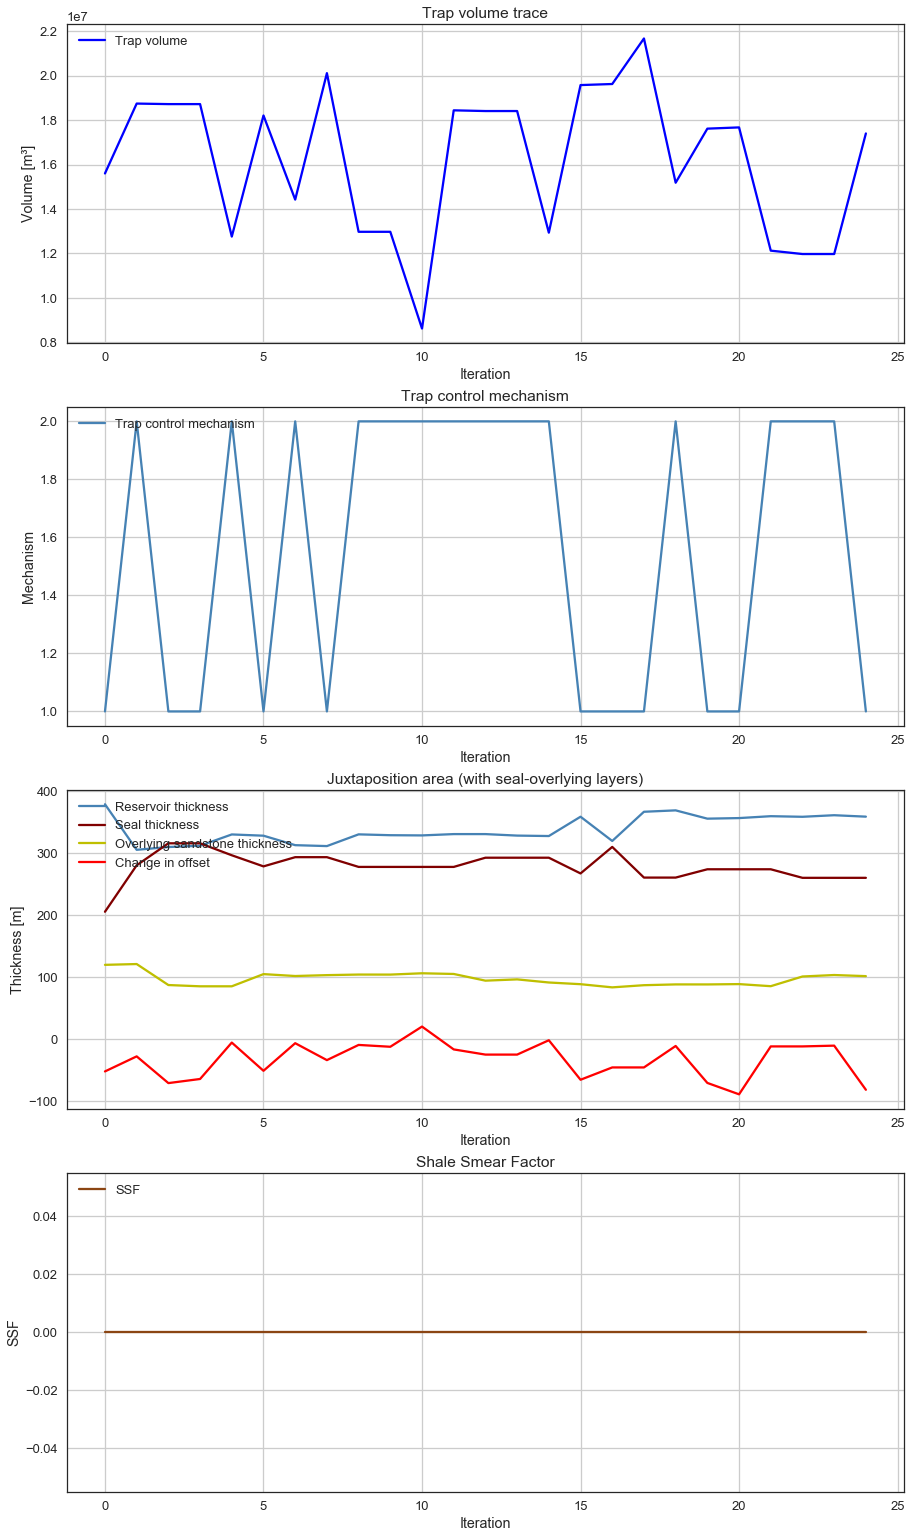

In [27]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace_L, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace_L, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace_L, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace_L, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace_L, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace_L*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace_L, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace_L, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


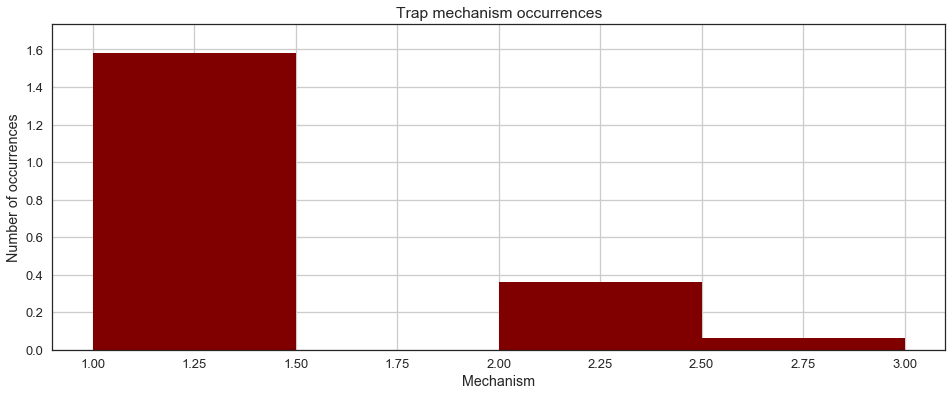

In [31]:
figsize(16, 6)
_hist1 = plt.hist(trap_control_trace_L, bins=4, normed=True, 
                  histtype="stepfilled", color = "maroon")
plt.title("Trap mechanism occurrences")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.ylabel("Number of occurrences")
plt.xlabel("Mechanism")

NameError: name '_hist_scale' is not defined

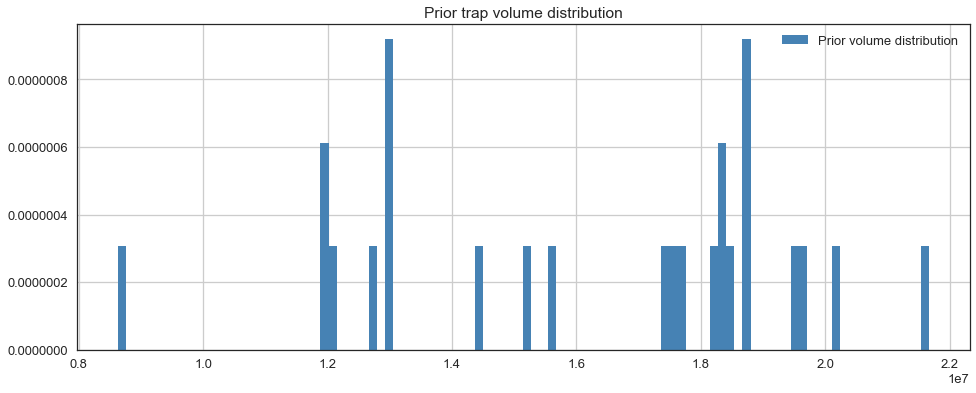

In [30]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
_hist2 = plt.hist(max_volume_trace_L, bins=100, normed=True, 
                  histtype="stepfilled",label="Prosterior volume distribution", color="indianred", alpha = 0.8)
_hist_scale = np.append(_hist1[0],_hist2[0])
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist_scale), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist_scale), label="Prior volume median", linestyles=":", color = "steelblue")
plt.vlines(max_volume_trace_L.mean(), 0, 1.1 * np.max(_hist_scale), label="Posterior volume mean", linestyles="-.", color = "indianred")
plt.vlines(np.median(max_volume_trace_L), 0, 1.1 * np.max(_hist_scale), label="Posterior volume median", linestyles=":", color = "indianred")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist_scale)+1, np.max(_hist_scale)/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist_scale))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [27]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

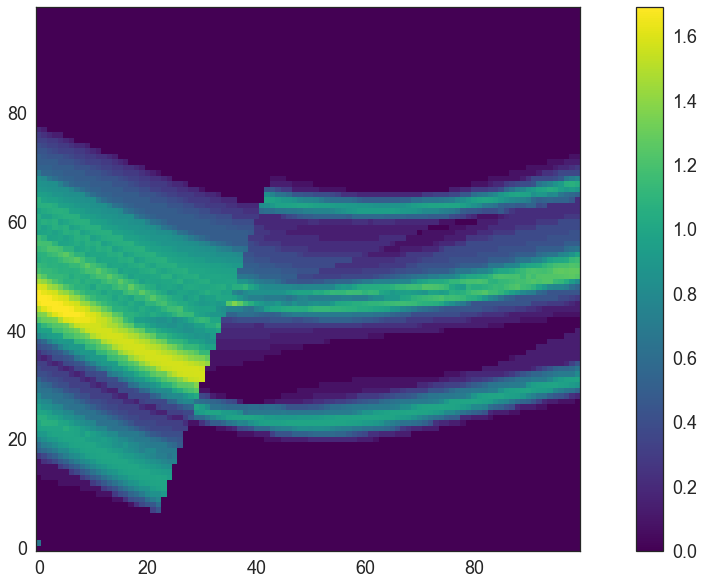

In [29]:
figsize(20,10)
fig, ax = plt.subplots(1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

Bayes action (minimum) at risk r 0.50: 20480000.00 --- expected loss: 2400390.00
Bayes action (minimum) at risk r 0.75: 20416000.00 --- expected loss: 3427900.00
Bayes action (minimum) at risk r 1.00: 18856000.00 --- expected loss: 4299340.00
Bayes action (minimum) at risk r 1.25: 18640000.00 --- expected loss: 5061300.00
Bayes action (minimum) at risk r 1.50: 18408000.00 --- expected loss: 5799120.00


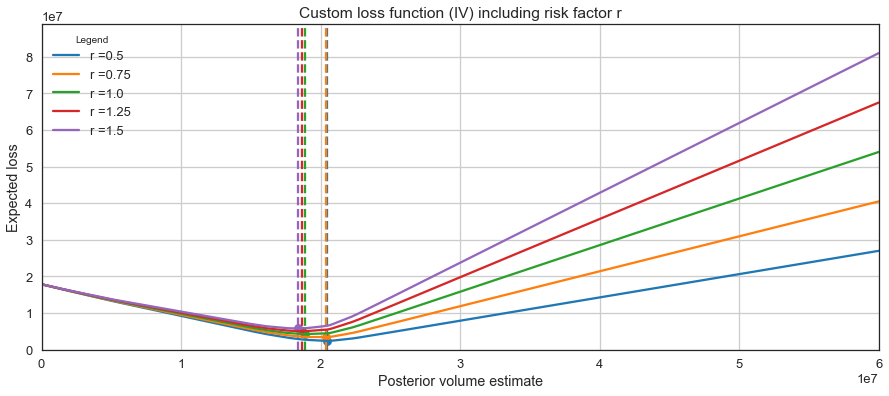

In [38]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace_L, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
#plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Posterior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()


In [ ]:
#import graphviz
#pymc.graph.dag(model)

In [ ]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
#graph = pymc.graph.graph(model)
#graph.write_png()

In [ ]:
#figsize(16, 9)
#
## No reduced uncertainty, different risks
#BA_before = np.zeros_like(risks_s)
#EL_before = np.zeros_like(risks_s)
#expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()
#
#counter = 0
#for r in risks_s:
#    loss = [expected_loss(e, r) for e in estimates_s]
#    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
#    #print(_min_score)
#    if _min_score < 0:
#        _min_score = 0
#    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
#    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
#    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
#    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
#    BA_before[counter] = _min_score
#    EL_before[counter] = expected_loss(_min_score,r)
#    counter += 1
#

In [ ]:
# DETERMINATION OF LAYER THICKNESSES ON HANGING- AND FOOTWALL BASED ON VOXEL-COUNTING
#fault_block = fault_sol[0,0]
#lith_block = lith_sol[0,0]
#th_factor = scale_factor
#
## Finding fault tips, upper and lower
#def find_fault_tips(fault_block):
#    fault_reshape = fault_block.reshape(50,50,50)
#    upper_fault_tip = np.count_nonzero(fault_reshape[:,25,49])+1
#    lower_fault_tip = np.count_nonzero(fault_reshape[:,25,0])-1
#    return upper_fault_tip, lower_fault_tip
#    
## Footwall thicknesses
#def fw_thicknesses(lith_block, upper_fault_tip, th_factor):
#    lith_reshape = lith_block.reshape(50,50,50)
#    fw_reservoir_count = 0
#    fw_seal_count = 0 
#    fw_sec_res_count = 0 
#    for i in lith_reshape[upper_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            fw_reservoir_count += 1
#            fw_reservoir_thickness = fw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            fw_seal_count += 1
#            fw_seal_thickness = fw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            fw_sec_res_count += 1
#            fw_sec_res_thickness = fw_sec_res_count * th_factor
#    return fw_reservoir_thickness, fw_seal_thickness, fw_sec_res_thickness
#
## Hanging wall thicknesses
#def hw_thicknesses(lith_block, lower_fault_tip, th_factor):
#    hw_reservoir_count = 0
#    hw_seal_count = 0 
#    hw_sec_res_count = 0 
#    for i in lith_reshape[lower_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            hw_reservoir_count += 1
#            hw_reservoir_thickness = hw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            hw_seal_count += 1
#            hw_seal_thickness = hw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            hw_sec_res_count += 1
#            hw_sec_res_thickness = hw_sec_res_count * th_factor
#    return hw_reservoir_thickness, hw_seal_thickness, hw_sec_res_thickness

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS IN INTERP_DATA

# Footwall at X = 1600 and Y = 1000
#def fw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (1400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    
#    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
#    
#    fw_res_th = np.abs(fw_sb_z-fw_rb_z)
#    fw_seal_th = np.abs(fw_r2b_z-fw_sb_z)
#    fw_sec_res_th = np.abs(fw_ob_z-fw_r2b_z)
#    return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z
#
## Hanging wall at X = 600 and Y = 1000
#def hw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    hw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_hw = interp_data.geo_data_res.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)*rescale_f
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)*rescale_f
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)*rescale_f
#    return hw_res_th, hw_seal_th, hw_sec_res_th

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS USING GEO_DATA
#res_bot_cond = geo_data.interfaces['formation'] == 'Reservoir'
#seal_bot_cond = geo_data.interfaces['formation'] == 'Seal'
#sec_res_bot_cond = geo_data.interfaces['formation'] == 'SecondaryReservoir'
#over_bot_cond = geo_data.interfaces['formation'] == 'Overlying'
#
#fw_x_cond = geo_data.interfaces['X'] == 1600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_fw = geo_data.interfaces[fw_x_cond]
#points_fw = points_fw[y_mid]
## finding Z-values for each layer bottom
#fw_rb_z = points_fw[res_bot_cond]['Z']
#fw_sb_z = points_fw[seal_bot_cond]['Z']
#fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#fw_ob_z = points_fw[over_bot_cond]['Z']
#
#fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
#hw_x_cond = geo_data.interfaces['X'] == 600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_hw = geo_data.interfaces[hw_x_cond]
#points_hw = points_hw[y_mid]
## finding Z-values for each layer bottom
#hw_rb_z = points_hw[res_bot_cond]['Z']
#hw_sb_z = points_hw[seal_bot_cond]['Z']
#hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#hw_ob_z = points_hw[over_bot_cond]['Z']
#
#hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)
#
## Footwall
#def fw_thicknesses():
#    fw_x_cond = geo_data.interfaces['X'] == 1600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_fw = geo_data.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    # finding Z-values for each layer bottom
#    fw_rb_z = points_fw[res_bot_cond]['Z']
#    fw_sb_z = points_fw[seal_bot_cond]['Z']
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#    fw_ob_z = points_fw[over_bot_cond]['Z']
#    
#    fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#    fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#    fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
## Hanging wall
#def hw_thicknesses():
#    hw_x_cond = geo_data.interfaces['X'] == 600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_hw = geo_data.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    # finding Z-values for each layer bottom
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)

In [ ]:
#@pymc.deterministic
#def fault_tips(fault_sol=pos_unc_model[1]):
#    fault = fault_sol[0,0]
#    return find_fault_tips(fault)    
#
#@pymc.deterministic
#def fw_th(lith_sol=pos_unc_model[0], upper_fault_tip=fault_tips[0]):
#    lith = lith_sol[0,0]
#    #print("FOOTWALL RES THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[0])
#    #print("FOOTWALL SEAL THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[1])
#    return fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)
#
#@pymc.deterministic
#def hw_th(lith_sol=pos_unc_model[0], lower_fault_tip=fault_tips[1]):
#    lith = lith_sol[0,0]
#    return hw_thicknesses(lith, lower_fault_tip, th_factor=scale_factor)